# Scheduling benchmarks analysis

## Library

In [46]:
import matplotlib.pyplot as plt
from typing import Optional, List, Tuple
import pandas as pd
import os
import re
import json
import subprocess
from enum import Enum
import lib
import graphing
import seaborn as sns

import importlib

# make changes to example.py file

importlib.reload(lib)
importlib.reload(graphing)

from lib import get_runs_dataframe, compute_caches_for_benchmark, compute_caches_for_repo
from graphing import BoxPlotter, DisplayType

#### Global variables

In [25]:
TRACE_CMD_CACHE_FILENAME = "trace_cmd_runtimes"
RESULTS_DIR_PATH = "../results"
TRACE_CMD_SUB_DIR = "_trace-cmd"

USE_TRACE_CMD_CACHE = True

def get_result_dir_path(result_dir_name):
    return os.path.join(RESULTS_DIR_PATH, result_dir_name)

def in_trace_cmd_dir(benchmark_dir_name) :
    return get_result_dir_path(TRACE_CMD_SUB_DIR + "/" + benchmark_dir_name)

#### Visualization params

In [5]:
DEFAULT_FIGURE_HEIGHT = 12

nb_enabled_color = "tab:orange"
nb_disabled_color = "tab:blue"

figure_height = DEFAULT_FIGURE_HEIGHT
min_figure_width = 40
figure_width_coeff = 0.3

line_width = 1.0

In [6]:
# Naming convention :
# - run : 1 set of files, either nb or no_nb
# - benchmark / result : 1 series of nb and 1 series of no_nb


def init_runs_plot():
    # plt.figure(figsize=(fig_width, 5))
    # plt.legend(loc="upper left")
    plt.xlabel("Nth run")
    plt.ylabel("Run time (seconds)")
    plt.grid(axis="y", which="both")
    plt.grid(axis="x", which="major")
    
    # ax = plt.gca()
    # ax.ticklabel_format(axis="x", useOffset=1.0)    
    
def plot_trace_cmd_run(df, data = "duration", label = None, color = None, init_plot = True, show_run_index = True) :
    if init_plot:
        init_runs_plot()
    plt.plot(df.index, df[data], label=label, color=color, linewidth=line_width)
    
    current_xticks_count = len(plt.xticks()[0])
    if len(df) > current_xticks_count :
        plt.xticks(range(len(df)), rotation=45)
        plt.xlim(-1, len(df))
        
    if data == "duration" :
        candidate_ylim_max = df[data].max() * 1.2
        if candidate_ylim_max > plt.ylim()[1] :
            plt.ylim(0, candidate_ylim_max)
        
    fig = plt.gcf()
    candidate_width = max(int(len(df) * figure_width_coeff), min_figure_width)
    curr_width = fig.get_size_inches()[0]
    if candidate_width > curr_width :
        fig.set_size_inches(candidate_width, figure_height)
    
    if label :
        plt.legend(loc="upper left")

    if show_run_index :
        ax = plt.gca()
        for idx in df.index:
            if not df['exists'][idx]:
                continue
            ax.text(idx, df[data][idx], df['run_index'][idx], fontsize=8)
    


In [7]:
trace_cmd_folders_color = {
    "nb": "tab:orange",
    "nb_memory": "tab:purple",
    "nb_tasks": "tab:green",
    "no_nb": "tab:blue"
}

def plot_trace_cmd_runs(dir_path, label, data = "duration", show_run_index = True, sort_by = None, color = None) :
    df = get_runs_dataframe(dir_path, USE_TRACE_CMD_CACHE, TRACE_CMD_CACHE_FILENAME)
    if df is None :
        return
    if sort_by is not None :
        df.sort_values(sort_by, ignore_index=True, inplace=True)
    plot_trace_cmd_run(df, data=data, label=label, color=color, init_plot=False, show_run_index=show_run_index)
    
def plot_trace_cmd_benchmark_dir(benchmark_dir_name, label_prefix, data = "duration", show_run_index = True, sort_by = None, folder_name_filters = None) :
    if not sort_by :
        sort_by = 'duration'

    def is_dir_name_in_filters(dir_name) :
        if folder_name_filters is None or len(folder_name_filters) == 0 :
            return True
        return any([filter_substr in dir_name for filter_substr in folder_name_filters])
        
    benchmark_dir_path = get_result_dir_path(benchmark_dir_name)
    contents = os.listdir(benchmark_dir_path)
    for c in contents :
        dir_path = os.path.join(benchmark_dir_path, c)
        if not os.path.isdir(dir_path) :
            continue
        if not is_dir_name_in_filters(c) :
            continue
        
        df = get_runs_dataframe(dir_path, USE_TRACE_CMD_CACHE, TRACE_CMD_CACHE_FILENAME)
        if df is None :
            continue
        if sort_by is not None :
            df.sort_values(sort_by, ignore_index=True, inplace=True)
        plot_trace_cmd_run(df, data=data, label=label_prefix + " " + c, color=None, init_plot=False, show_run_index=show_run_index)
        
def get_trace_benchmark_dir_path(benchmark_dir_name) :
    return get_result_dir_path(TRACE_CMD_SUB_DIR + "/" + benchmark_dir_name)

In [44]:
compute_caches_for_benchmark(in_trace_cmd_dir("cg.B.x__dahu-17__v6.8.0-rc3__performance__2024-04-26"), TRACE_CMD_CACHE_FILENAME, False)

Computing runtime  cache for benchmark in ../results/_trace-cmd/cg.B.x__dahu-17__v6.8.0-rc3__performance__2024-04-26
Skipping cache computation for batch in ../results/_trace-cmd/cg.B.x__dahu-17__v6.8.0-rc3__performance__2024-04-26/nb-disabled-none because it already exists and broken work conservation computation not requested
Skipping cache computation for batch in ../results/_trace-cmd/cg.B.x__dahu-17__v6.8.0-rc3__performance__2024-04-26/nb-enabled-sequential because it already exists and broken work conservation computation not requested
Skipping cache computation for batch in ../results/_trace-cmd/cg.B.x__dahu-17__v6.8.0-rc3__performance__2024-04-26/nb-enabled-sockorder because it already exists and broken work conservation computation not requested
Skipping cache computation for batch in ../results/_trace-cmd/cg.B.x__dahu-17__v6.8.0-rc3__performance__2024-04-26/nb-disabled-sequential because it already exists and broken work conservation computation not requested
Skipping cache c

In [47]:
compute_caches_for_repo(in_trace_cmd_dir(""), TRACE_CMD_CACHE_FILENAME, False)

Computing runtime  cache for benchmark in ../results/_trace-cmd/
Computing runtime  cache for benchmark in ../results/_trace-cmd/ua.C.x__yeti-1__v6.8.0-rc3__performance__2024-03-11
Skipping cache computation for batch in ../results/_trace-cmd/ua.C.x__yeti-1__v6.8.0-rc3__performance__2024-03-11/nb-disabled-none because it already exists and broken work conservation computation not requested
Skipping cache computation for batch in ../results/_trace-cmd/ua.C.x__yeti-1__v6.8.0-rc3__performance__2024-03-11/nb-enabled-sequential because it already exists and broken work conservation computation not requested
Skipping cache computation for batch in ../results/_trace-cmd/ua.C.x__yeti-1__v6.8.0-rc3__performance__2024-03-11/nb-enabled-sockorder because it already exists and broken work conservation computation not requested
Skipping cache computation for batch in ../results/_trace-cmd/ua.C.x__yeti-1__v6.8.0-rc3__performance__2024-03-11/nb-disabled-sequential because it already exists and broken 

## 1. Numa Balancing Exploration graph

Get a graph of a lot of NAS benchmark with and without NUMA balancing. What would make sense is to only have them as variation and find a way to show the reference runtime for each of them ?

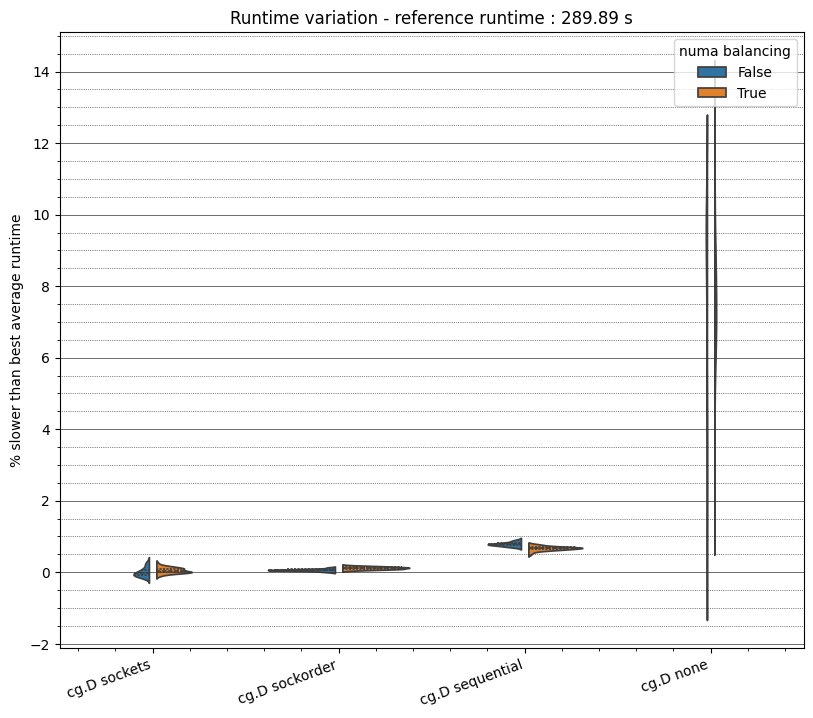

In [18]:
bp = BoxPlotter(USE_TRACE_CMD_CACHE, TRACE_CMD_CACHE_FILENAME)
bp.add_trace_cmd_directory(get_trace_benchmark_dir_path("cg.D.x__troll-1__v6.8.0-rc3__performance__2024-03-30"), "cg.D")
bp.show_violin(displayType=DisplayType.VARIATION, size_factor=2, filters=["sockets", "sockorder", "sequential", "none"])

['cg.D nb-disabled-hyperthreads-locked', 'cg.D nb-disabled-hyperthreads-free', 'cg.D nb-disabled-none', 'cg.D nb-enabled-sequential', 'cg.D nb-enabled-sockorder', 'cg.D nb-disabled-sequential', 'cg.D nb-enabled-hyperthreads-free', 'cg.D nb-disabled-sockorder', 'cg.D nb-enabled-sockets', 'cg.D nb-enabled-none', 'cg.D nb-disabled-sockets']


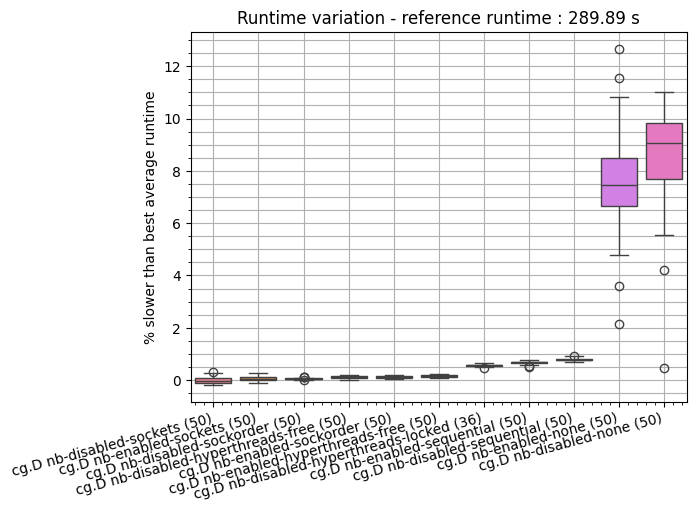

In [21]:
bp = BoxPlotter(USE_TRACE_CMD_CACHE, TRACE_CMD_CACHE_FILENAME)
bp.add_trace_cmd_directory(get_trace_benchmark_dir_path("cg.D.x__troll-1__v6.8.0-rc3__performance__2024-03-30"), "cg.D")
bp.show_variations()

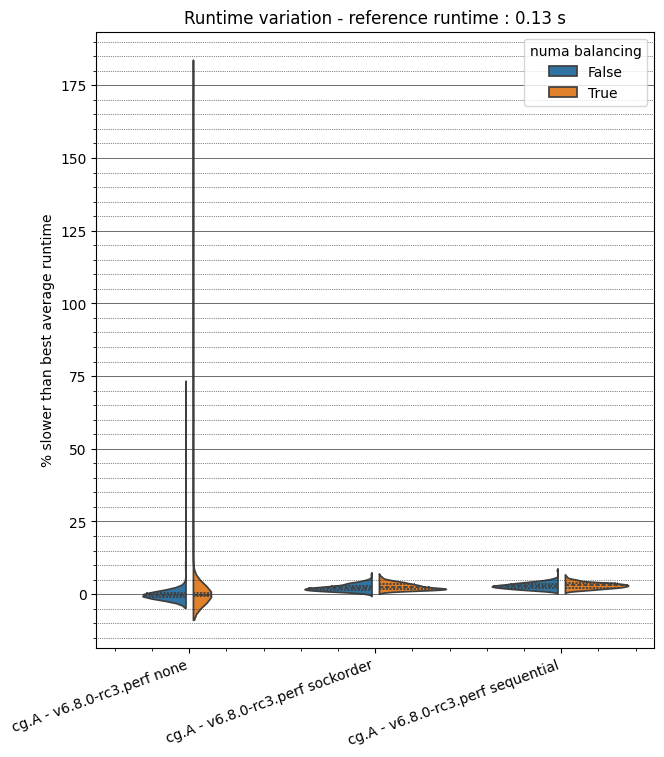

In [27]:
bp = BoxPlotter(USE_TRACE_CMD_CACHE, TRACE_CMD_CACHE_FILENAME)
bp.add_trace_cmd_directory(in_trace_cmd_dir("cg.A.x__dahu-17__v6.8.0-rc3__performance__2024-04-26"), "cg.A - v6.8.0-rc3.perf")
bp.show_violin(displayType=DisplayType.VARIATION, size_factor=2)

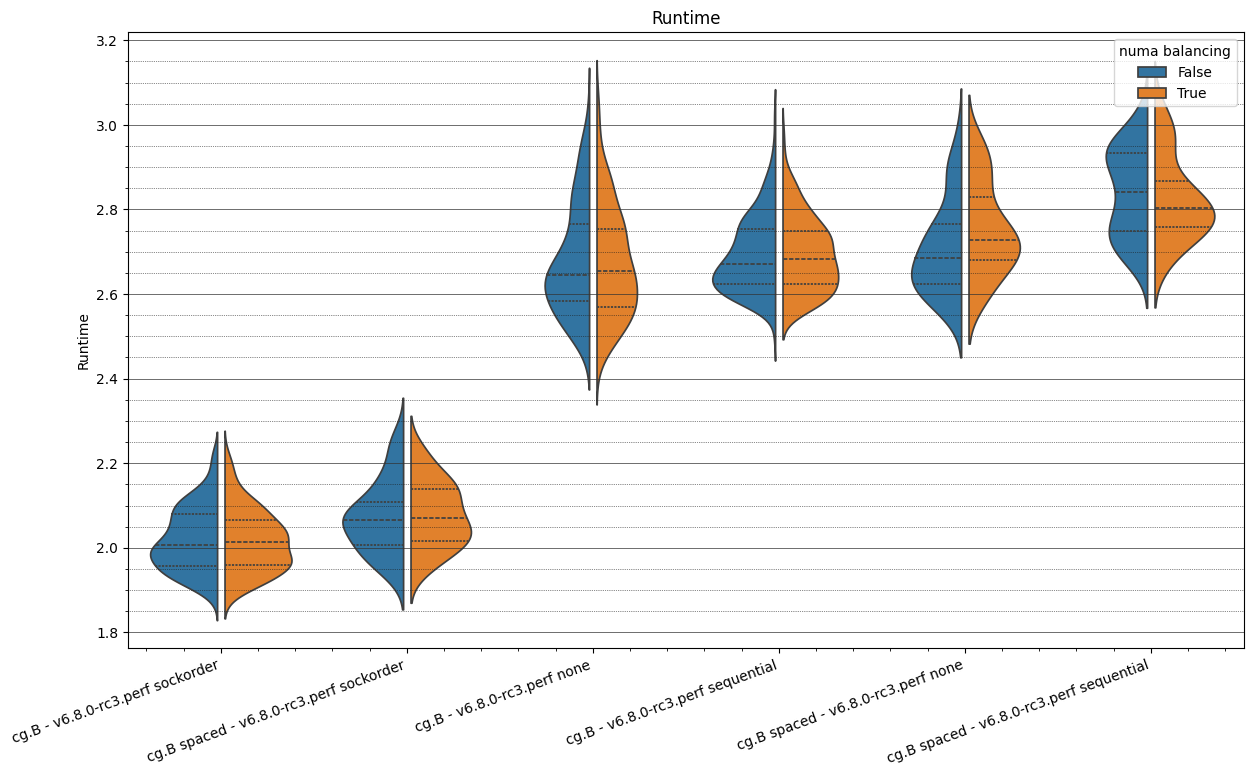

In [61]:
bp = BoxPlotter(USE_TRACE_CMD_CACHE, TRACE_CMD_CACHE_FILENAME)
bp.add_trace_cmd_directory(get_trace_benchmark_dir_path("cg.B.x__dahu-17__v6.8.0-rc3__performance__2024-04-26"), "cg.B spaced - v6.8.0-rc3.perf")
bp.add_trace_cmd_directory(get_trace_benchmark_dir_path("cg.B.x__dahu-22__v6.8.0-rc3__performance__2024-04-26"), "cg.B - v6.8.0-rc3.perf")
bp.show_violin(size_factor=2)

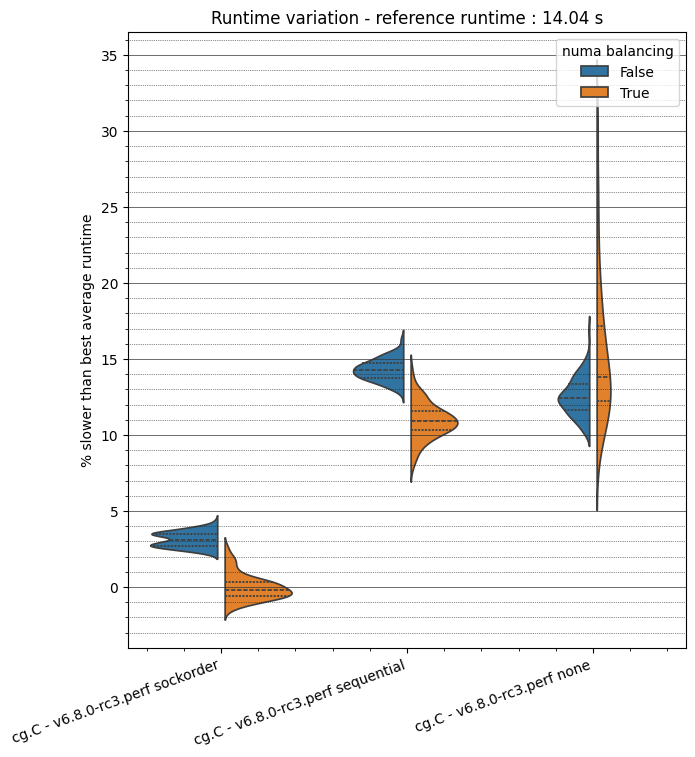

In [16]:
bp = BoxPlotter()
bp.add_trace_cmd_directory("cg.C.x__dahu-17__v6.8.0-rc3__performance__2024-04-26", "cg.C - v6.8.0-rc3.perf")
bp.show_violin(size_factor=2)

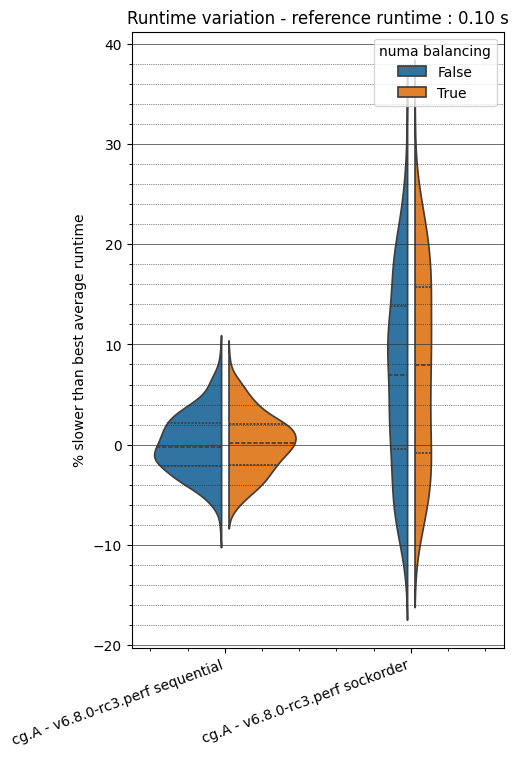

In [22]:
bp = BoxPlotter()
bp.add_trace_cmd_directory("cg.A.x__dahu-22__v6.8.0-rc3__performance__2024-04-26", "cg.A - v6.8.0-rc3.perf")
bp.show_variations_violin(size_factor=2, filters=["sockorder", "sequential"])

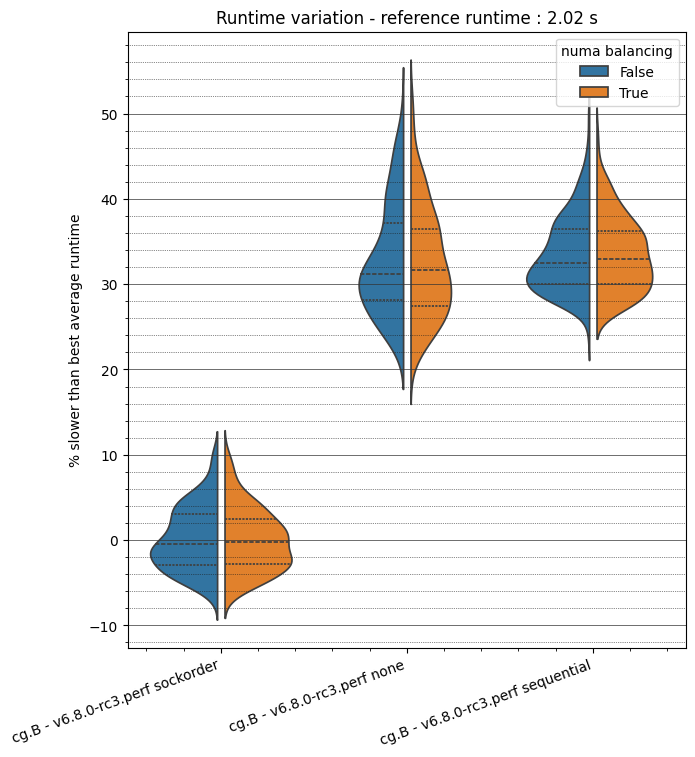

In [20]:
bp = BoxPlotter()
bp.add_trace_cmd_directory("cg.B.x__dahu-22__v6.8.0-rc3__performance__2024-04-26", "cg.B - v6.8.0-rc3.perf")
bp.show_variations_violin(size_factor=2)

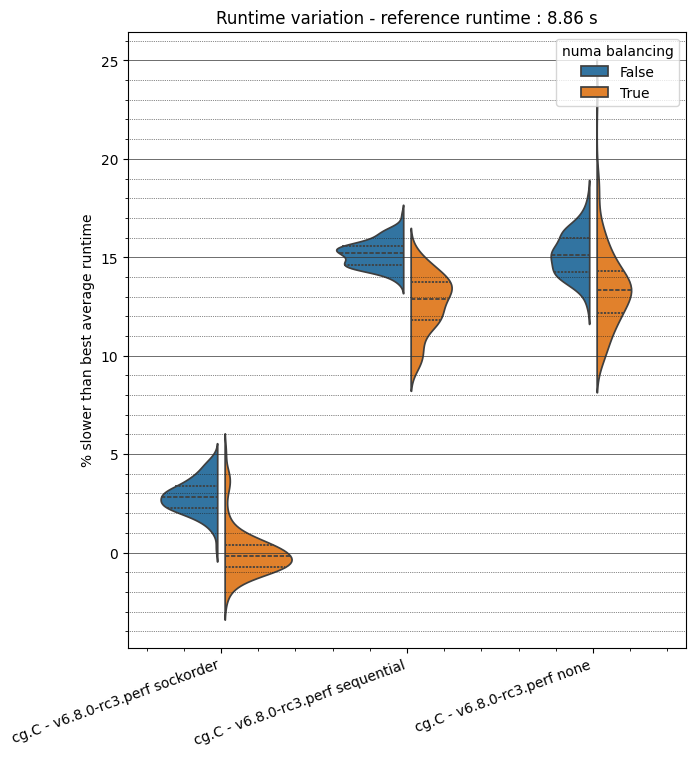

In [23]:
bp = BoxPlotter()
bp.add_trace_cmd_directory("cg.C.x__dahu-22__v6.8.0-rc3__performance__2024-04-26", "cg.C - v6.8.0-rc3.perf")
bp.show_variations_violin(size_factor=2)

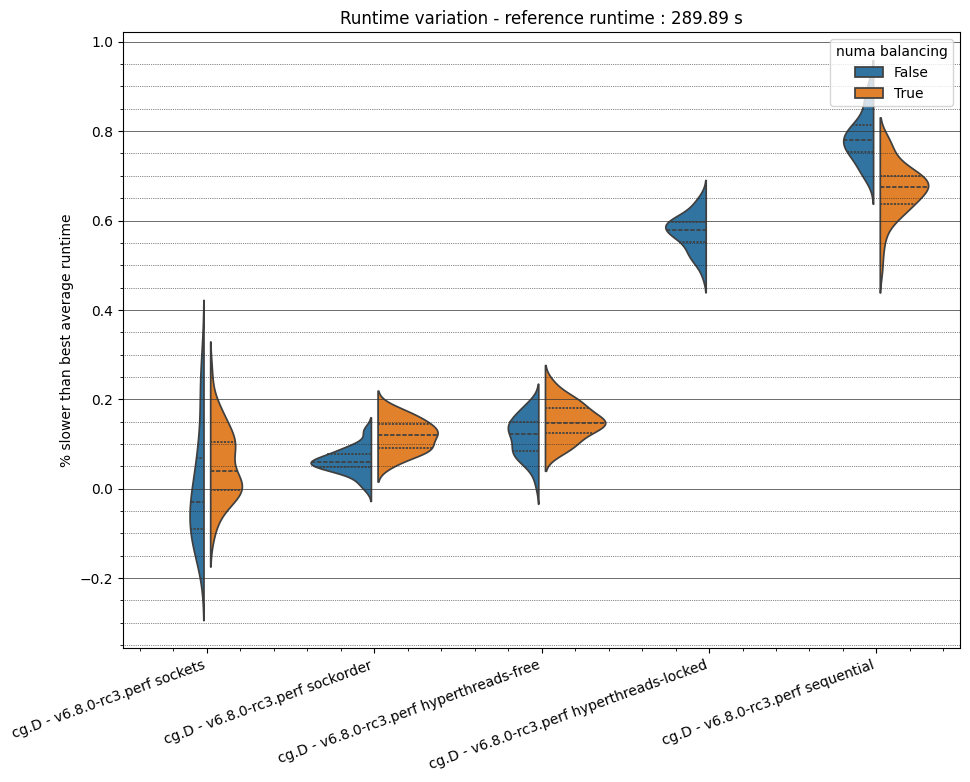

In [26]:
bp = BoxPlotter()
bp.add_trace_cmd_directory("cg.D.x__troll-1__v6.8.0-rc3__performance__2024-03-30", "cg.D - v6.8.0-rc3.perf")
bp.show_variations_violin(size_factor=2, filters=["sock", "hyper", "seq"])

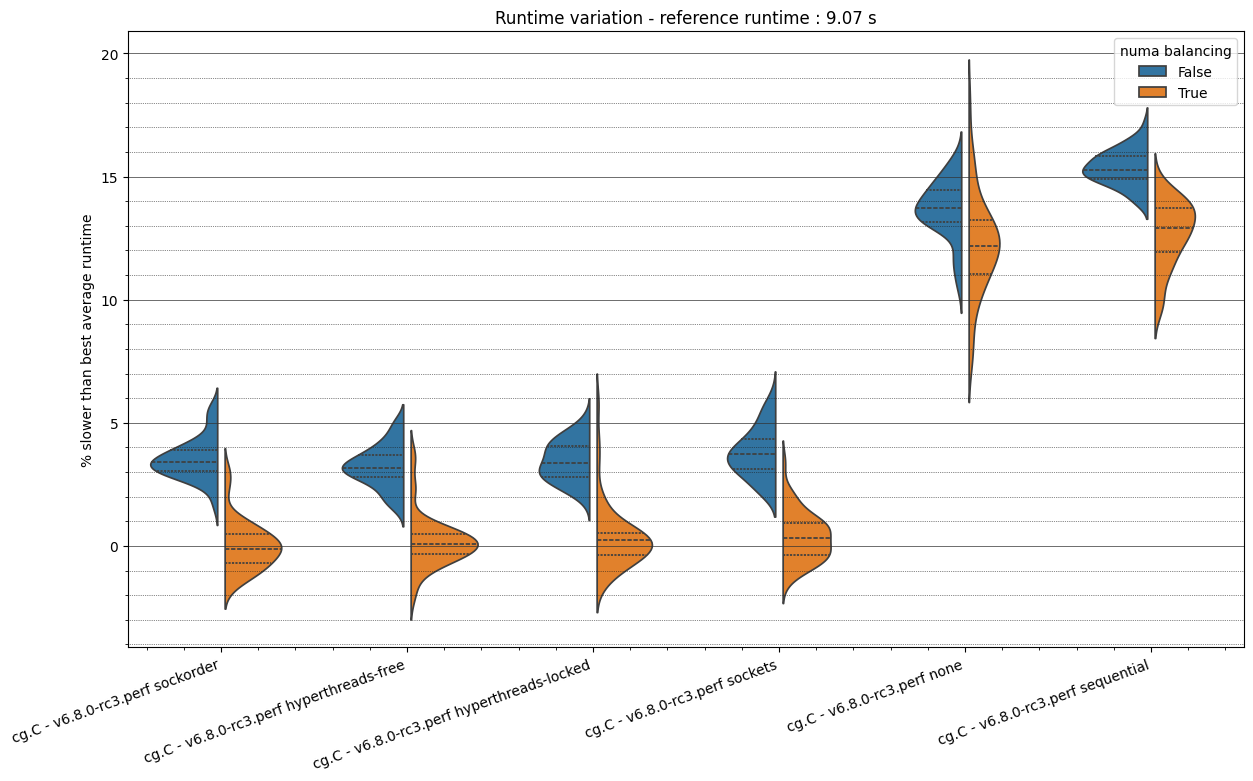

In [184]:
bp = BoxPlotter()
bp.add_trace_cmd_directory("cg.C.x__dahu-28__v6.8.0-rc3__performance__2024-03-28", "cg.C - v6.8.0-rc3.perf")
bp.show_variations_violin(size_factor=2)

# Thread placement comparison

In [4]:
import random
threads = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50,52,54,56,58,60,62]
random.shuffle(threads)

formatted_elements = [f"{{{element}}}" for element in threads]
print(",".join(formatted_elements))

{26},{14},{30},{62},{28},{4},{54},{22},{44},{6},{60},{16},{32},{18},{10},{24},{2},{46},{50},{58},{38},{8},{34},{40},{48},{56},{42},{36},{52},{12},{0},{20}


### BT

bt.C on dahu 15


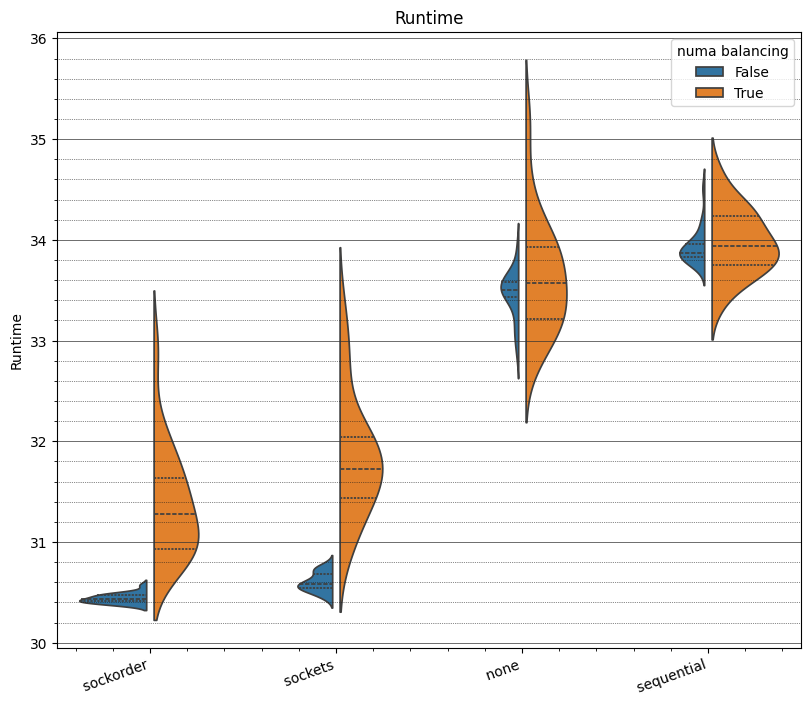

In [13]:
sort_by='duration'
# sort_by='run_index'
show_run_index = True
# show_run_index = False

# print("bt.B on dahu 15")
# vp = Plotter()
# vp.add_trace_cmd_directory("_trace-cmd/bt.B.x__dahu-15__v6.8.0-rc3__performance__2024-03-08")
# # vp.print_filter_names()
# vp.show_variations(name_filters = ["none", "sockorder"])

# bp = BoxPlotter()
# bp.add_trace_cmd_directory("_trace-cmd/bt.B.x__dahu-15__v6.8.0-rc3__performance__2024-03-08")
# bp.show_variations(name_filters=["none"])

print("bt.C on dahu 15")
vp = BoxPlotter(USE_TRACE_CMD_CACHE, TRACE_CMD_CACHE_FILENAME)
vp.add_trace_cmd_directory(get_trace_benchmark_dir_path("bt.C.x__dahu-15__v6.8.0-rc3__performance__2024-03-08"))
# vp.show_variations(name_filters = ["none", "sockorder"])
vp.show_variations(size_factor=2)

# print("bt.C on yeti 3")
# vp = Plotter()
# vp.add_trace_cmd_directory("_trace-cmd/bt.C.x__yeti-3__v6.8.0-rc3__performance__2024-03-11")
# vp.show_variations(name_filters = ["none", "sockorder"])

# bp = BoxPlotter()
# bp.add_trace_cmd_directory("_trace-cmd/bt.C.x__yeti-3__v6.8.0-rc3__performance__2024-03-11")
# bp.show_variations(name_filters=["none"])

### CG

cg.C on dahu 28


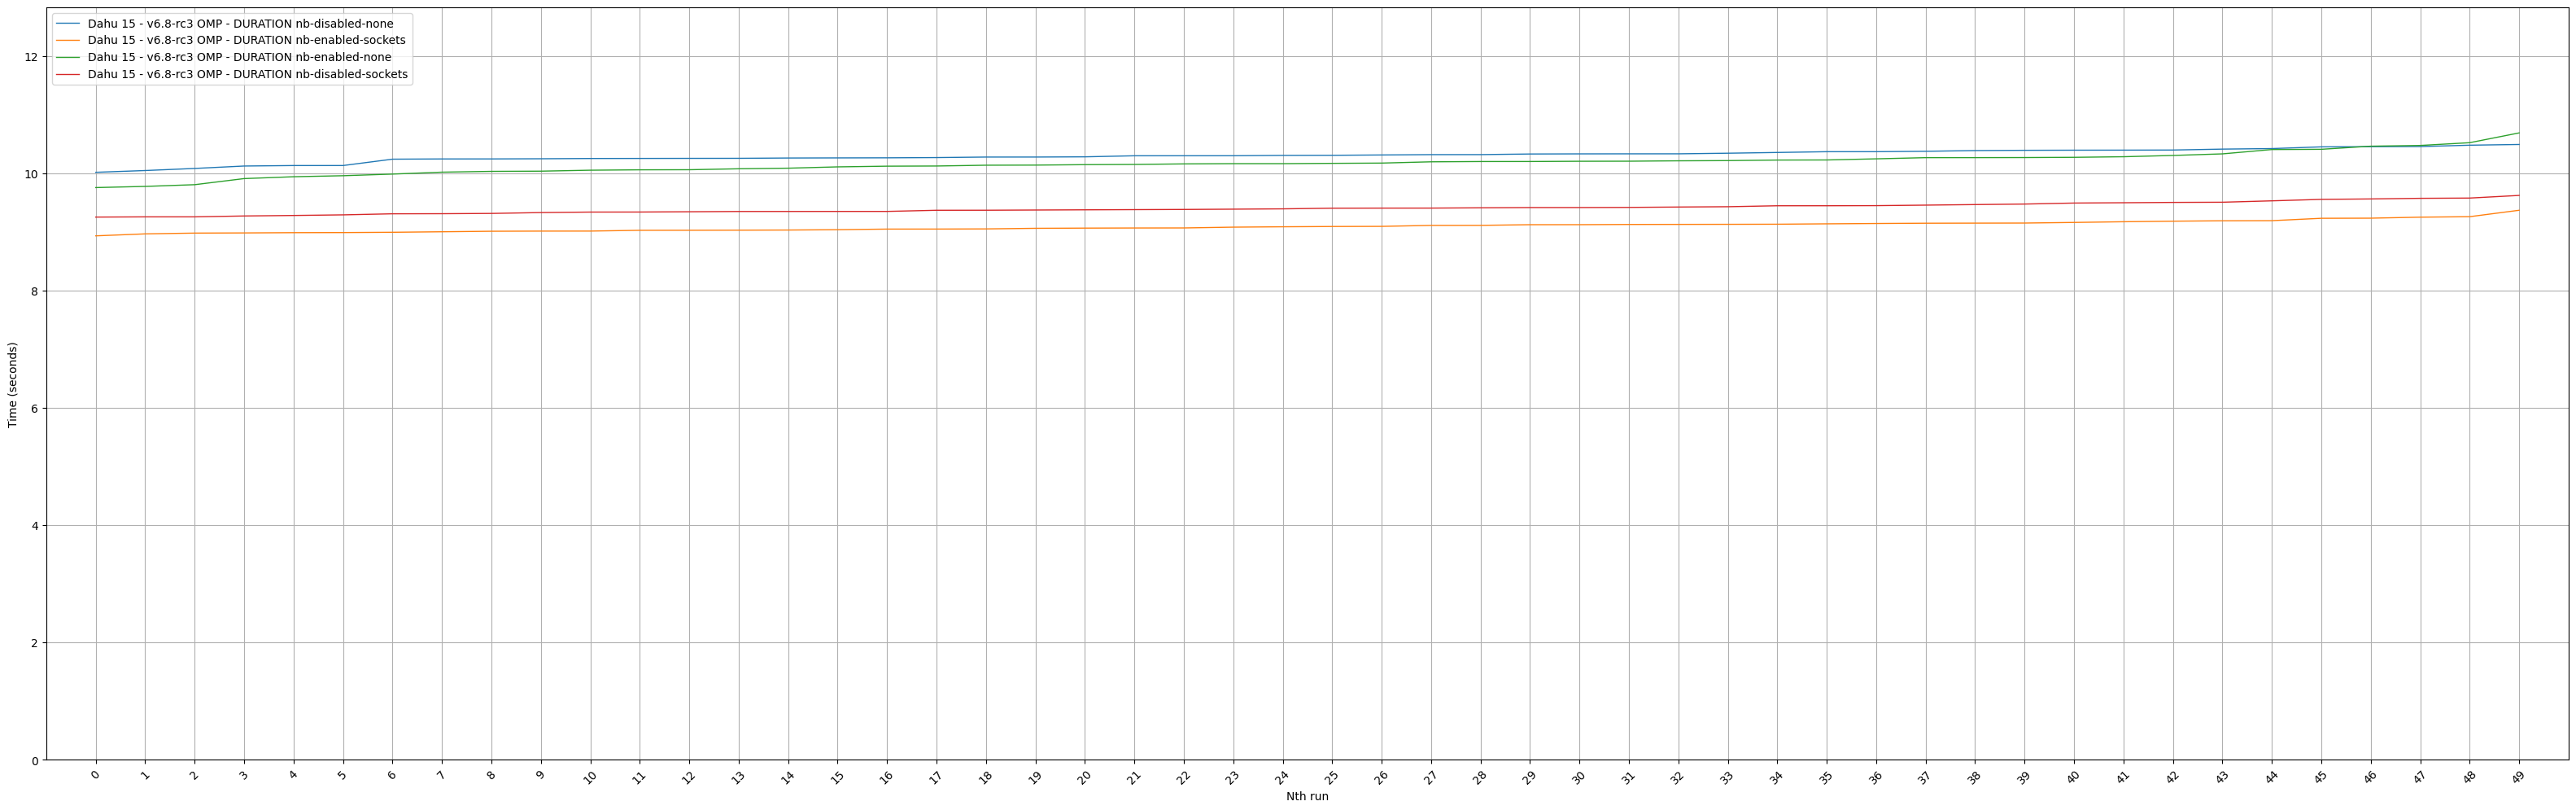

cg.D on troll 1


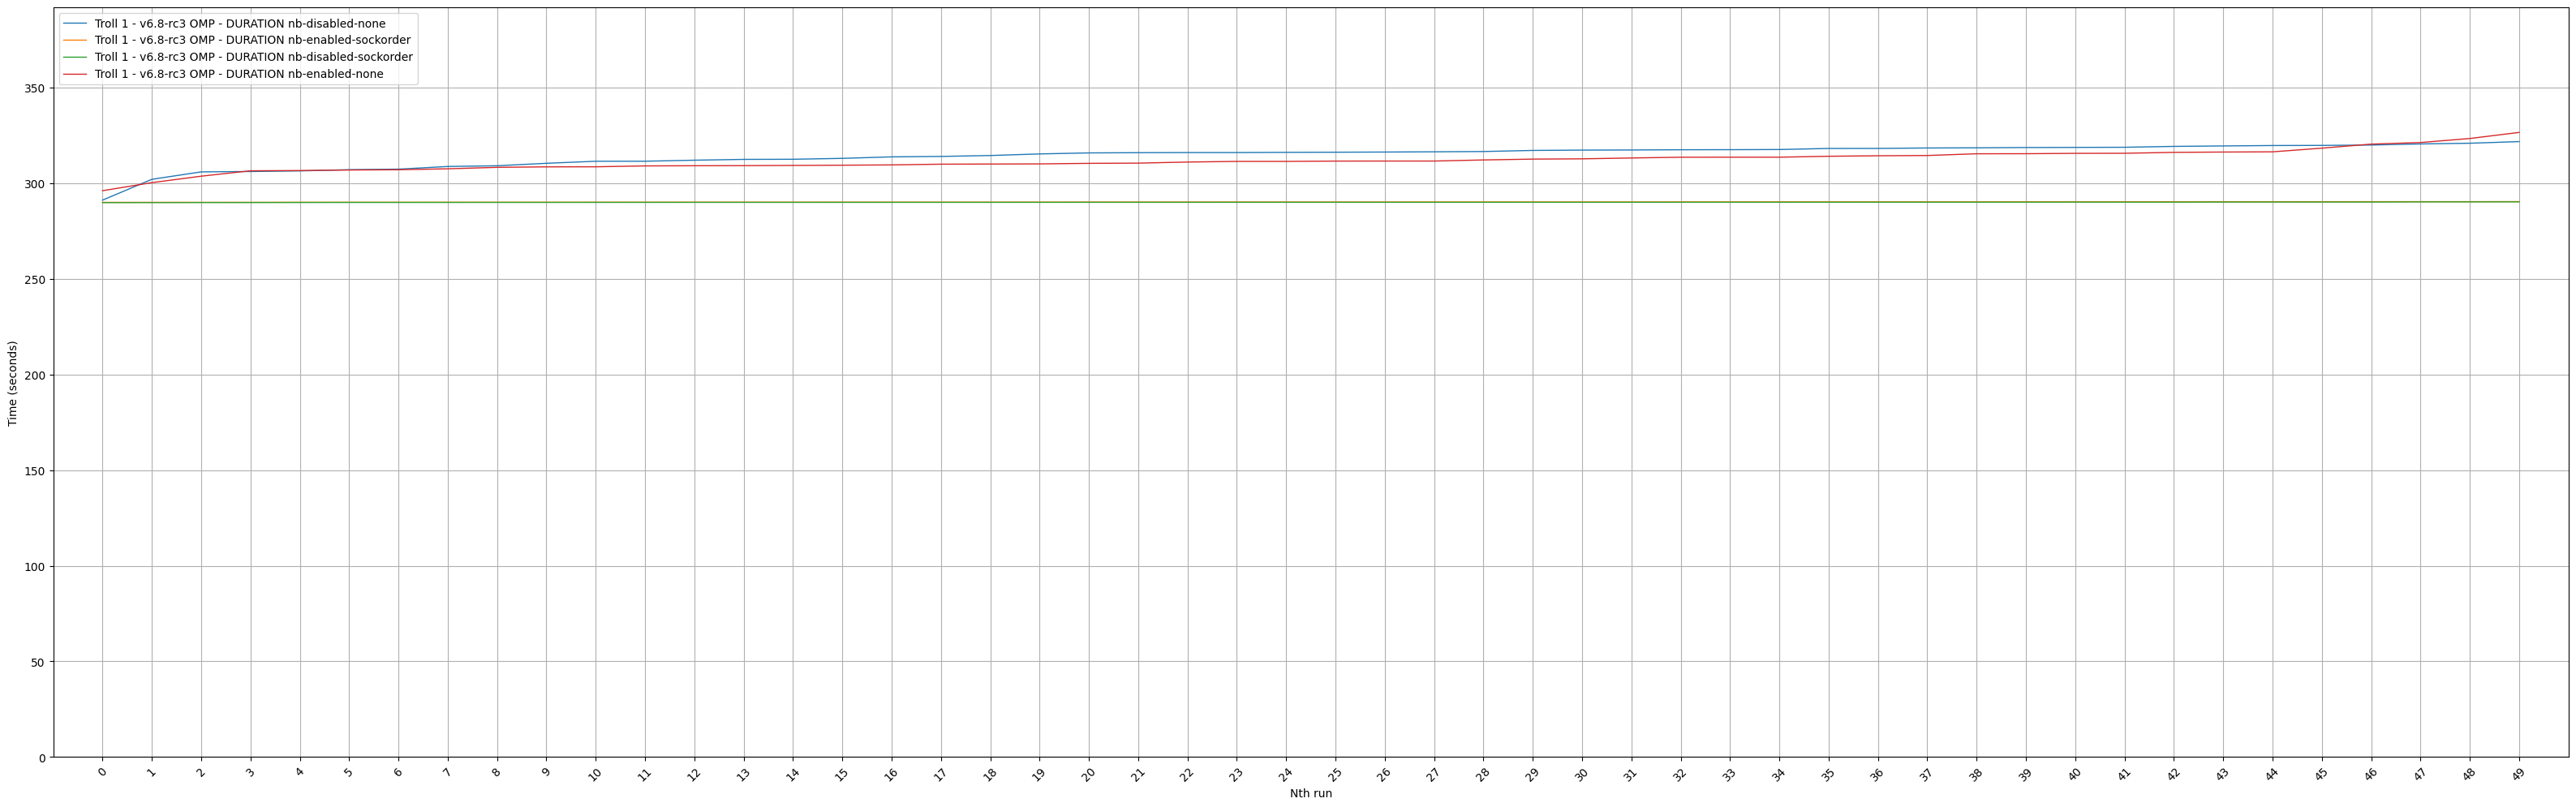

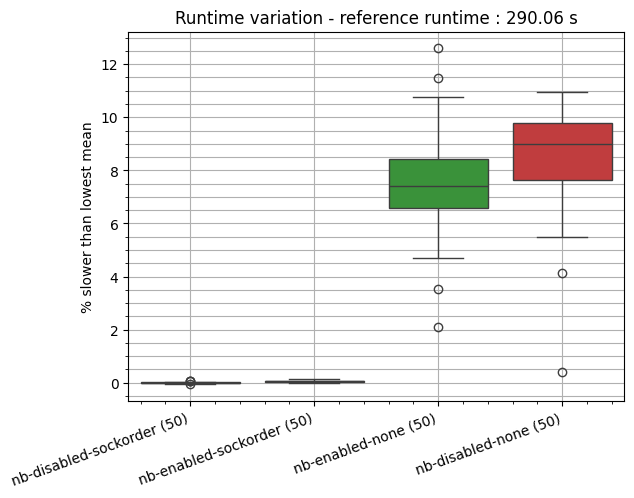

In [10]:
sort_by='duration'
# sort_by='run_index'
# show_run_index = True
show_run_index = False

print("cg.C on dahu 28")
vp = Plotter()
vp.add_trace_cmd_directory("_trace-cmd/cg.C.x__dahu-28__v6.8.0-rc3__performance__2024-03-28", "Dahu 15 - v6.8-rc3 OMP -", sort_by=sort_by)
# vp.print_filter_names()
vp.show_times(name_filters = ["none", "socket"], show_labels=show_run_index) # reference_idx=5

# vp = Plotter()
# vp.add_trace_cmd_directory("_trace-cmd/cg.C.x__dahu-28__v6.8.0-rc3__performance__2024-03-28", sort_by=sort_by, data = DataType.DURATION_ADJUSTED_FOR_WC)
# vp.print_filter_names()
# vp.show_times(name_filters = ["none"], show_labels=show_run_index)

print("cg.D on troll 1") # TODO Have automated mechanism to print graph info before the graph
vp = Plotter()
vp.add_trace_cmd_directory("_trace-cmd/cg.D.x__troll-1__v6.8.0-rc3__performance__2024-03-30", "Troll 1 - v6.8-rc3 OMP -", sort_by=sort_by)
# vp.set_reference_index(10)
vp.show_times(name_filters = ["none", "sockorder"], show_labels=show_run_index)

bp = BoxPlotter()
bp.add_trace_cmd_directory("_trace-cmd/cg.D.x__troll-1__v6.8.0-rc3__performance__2024-03-30")
bp.show_variations(filters = ["none", "sockorder"])


# init_runs_plot()
# print("cg.C on yeti 3")
# plot_trace_cmd_benchmark_dir("cg.C.x__yeti-3__v6.8.0-rc3__performance__2024-03-11", "Yeti 3 - v6.8-rc3 OMP -", show_run_index=show_run_index, sort_by=sort_by)
# plt.show()

### DC

In [18]:
sort_by='duration'
# sort_by='run_index'
# show_run_index = True
show_run_index = False

# Ww should not look at DC

# init_runs_plot()
# print("dc.B on dahu 13")
# plot_trace_cmd_benchmark_dir("dc.B.x__dahu-13__v6.8.0-rc3__performance__2024-03-09", "Dahu 15 - v6.8-rc3 OMP -", show_run_index=show_run_index, sort_by=sort_by)
# plt.show()

### FT

ft.C on dahu 15
Reference value :  7.243927999996231


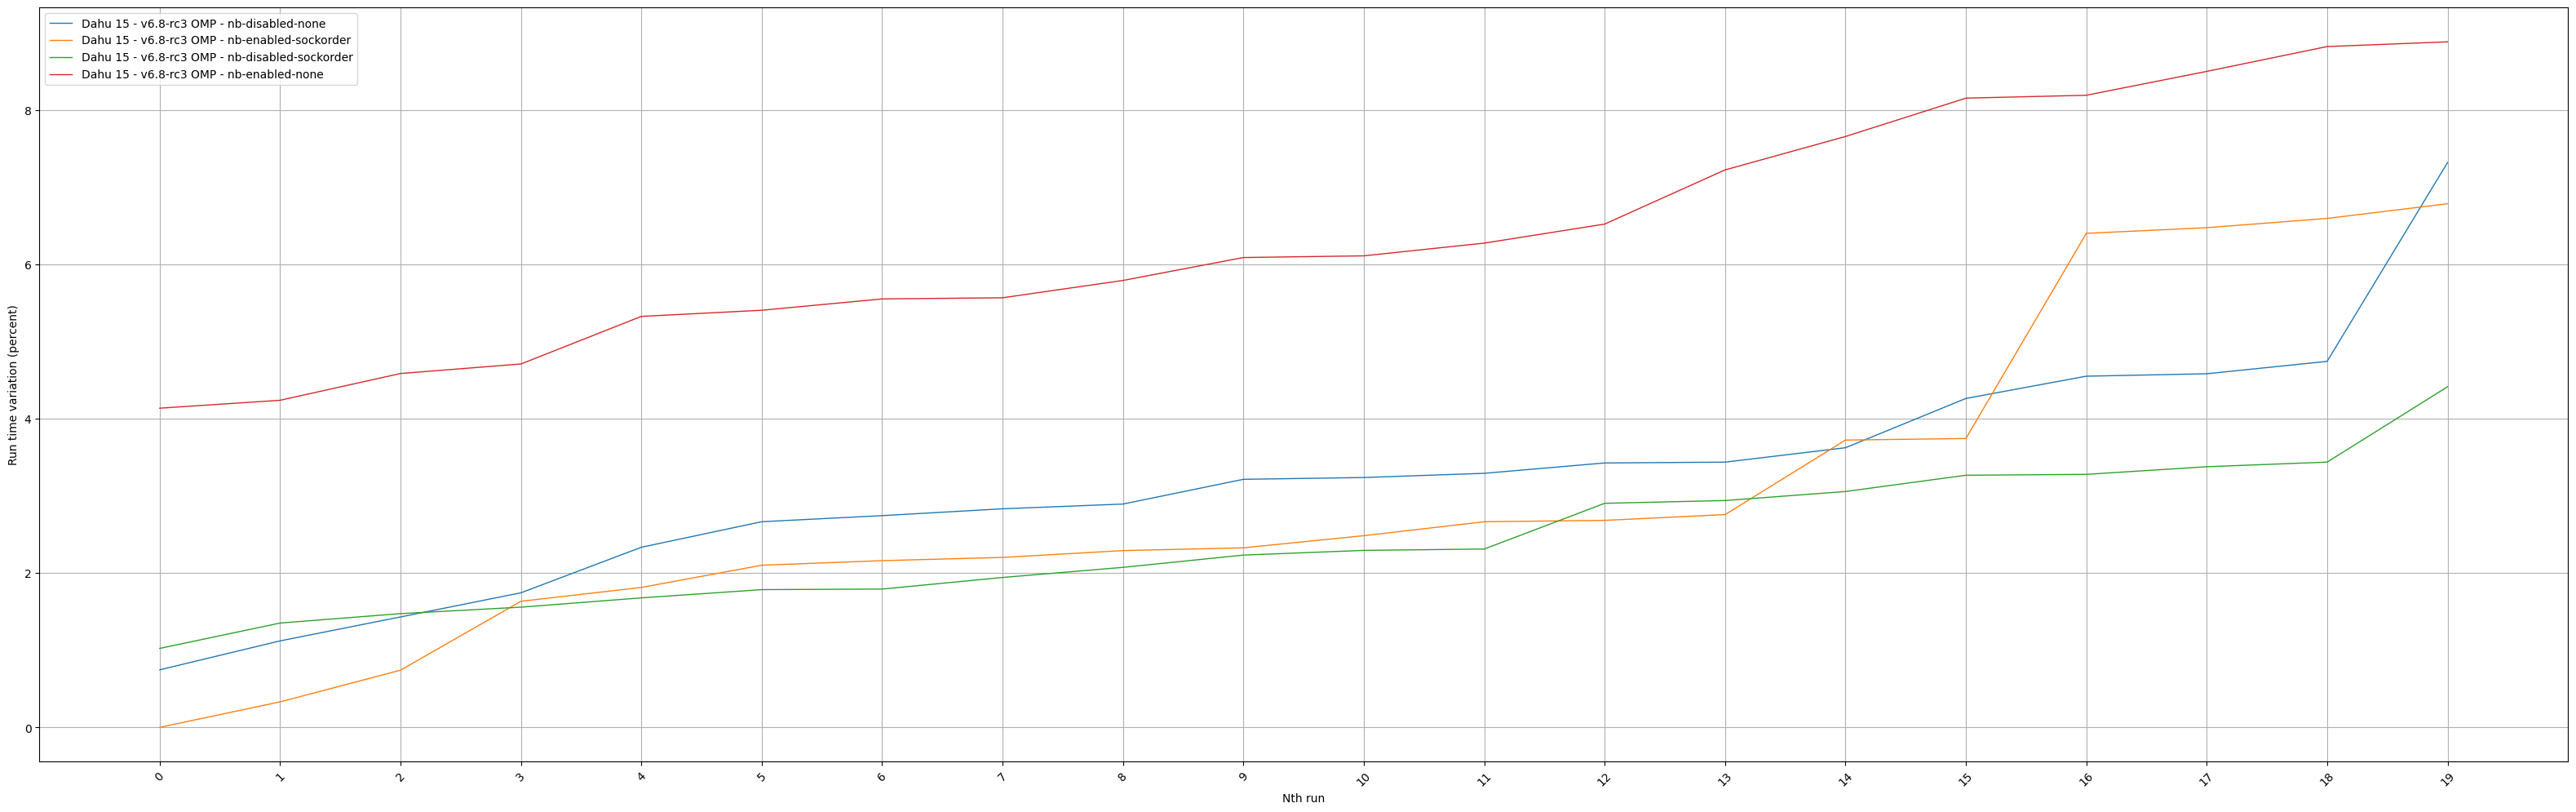

ft.C on yeti 3


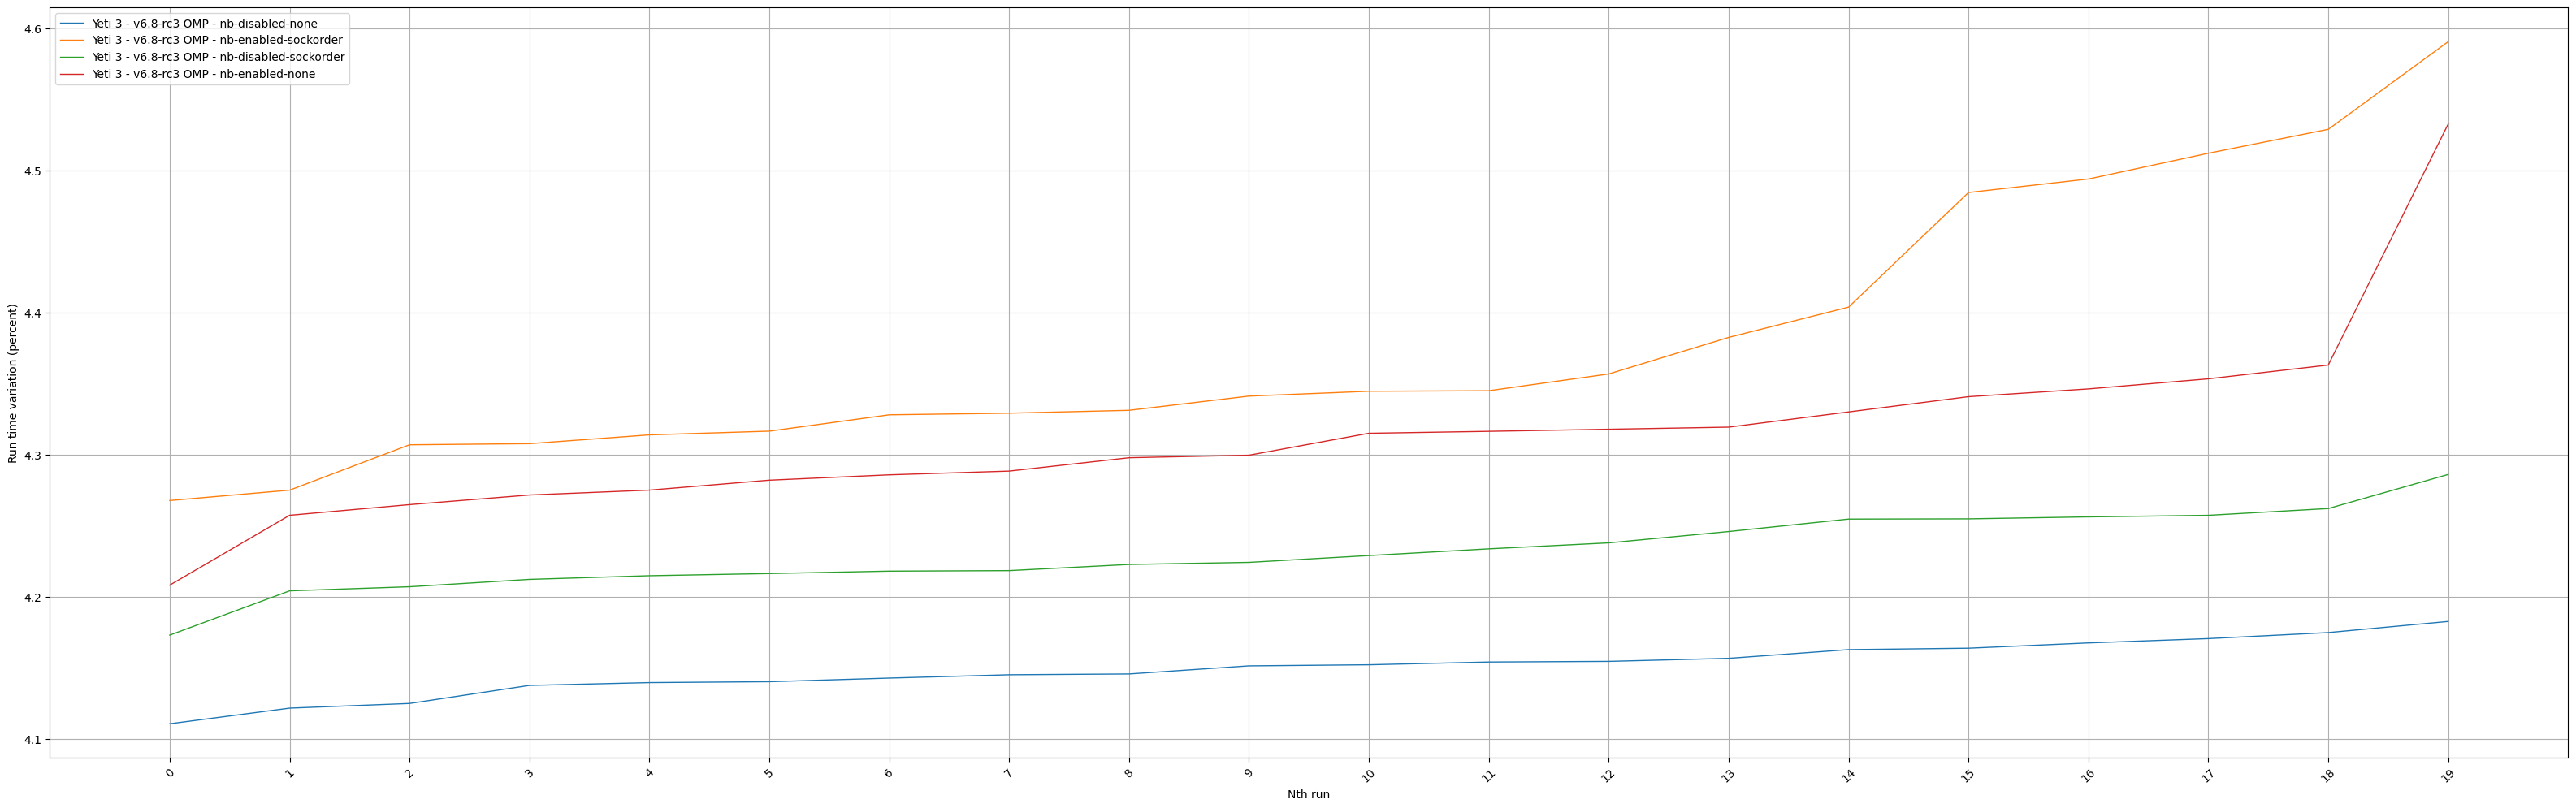

In [46]:
sort_by='duration'
# sort_by='run_index'
# show_run_index = True
show_run_index = False

print("ft.C on dahu 15")
vp = Plotter()
vp.add_trace_cmd_directory("_trace-cmd/ft.C.x__dahu-15__v6.8.0-rc3__performance__2024-03-09", "Dahu 15 - v6.8-rc3 OMP -", sort_by=sort_by)
vp.show_variations(name_filters = ["none", "sockorder"], show_labels=show_run_index)

print("ft.C on yeti 3")
vp = Plotter()
vp.add_trace_cmd_directory("_trace-cmd/ft.C.x__yeti-3__v6.8.0-rc3__performance__2024-03-11", "Yeti 3 - v6.8-rc3 OMP -", sort_by=sort_by)
vp.show_times(name_filters = ["none", "sockorder"], show_labels=show_run_index)

NameError: name 'lib' is not defined

### LU

lu.C on dahu 15
df columns :  Index(['filename', 'duration', 'broken_wc_time'], dtype='object')
df columns :  Index(['filename', 'duration', 'broken_wc_time'], dtype='object')
df columns :  Index(['filename', 'duration', 'broken_wc_time'], dtype='object')
df columns :  Index(['filename', 'duration', 'broken_wc_time'], dtype='object')
df columns :  Index(['filename', 'duration', 'broken_wc_time'], dtype='object')
df columns :  Index(['filename', 'duration', 'broken_wc_time'], dtype='object')
df columns :  Index(['filename', 'duration', 'broken_wc_time'], dtype='object')
df columns :  Index(['filename', 'duration', 'broken_wc_time'], dtype='object')


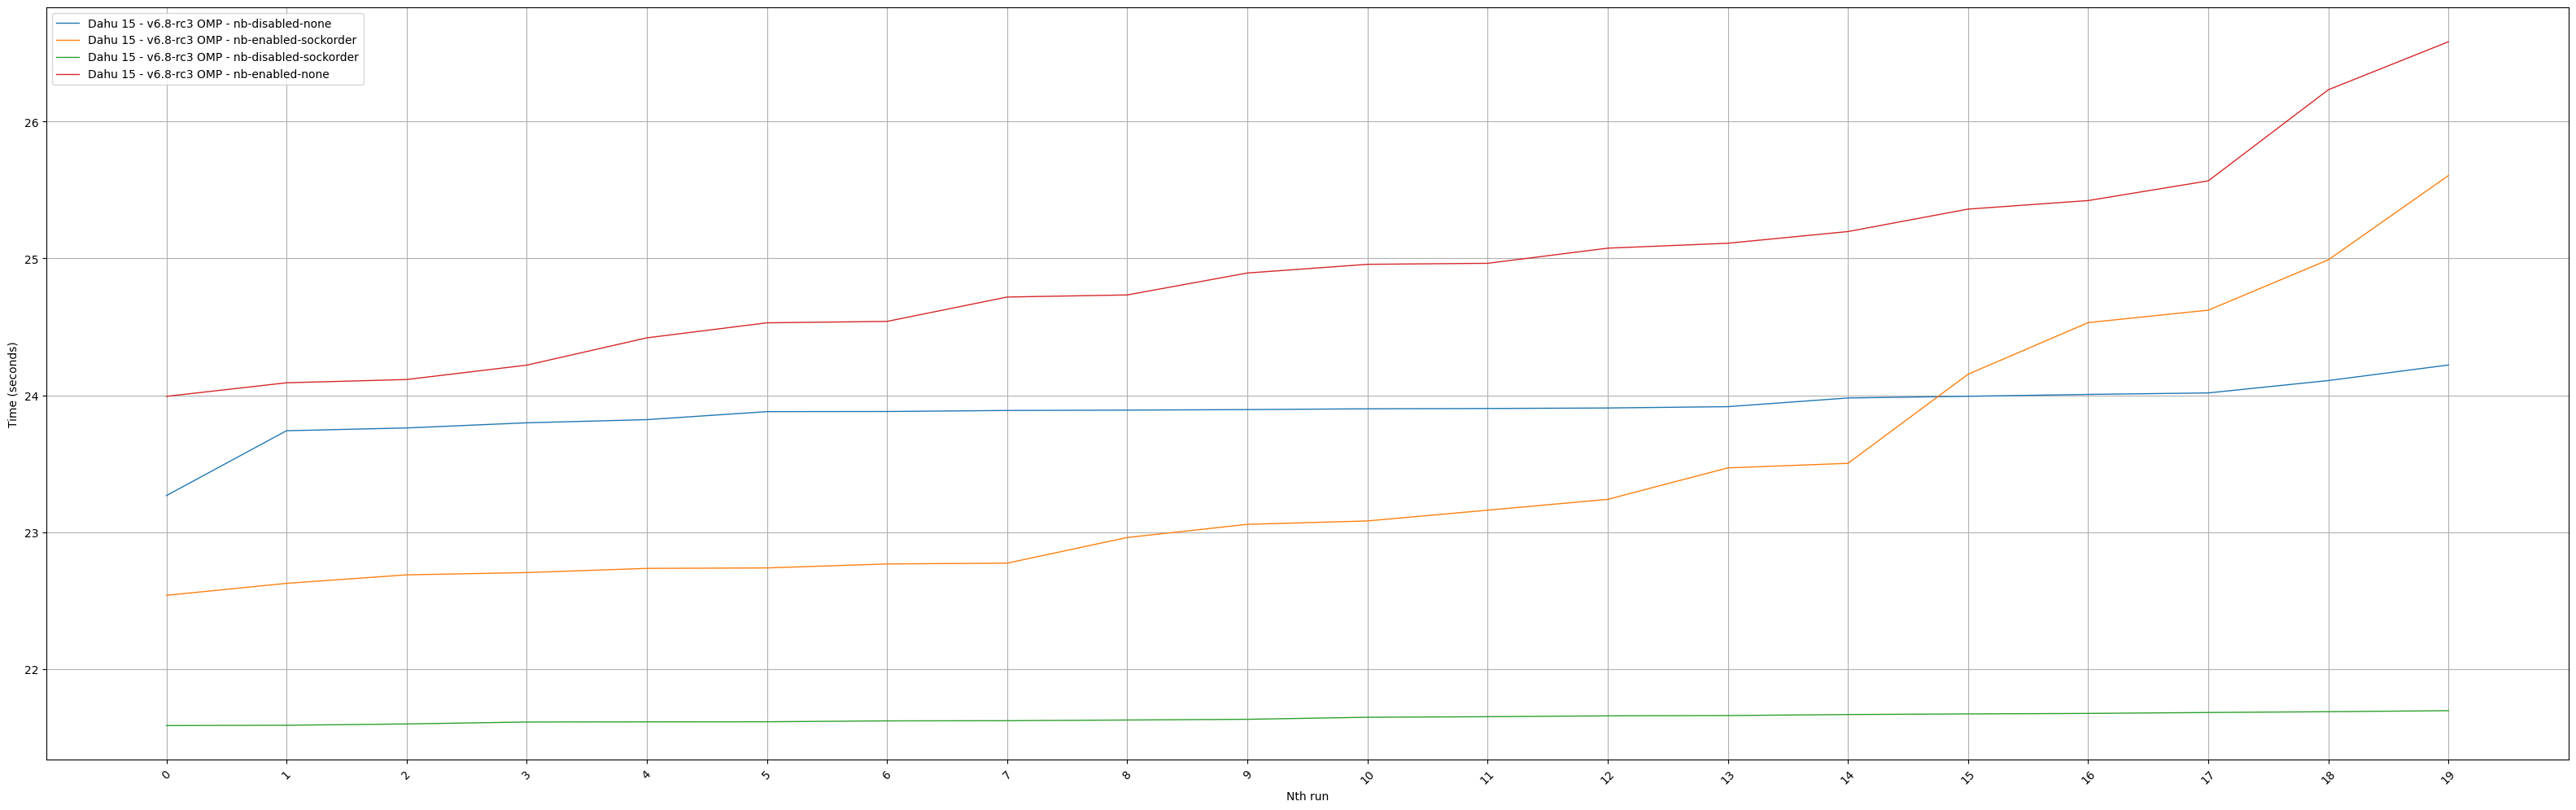

lu.C on dahu 15 minus broken wc time
df columns :  Index(['filename', 'duration', 'broken_wc_time'], dtype='object')
df columns :  Index(['filename', 'duration', 'broken_wc_time'], dtype='object')
df columns :  Index(['filename', 'duration', 'broken_wc_time'], dtype='object')
df columns :  Index(['filename', 'duration', 'broken_wc_time'], dtype='object')
df columns :  Index(['filename', 'duration', 'broken_wc_time'], dtype='object')
df columns :  Index(['filename', 'duration', 'broken_wc_time'], dtype='object')
df columns :  Index(['filename', 'duration', 'broken_wc_time'], dtype='object')
df columns :  Index(['filename', 'duration', 'broken_wc_time'], dtype='object')


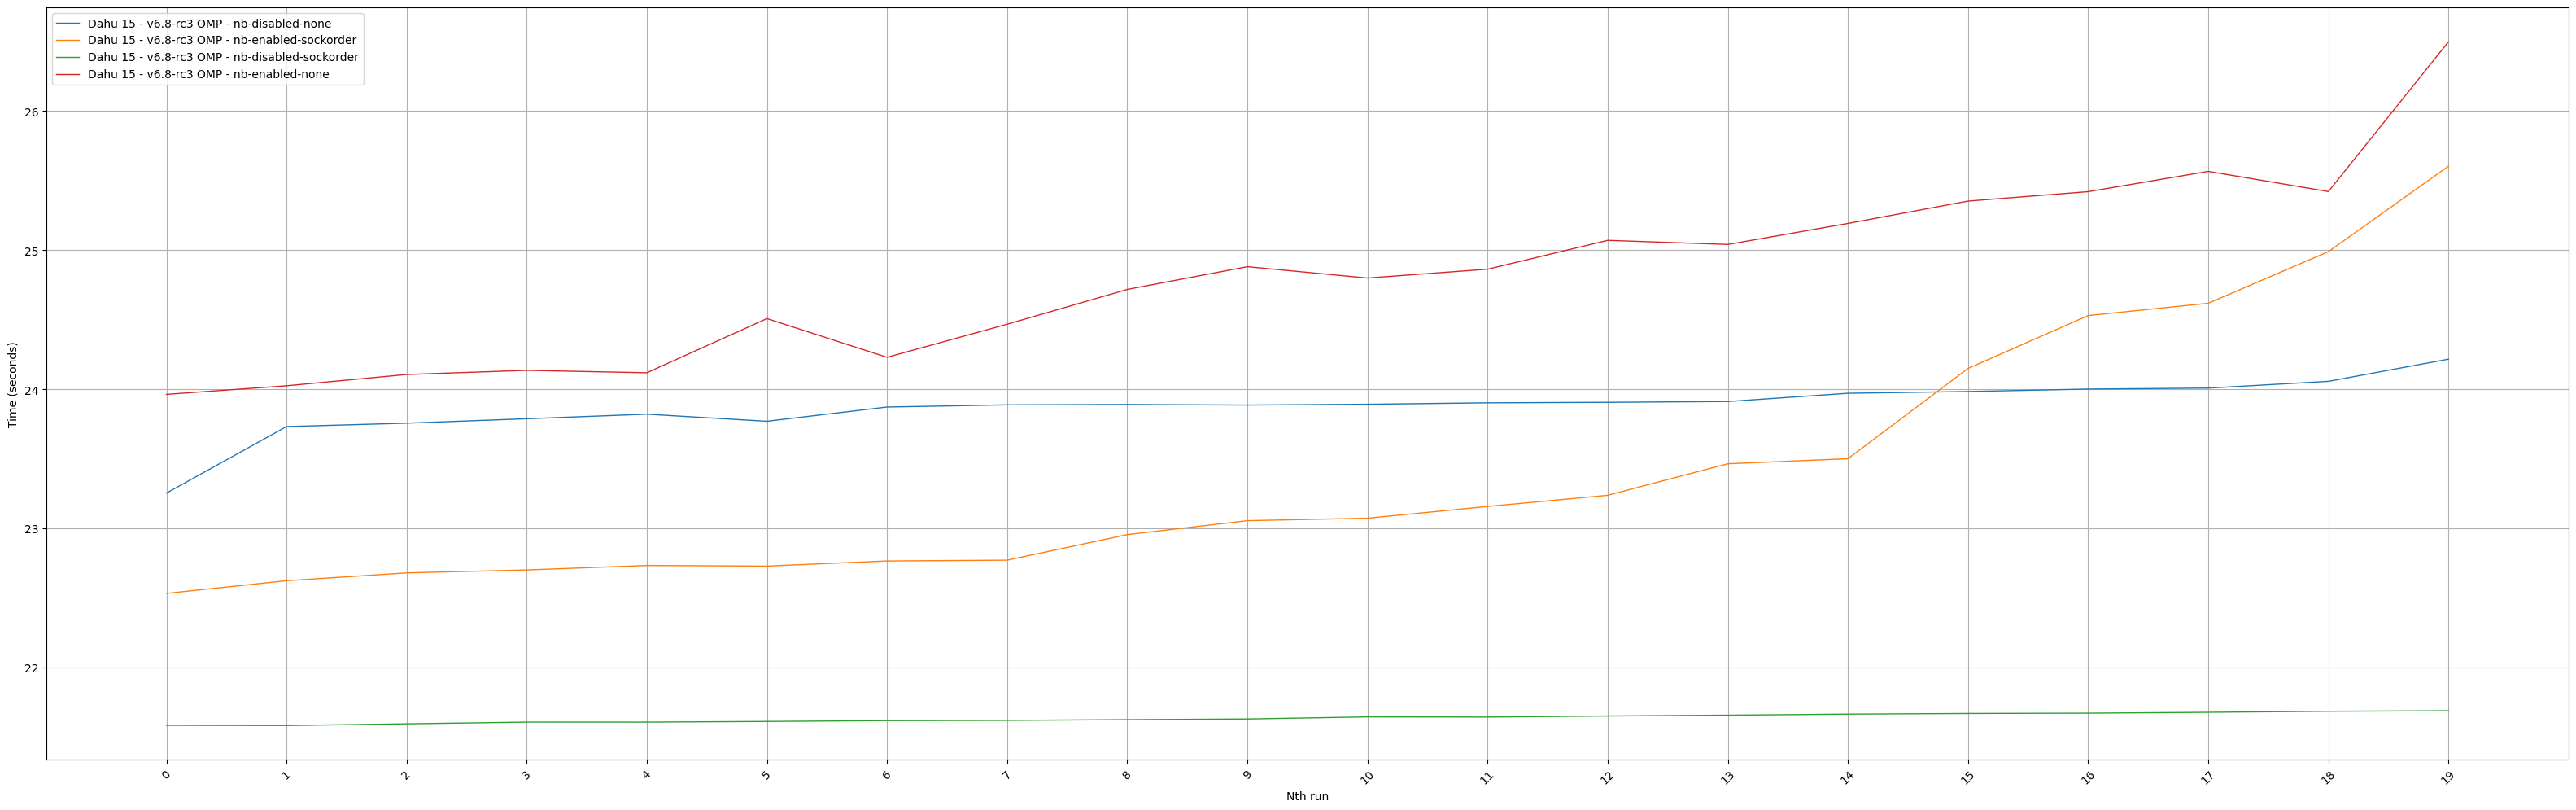

In [19]:
sort_by='duration'
# sort_by='run_index'
# show_run_index = True
show_run_index = False
figure_height = DEFAULT_FIGURE_HEIGHT

### LU.B on dahu doesn't show a significant difference between enabled none and disabled none
# init_runs_plot()
# print("lu.B on dahu 15")
# plot_trace_cmd_benchmark_dir("lu.B.x__dahu-15__v6.8.0-rc3__performance__2024-03-09", "Dahu 15 - v6.8-rc3 OMP -", show_run_index=show_run_index, sort_by=sort_by, folder_name_filters=["none", "sockorder"])
# plt.show()

### LU.B on yeti doesn't show a significant difference between enabled none and disabled none
# init_runs_plot()
# print("lu.B on yeti 3")
# plot_trace_cmd_benchmark_dir("lu.B.x__yeti-3__v6.8.0-rc3__performance__2024-03-11", "Yeti 3 - v6.8-rc3 OMP -", show_run_index=show_run_index, sort_by=sort_by)
# plt.show()

print("lu.C on dahu 15")
vp = Plotter()
vp.add_trace_cmd_directory("_trace-cmd/lu.C.x__dahu-15__v6.8.0-rc3__performance__2024-03-09", "Dahu 15 - v6.8-rc3 OMP -", sort_by=sort_by, data = DataType.DURATION)
vp.show_times(name_filters = ["none", "sockorder"], show_labels=show_run_index)

print("lu.C on dahu 15 minus broken wc time")
vp = Plotter()
vp.add_trace_cmd_directory("_trace-cmd/lu.C.x__dahu-15__v6.8.0-rc3__performance__2024-03-09", "Dahu 15 - v6.8-rc3 OMP -", sort_by=sort_by, data = DataType.DURATION_ADJUSTED_FOR_WC)
vp.show_times(name_filters = ["none", "sockorder"], show_labels=show_run_index)


# print("lu.C on yeti 1")
# vp = Plotter()
# vp.add_trace_cmd_directory("_trace-cmd/lu.C.x__yeti-1__v6.8.0-rc3__performance__2024-03-11", "Yeti 1 - v6.8-rc3 OMP -", sort_by=sort_by)
# vp.show(name_filters = ["none", "sockorder"], show_labels=show_run_index)

### MG

mg.D on dahu 15
Reference value :  55.70267600000079


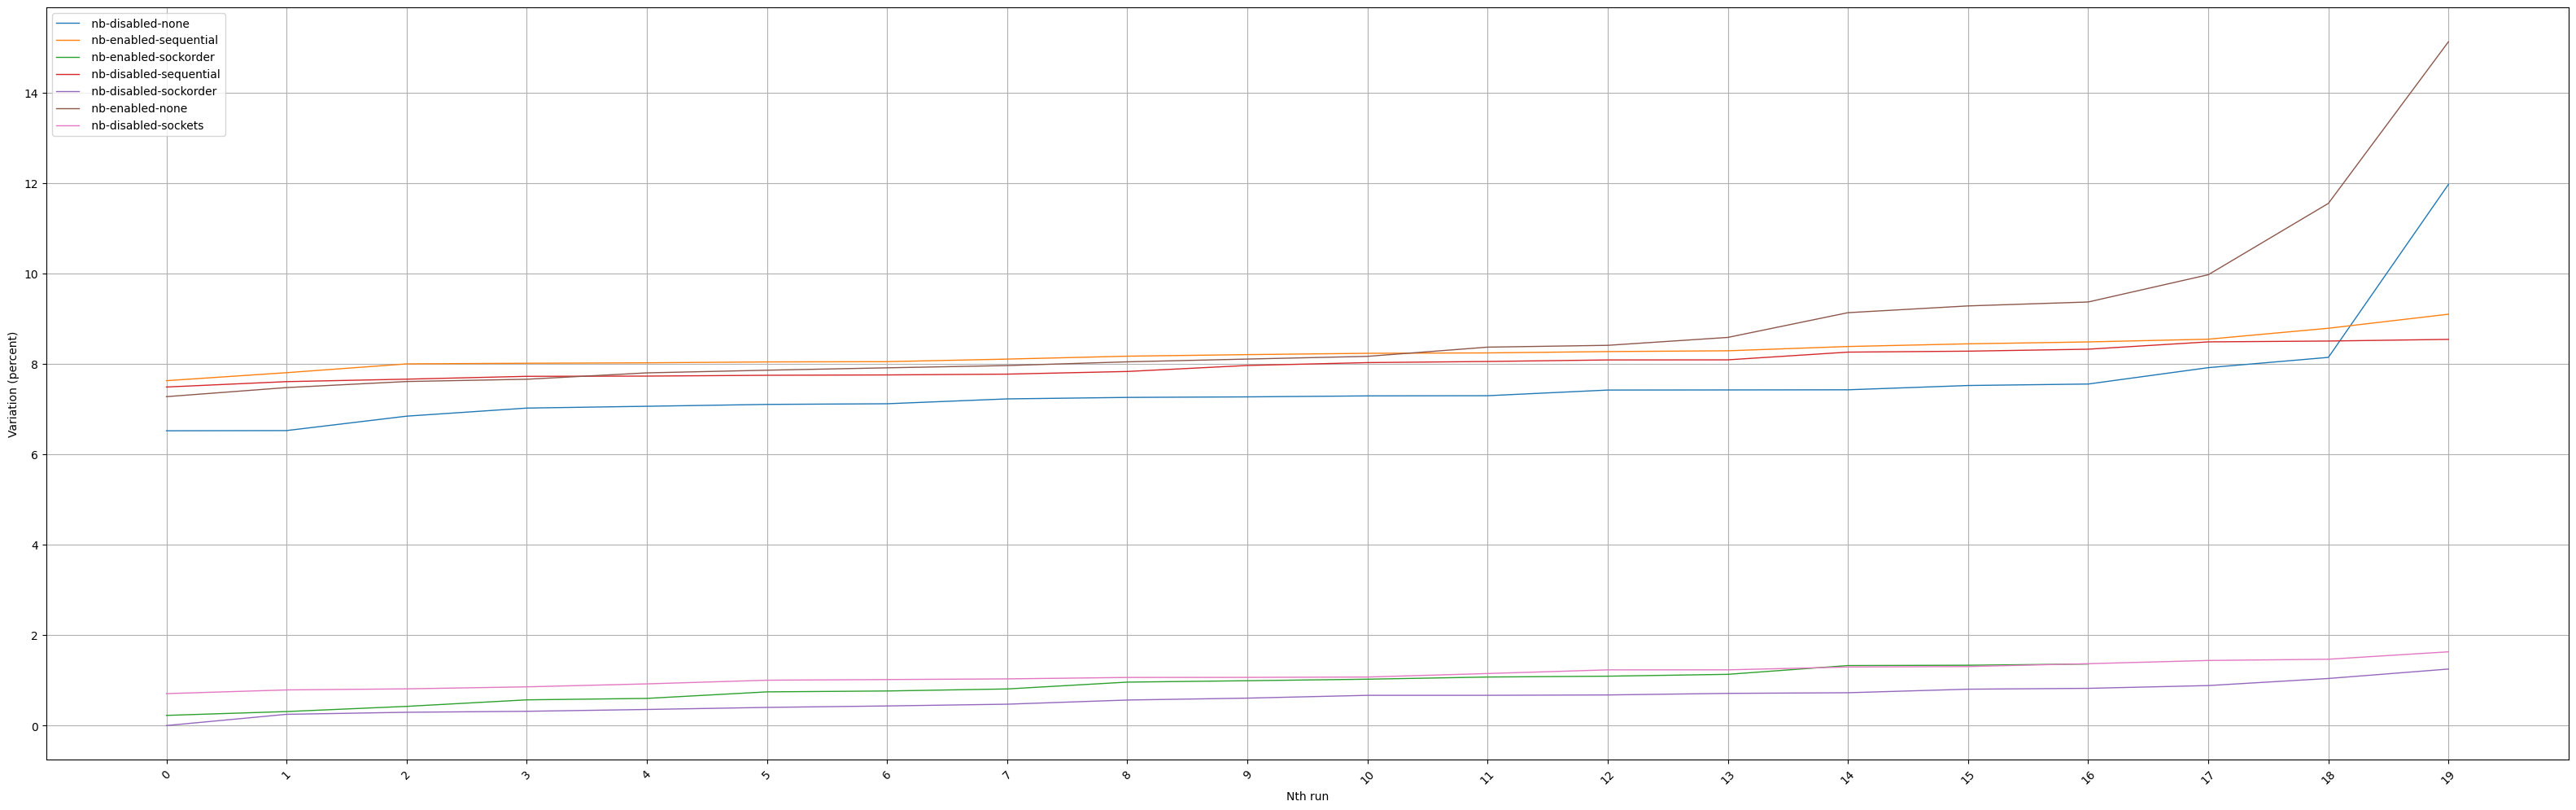

In [23]:
sort_by='duration'
# sort_by='run_index'
# show_run_index = True
show_run_index = False

print("mg.D on dahu 15")
vp = Plotter()
vp.add_trace_cmd_directory("_trace-cmd/mg.D.x__dahu-15__v6.8.0-rc3__performance__2024-03-09", sort_by=sort_by)
vp.show_variations(show_labels=show_run_index)


### SP

sp.B on dahu 13
Reference value :  5.088114000000132


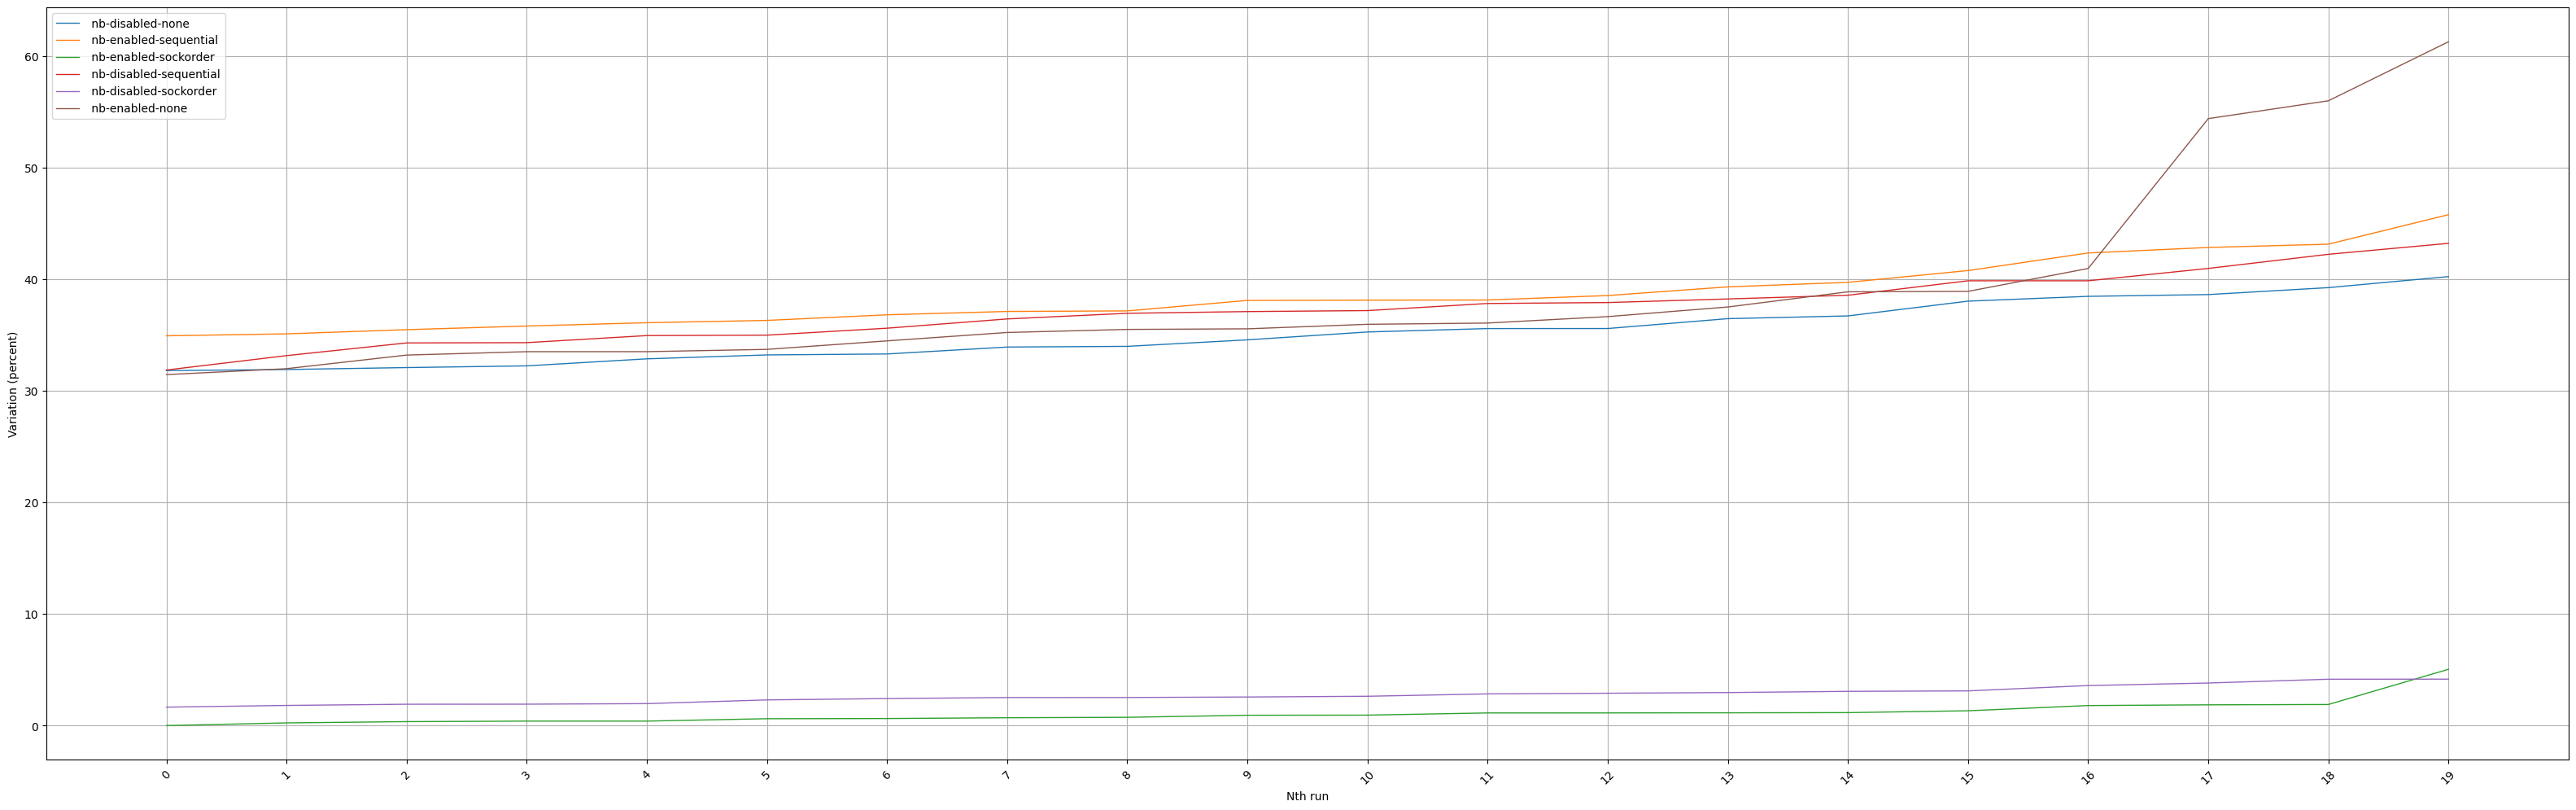

Reference value :  2.807619999999588


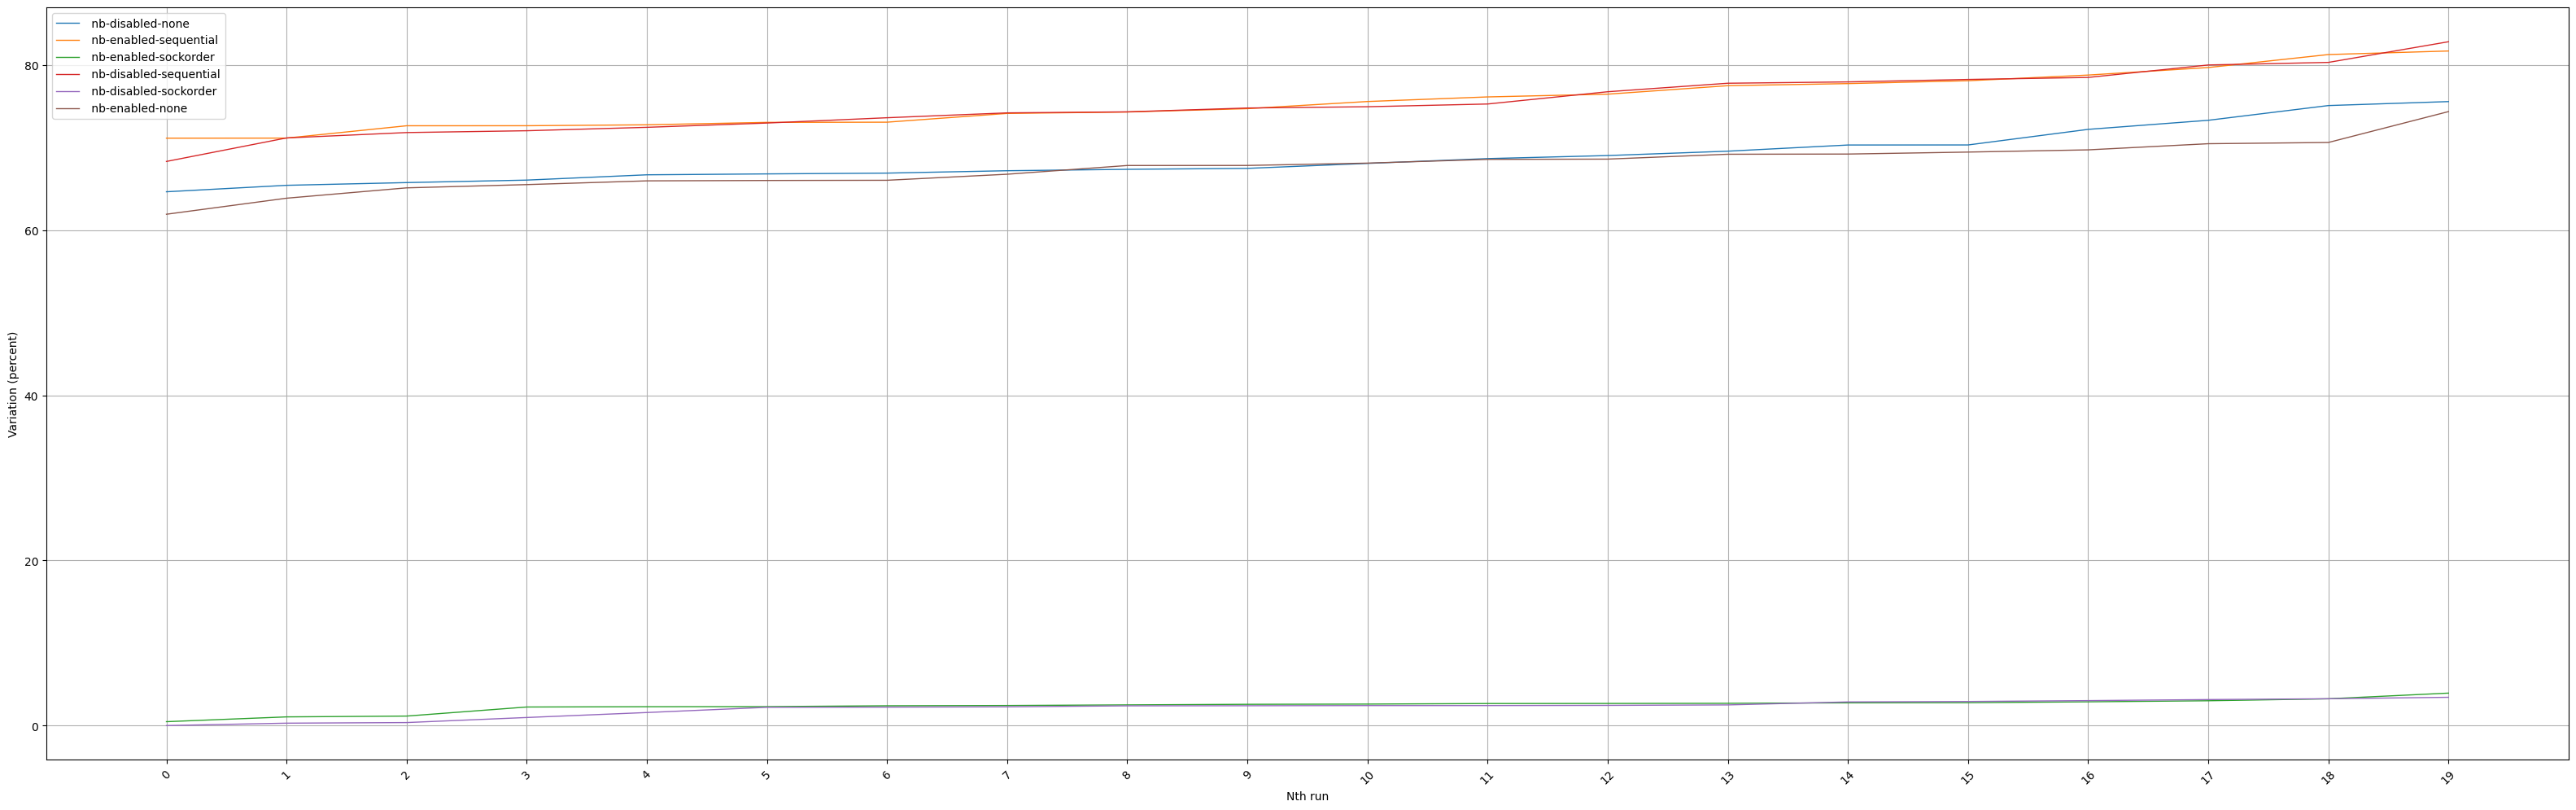

Reference value :  22.67954999999984


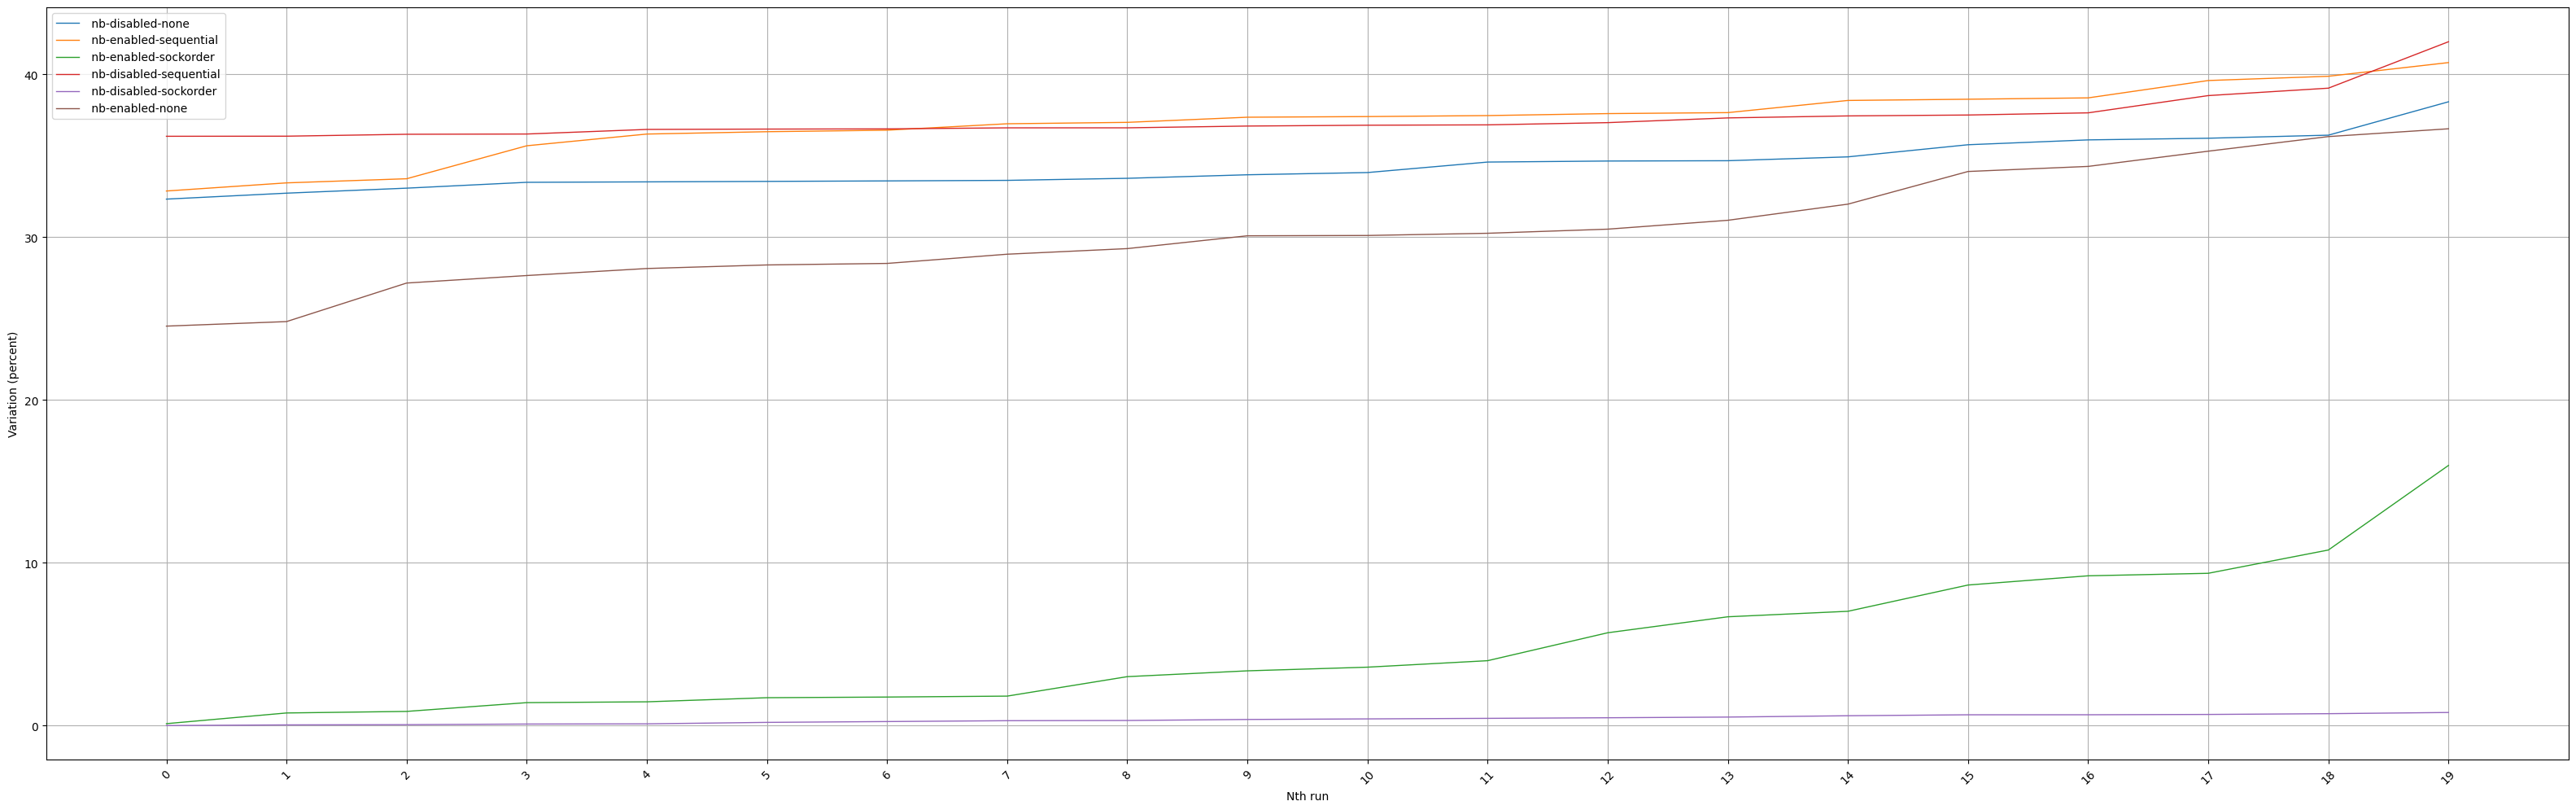

In [24]:
sort_by='duration'
# sort_by='run_index'
# show_run_index = True
show_run_index = False

print("sp.B on dahu 13")
vp = Plotter()
vp.add_trace_cmd_directory("_trace-cmd/sp.B.x__dahu-13__v6.8.0-rc3__performance__2024-03-09", sort_by=sort_by)
vp.show_variations(name_filters = ["none", "sockorder", "sequential"], show_labels=show_run_index)

vp = Plotter()
vp.add_trace_cmd_directory("_trace-cmd/sp.B.x__yeti-1__v6.8.0-rc3__performance__2024-03-11", sort_by=sort_by)
vp.show_variations(name_filters = ["none", "sockorder", "sequential"], show_labels=show_run_index)

vp = Plotter()
vp.add_trace_cmd_directory("_trace-cmd/sp.C.x__dahu-13__v6.8.0-rc3__performance__2024-03-09", sort_by=sort_by)
vp.show_variations(name_filters = ["none", "sockorder", "sequential"], show_labels=show_run_index)

# init_runs_plot()
# plot_trace_cmd_benchmark_dir("sp.B.x__dahu-13__v6.8.0-rc3__performance__2024-03-09", "Dahu 13 - v6.8-rc3 OMP -", show_run_index=show_run_index, sort_by=sort_by)
# plt.show()

# print("sp.B on yeti 1")
# init_runs_plot()
# plot_trace_cmd_benchmark_dir("sp.B.x__yeti-1__v6.8.0-rc3__performance__2024-03-11", "Yeti 1 - v6.8-rc3 OMP -", show_run_index=show_run_index, sort_by=sort_by)
# plt.show()

# print("sp.C on dahu 13")
# init_runs_plot()
# plot_trace_cmd_benchmark_dir("sp.C.x__dahu-13__v6.8.0-rc3__performance__2024-03-09", "Dahu 13 - v6.8-rc3 OMP -", show_run_index=show_run_index, sort_by=sort_by)
# plt.show()

### UA

ua.C on yeti 1
df columns :  Index(['filename', 'duration', 'broken_wc_time'], dtype='object')
df columns :  Index(['filename', 'duration', 'broken_wc_time'], dtype='object')
df columns :  Index(['filename', 'duration', 'broken_wc_time'], dtype='object')
df columns :  Index(['filename', 'duration', 'broken_wc_time'], dtype='object')
df columns :  Index(['filename', 'duration', 'broken_wc_time'], dtype='object')
df columns :  Index(['filename', 'duration', 'broken_wc_time'], dtype='object')
df columns :  Index(['filename', 'duration', 'broken_wc_time'], dtype='object')
df columns :  Index(['filename', 'duration', 'broken_wc_time'], dtype='object')
df columns :  Index(['filename', 'duration', 'broken_wc_time'], dtype='object')
df columns :  Index(['filename', 'duration', 'broken_wc_time'], dtype='object')
df columns :  Index(['filename', 'duration', 'broken_wc_time'], dtype='object')
df columns :  Index(['filename', 'duration', 'broken_wc_time'], dtype='object')
df columns :  Index(['fil

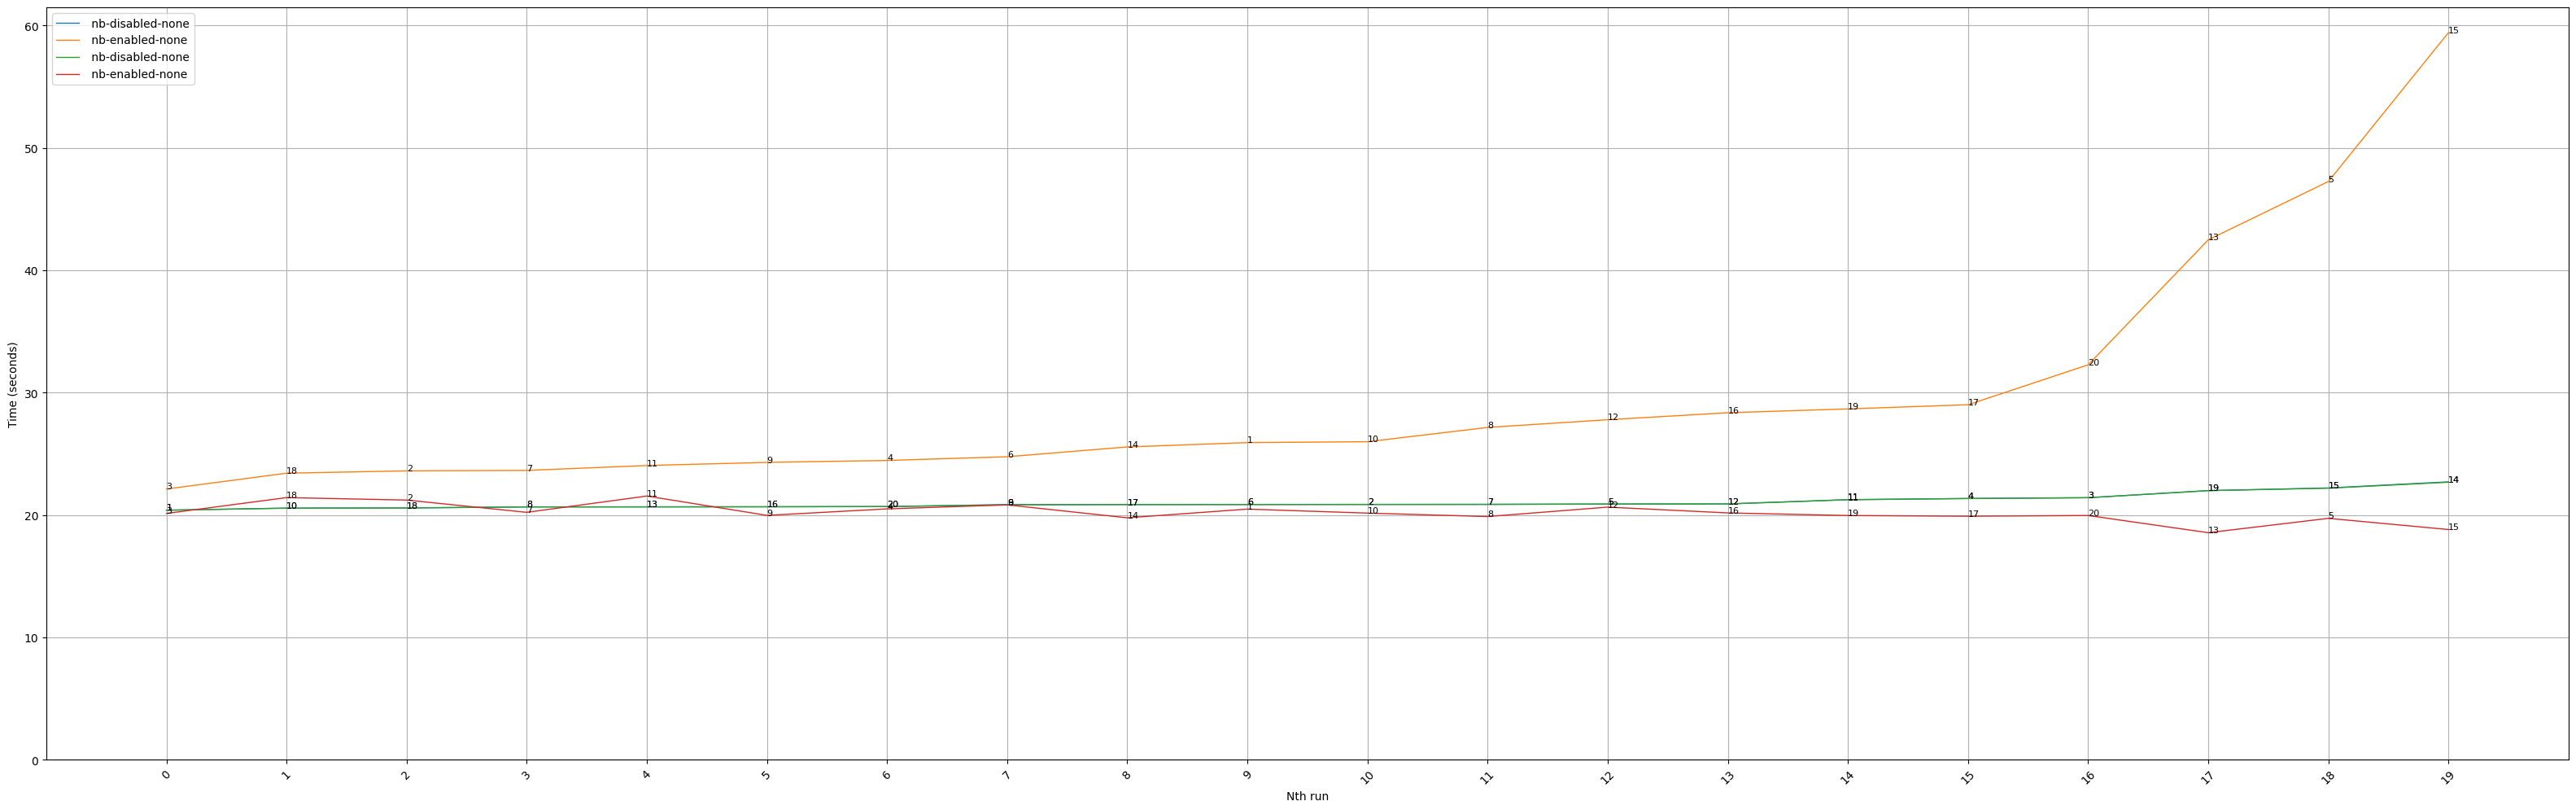

In [24]:
sort_by='duration'
# sort_by='run_index'
show_run_index = True
# show_run_index = False


# # plot_trace_cmd_benchmark_dir("ua.C.x__dahu-13__v6.8.0-rc3__performance__2024-03-09", "Dahu 13 - v6.8-rc3 OMP -", show_run_index=show_run_index, sort_by=sort_by)
# plot_trace_cmd_runs(get_result_dir_path("ua.C.x__dahu-13__v6.8.0-rc3__performance__2024-03-09/nb-disabled-none"), "NUMA balancing disabled", show_run_index=show_run_index, sort_by=sort_by)
# plot_trace_cmd_runs(get_result_dir_path("ua.C.x__dahu-13__v6.8.0-rc3__performance__2024-03-09/nb-enabled-none"), "NUMA balancing enabled", show_run_index=show_run_index, sort_by=sort_by)

# print("ua.C on dahu 13")
# vp = Plotter()
# vp.add_trace_cmd_directory("_trace-cmd/ua.C.x__dahu-13__v6.8.0-rc3__performance__2024-03-09", sort_by=sort_by)
# vp.show_variations(name_filters = ["none", "sockorder", "sequential"], show_labels=show_run_index)

print("ua.C on yeti 1")
vp = Plotter()
vp.add_trace_cmd_directory("_trace-cmd/ua.C.x__yeti-1__v6.8.0-rc3__performance__2024-03-11", sort_by=sort_by)
vp.add_trace_cmd_directory("_trace-cmd/ua.C.x__yeti-1__v6.8.0-rc3__performance__2024-03-11", sort_by=sort_by, data = DataType.DURATION_ADJUSTED_FOR_WC)

vp.show_times(name_filters = ["none"], show_labels=show_run_index)

# print("ua.C on yeti 1 minus broken wc time")
# vp.reset()
# vp.add_trace_cmd_directory("_trace-cmd/ua.C.x__yeti-1__v6.8.0-rc3__performance__2024-03-11", sort_by=sort_by, data = DataType.DURATION_ADJUSTED_FOR_WC)
# vp.show_times(name_filters = ["none"], show_labels=show_run_index)




# init_runs_plot()
# plot_trace_cmd_benchmark_dir("ua.C.x__yeti-1__v6.8.0-rc3__performance__2024-03-11", "Yeti 1 - v6.8-rc3 OMP -", show_run_index=show_run_index, sort_by=sort_by)

### Multiapp - BT and CG

bt.B and cg.C on dahu 9


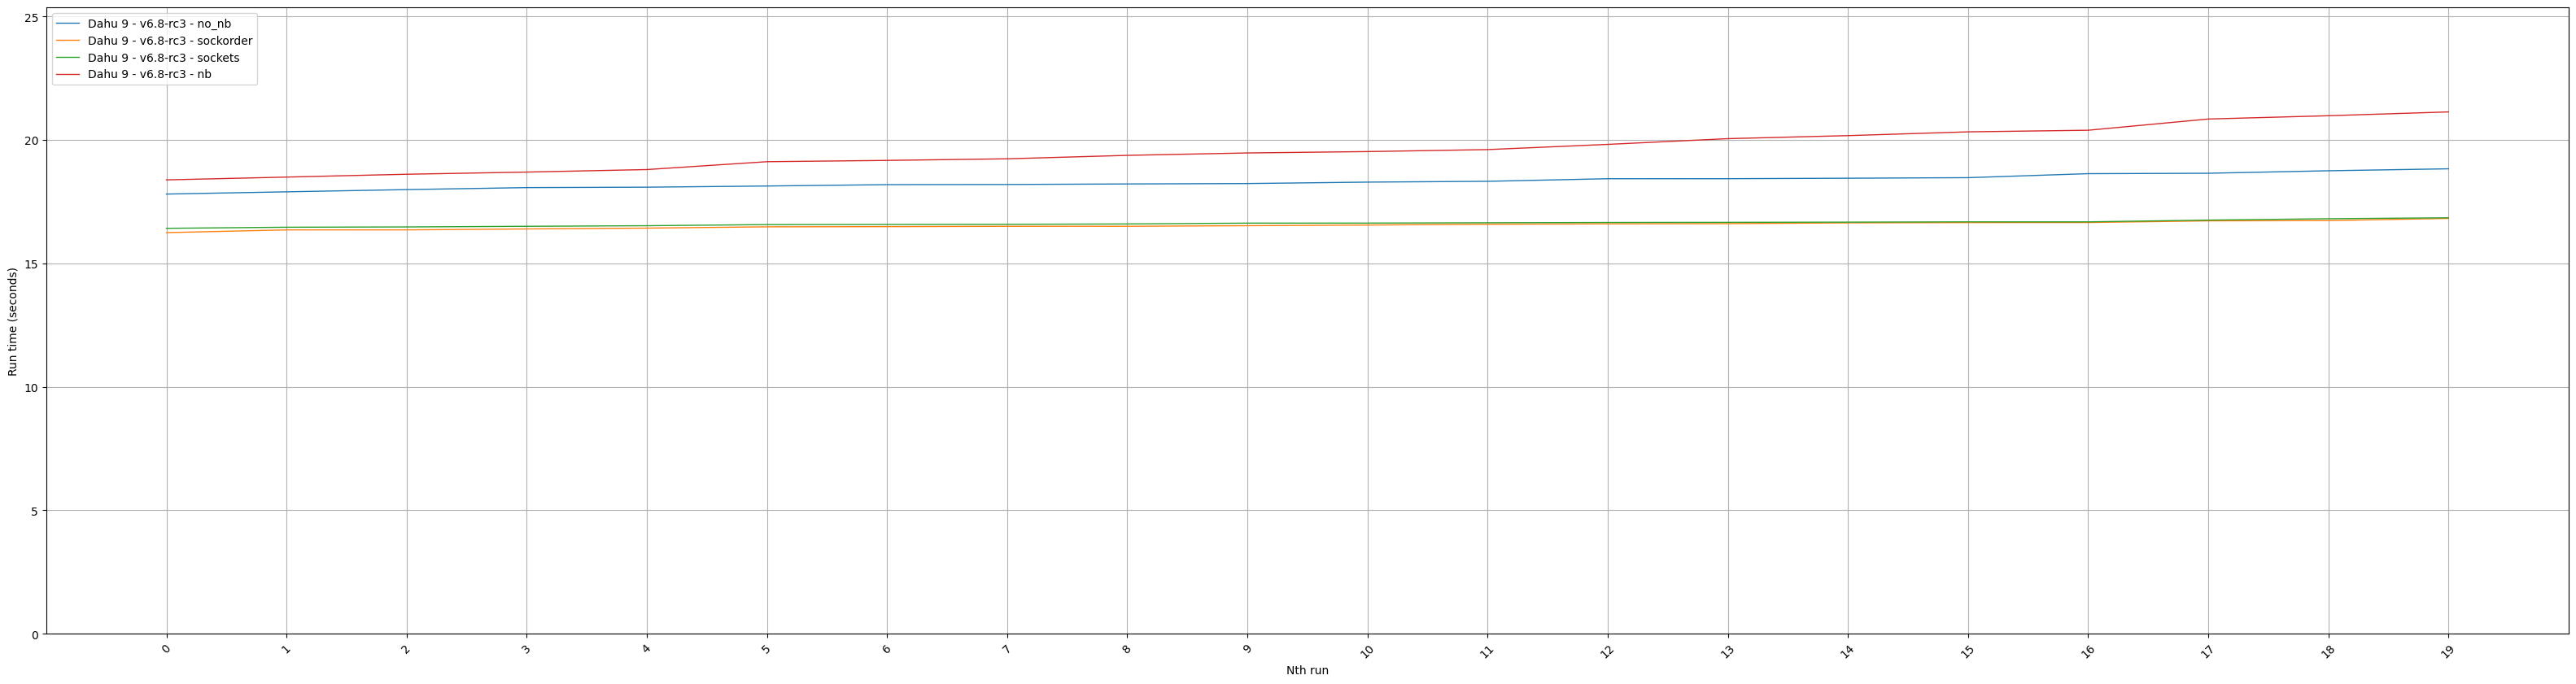

In [167]:
sort_by='duration'
# sort_by='run_index'
# show_run_index = True
show_run_index = False

print("bt.B and cg.C on dahu 9")
init_runs_plot()
plot_trace_cmd_benchmark_dir("bt.B.x-and-cg.C.x__dahu-9__v6.8.0-rc3__performance__2024-03-11", "Dahu 9 - v6.8-rc3 -", show_run_index=show_run_index, sort_by=sort_by)
plt.show()

# NUMA balancing comparison for EEVDF

### BT

bt.B dahu


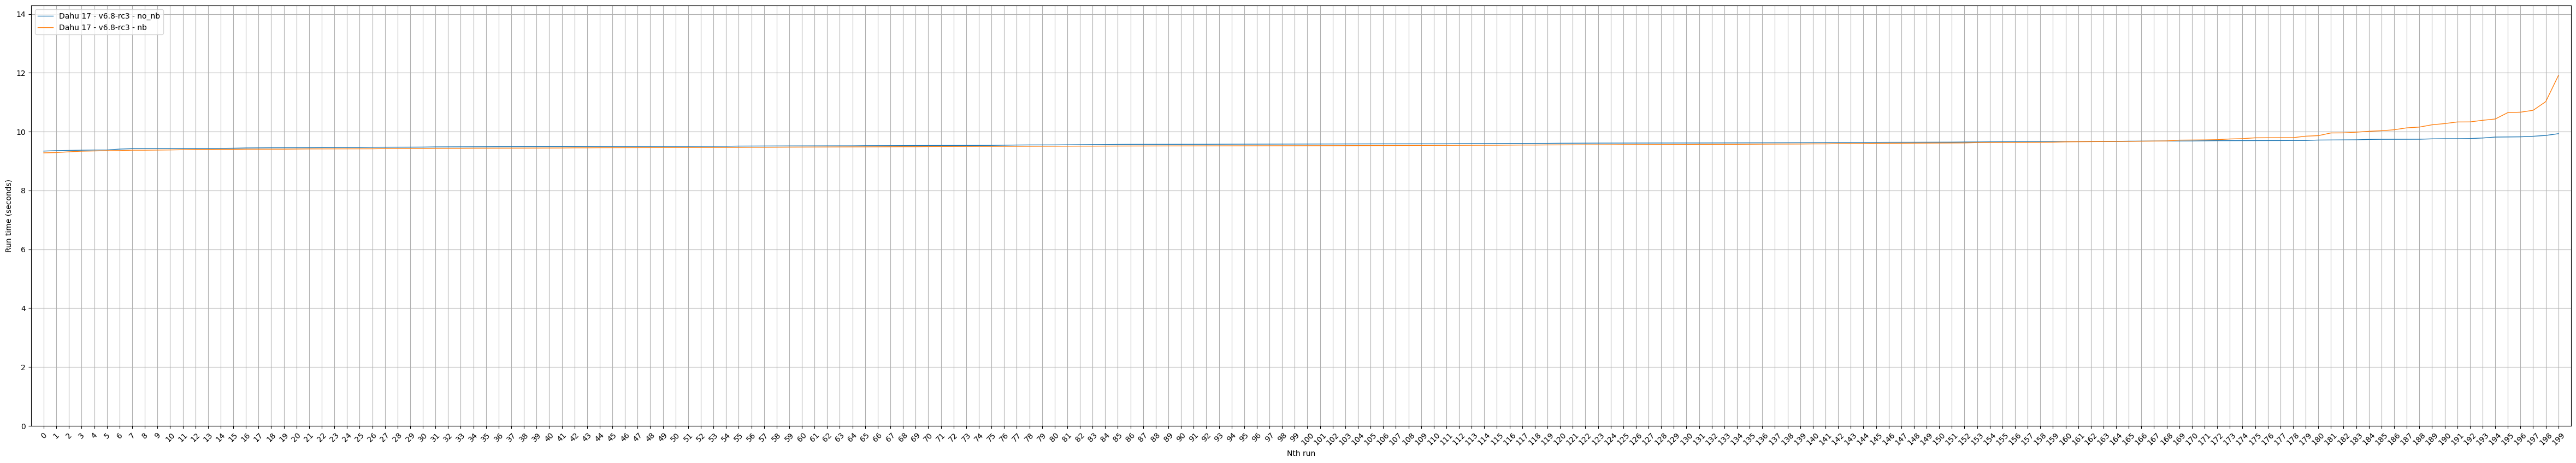

bt.C dahu


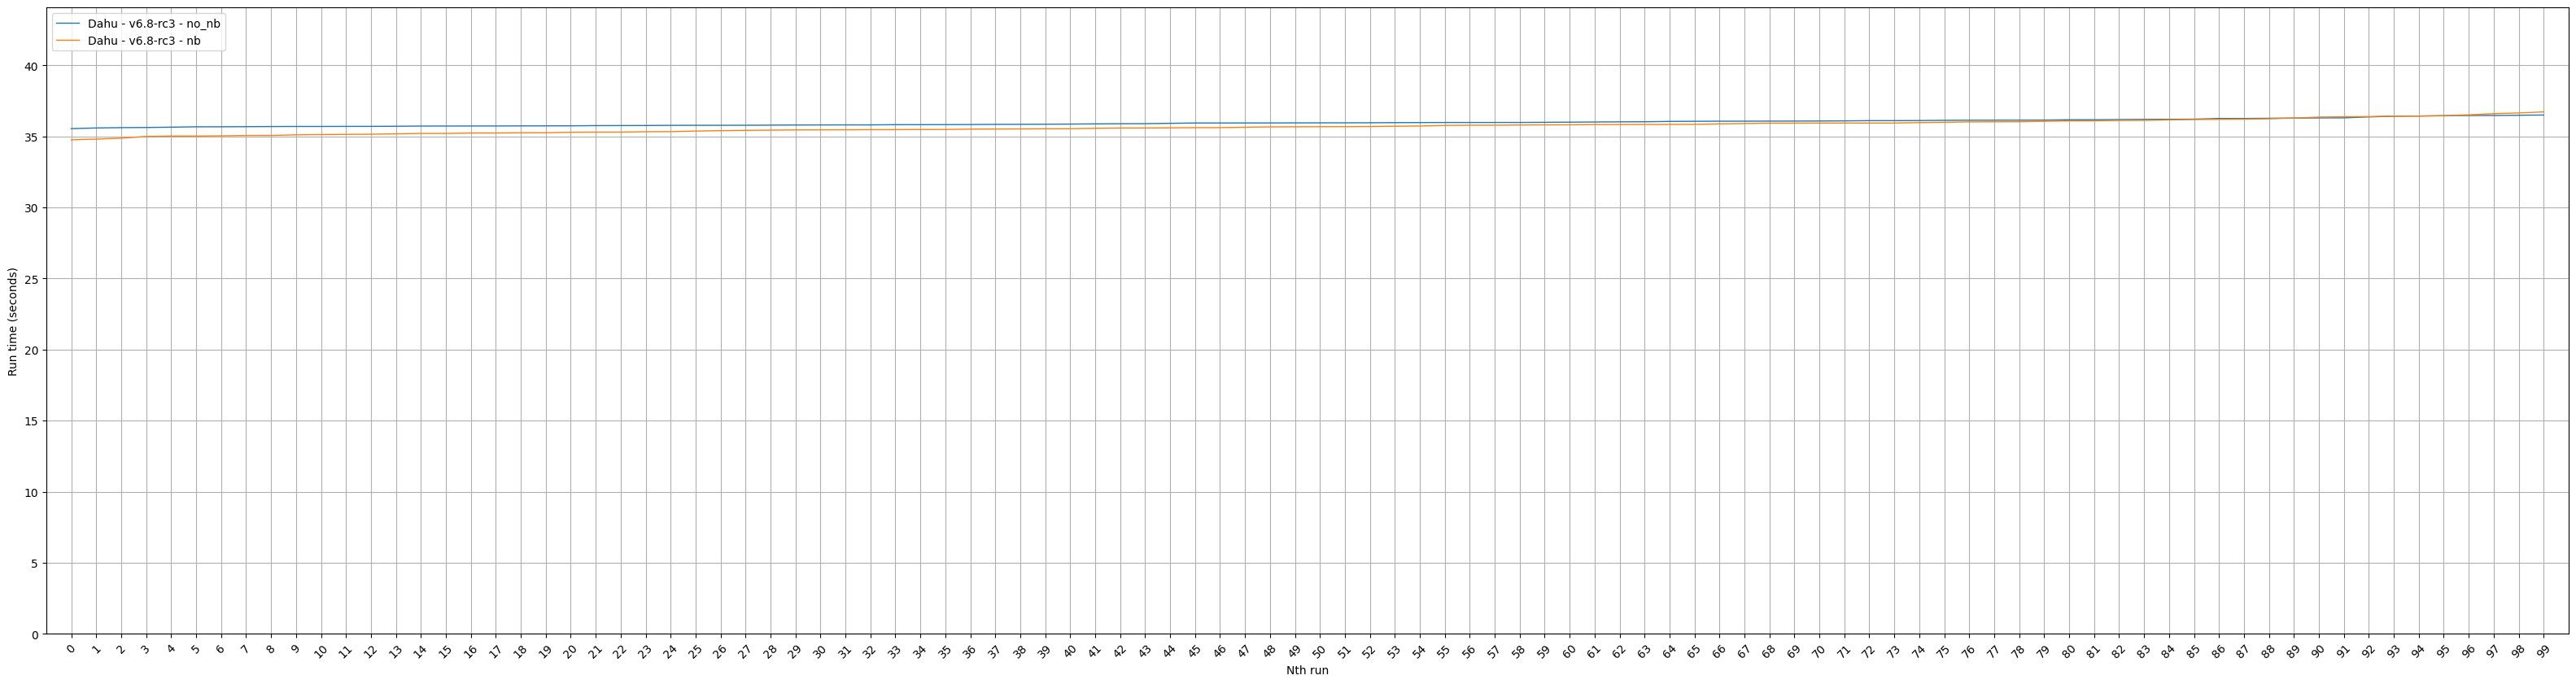

In [189]:
sort_by='duration'
# sort_by='run_index'
# show_run_index = True
show_run_index = False

init_runs_plot()
print("bt.B dahu")
# plot_trace_cmd_benchmark_dir("bt.B.29-02.dahu-2.v6.1.0-17", "Dahu 2 - v6.1.0-17 -", show_run_index=show_run_index, sort_by=sort_by)
plot_trace_cmd_benchmark_dir("bt.B.dahu-17.v6.8-rc3", "Dahu 17 - v6.8-rc3 -", show_run_index=show_run_index, sort_by=sort_by)
# plot_trace_cmd_benchmark_dir("bt.B.x__dahu-6__v6.8.0-rc6+__2024-03-05", "Dahu 6 - v6.8-rc6 prints -", show_run_index=show_run_index, sort_by=sort_by)

# get_result_dir_path(benchmark_dir_name)
# plot_trace_cmd_runs(get_result_dir_path("bt.B.x__dahu-6__v6.8.0-rc6+__2024-03-05/nb-scan-only"), "Scan only", show_run_index=show_run_index, sort_by=sort_by)
plt.show()

init_runs_plot()
print("bt.C dahu")
# plot_trace_cmd_benchmark_dir("bt.C.dahu.v6.1.0-17", "Dahu - v6.1.0-17 -", show_run_index=show_run_index, sort_by=sort_by)
plot_trace_cmd_benchmark_dir("bt.C.dahu-28.v6.8-rc3", "Dahu - v6.8-rc3 -", show_run_index=show_run_index, sort_by=sort_by)
plt.show()

# init_runs_plot()
# print("bt.C yeti")
# plot_trace_cmd_benchmark_dir("bt.C.yeti.v6.1.0-17", "Yeti - v6.1.0-17 -", show_run_index=show_run_index, sort_by=sort_by)
# plt.show()

### LU

lu.C on dahu-18
Include broken wc :  False
Include broken wc :  False


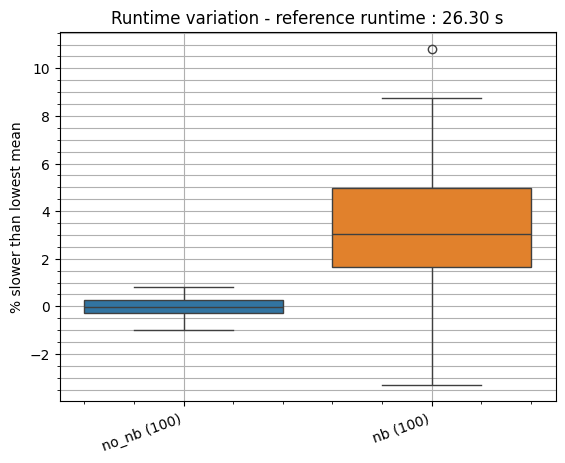

lu.C on yeti-1
Include broken wc :  False
Include broken wc :  False
Include broken wc :  False
Include broken wc :  False


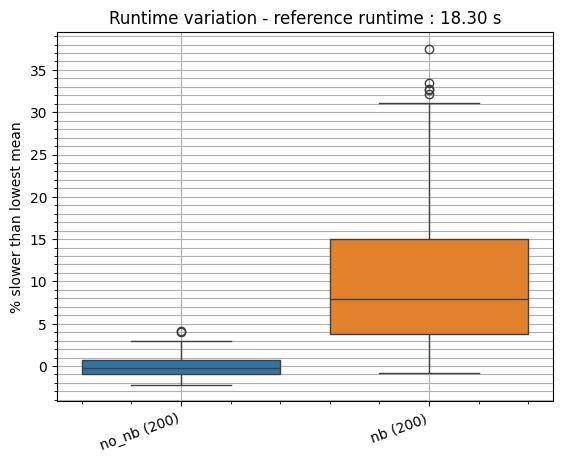

In [29]:
sort_by='duration'
# sort_by='run_index'
show_run_index = True
# init_runs_plot()
# print("lu.C yeti")
# # plot_trace_cmd_benchmark_dir("lu.C.yeti-4.v6.8-rc3", "Yeti 4 - v6.8-rc3 -", show_run_index=show_run_index, sort_by=sort_by)
# plot_trace_cmd_benchmark_dir("lu.C.29-02.yeti-1.v6.8-rc6+", "Yeti 1 - v6.8-rc6+ toggles -", show_run_index=show_run_index, sort_by=sort_by)
# # plot_trace_cmd_benchmark_dir("lu.C.x__yeti-1__v6.8.0-rc3__2024-03-06", "Yeti 1 - v6.8-rc3 OMP -", show_run_index=show_run_index, sort_by=sort_by)
# plt.show()

# init_runs_plot()
# print("lu.C dahu")
# plot_trace_cmd_benchmark_dir("lu.C.dahu-18.v6.8-rc3", "Dahu 18 - v6.8-rc3 -", show_run_index=show_run_index, sort_by=sort_by)
# plt.show()

print("lu.C on dahu-18")
bp = BoxPlotter()
bp.add_trace_cmd_directory("lu.C.dahu-18.v6.8-rc3")
bp.show_variations()


print("lu.C on yeti-1")
bp = BoxPlotter()
bp.add_trace_cmd_directory("lu.C.29-02.yeti-1.v6.8-rc6+")
bp.show_variations(exact_filters=["no_nb", "nb"])



### UA

ua.C yeti


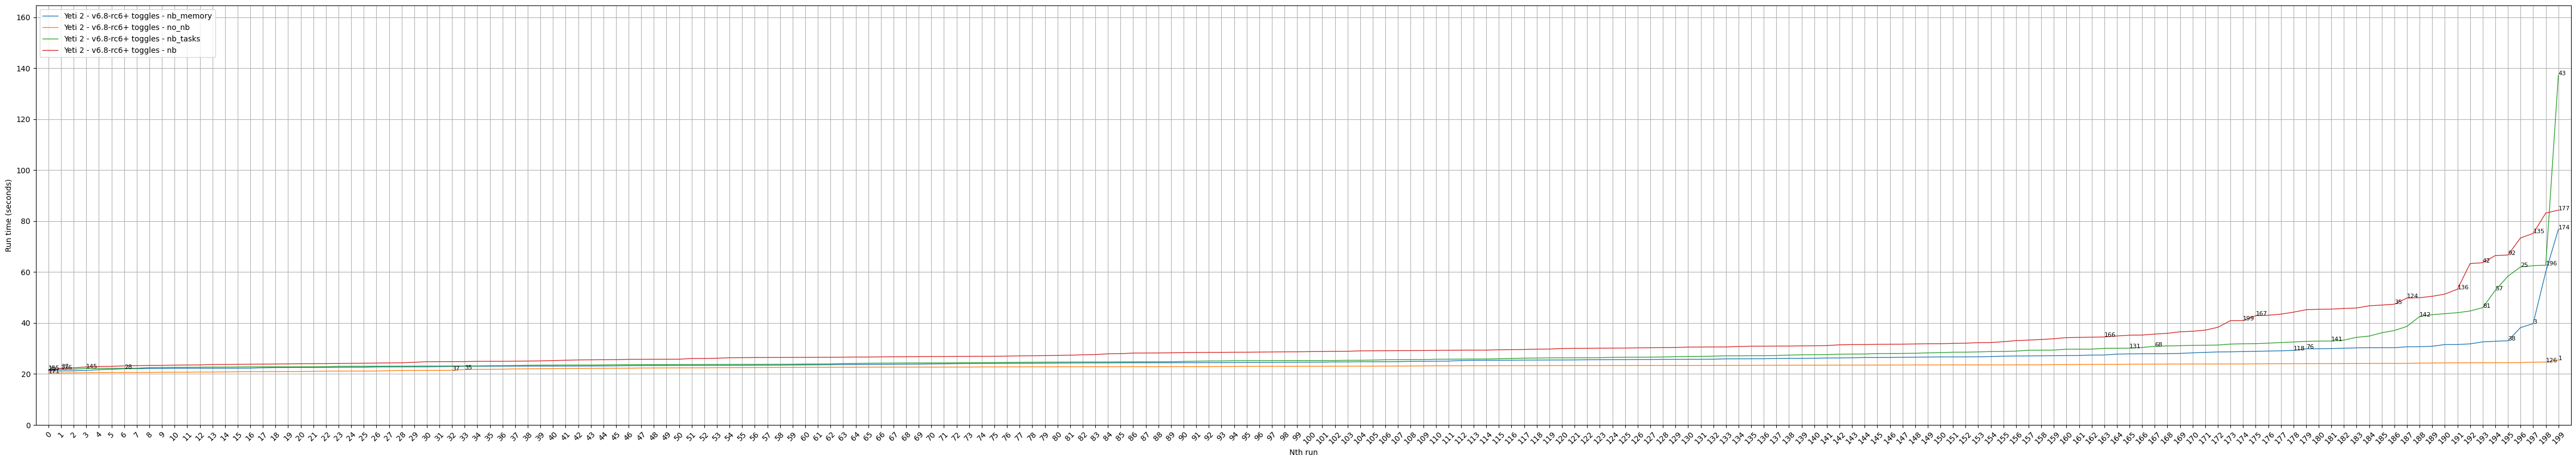

In [184]:
sort_by='duration'
# sort_by='run_index'
init_runs_plot()
print("ua.C yeti")
show_run_index = True
# plot_trace_cmd_benchmark_dir("ua.C.01-03.yeti-2.v6.1.0", "Yeti 2 - v6.1.0 stock -", show_run_index=show_run_index, sort_by=sort_by)
plot_trace_cmd_benchmark_dir("ua.C.29-02.yeti-2.v6.8-rc6+", "Yeti 2 - v6.8-rc6+ toggles -", show_run_index=show_run_index, sort_by=sort_by)
# plot_trace_cmd_benchmark_dir("ua.C.x__yeti-1__v6.8.0-rc3__2024-03-06", "Yeti 1 - v6.8-rc3 OMP -", show_run_index=show_run_index, sort_by=sort_by)
# plot_trace_cmd_benchmark_dir("ua.C.x__yeti-3__v6.8.0-rc3__performance__2024-03-08", "Yeti 3 - v6.8-rc3 OMP -", show_run_index=show_run_index, sort_by=sort_by)
plt.show()

# init_runs_plot()
# print("ua.C dahu")
# plot_trace_cmd_benchmark_dir("ua.C.dahu-30.v6.1.0-17", "Dahu 30 - v6.1.0-17 -", show_run_index=show_run_index, sort_by=sort_by)
# plt.show()

#### ft.C - Yeti & Dahu

ft.C on yeti


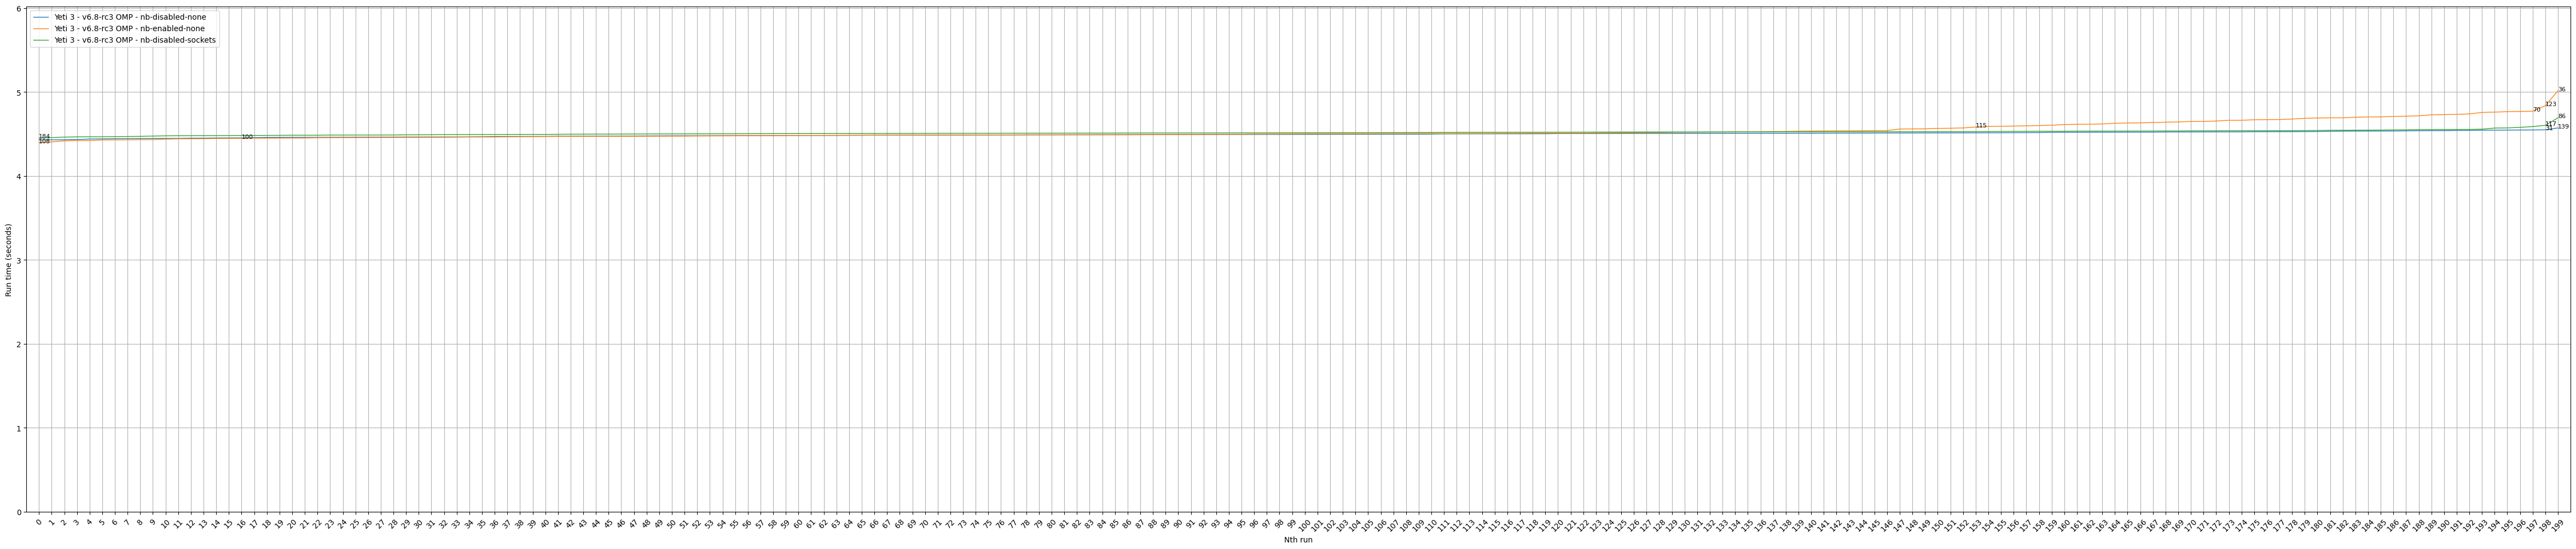

ft.C on dahu-7
Available time series names : ['nb-enabled', 'nb-disabled']


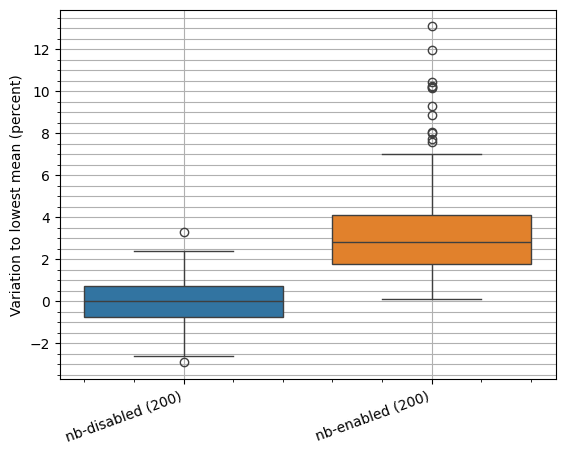

In [41]:
sort_by='duration'
# sort_by='run_index'
show_run_index = True
# show_run_index = False


print("ft.C on yeti")
init_runs_plot()
# plot_trace_cmd_benchmark_dir("ft.C.01-03.yeti-2.v6.1.0", "Yeti 2 - v6.1.0 stock -", show_run_index=show_run_index, sort_by=sort_by)
# plot_trace_cmd_benchmark_dir("ft.C.yeti-1.v6.1.0-17", "Yeti 1 - v6.1.0-17 -", show_run_index=show_run_index, sort_by=sort_by)
# plot_trace_cmd_benchmark_dir("ft.C.yeti-4.v6.8-rc3", "Yeti 4 - v6.8-rc3 -", show_run_index=show_run_index, sort_by=sort_by)
plot_trace_cmd_benchmark_dir("ft.C.x__yeti-2__v6.8.0-rc3__2024-03-06", "Yeti 3 - v6.8-rc3 OMP -", show_run_index=show_run_index, sort_by=sort_by)
plt.show()


print("ft.C on dahu-7")
bp = BoxPlotter()
bp.add_trace_cmd_directory("ft.C.x__dahu-7__v6.8.0-rc3__2024-03-04")
bp.print_filter_names()
bp.show_variations(name_filters=[])

# init_runs_plot()
# # plot_trace_cmd_benchmark_dir("ft.C.dahu.v6.1.0-17", "Dahu - v6.1.0-17 -", show_run_index=show_run_index, sort_by=sort_by)
# plot_trace_cmd_benchmark_dir("ft.C.x__dahu-7__v6.8.0-rc3__2024-03-04", "Dahu 7 - v6.8.0-rc3 -", show_run_index=show_run_index, sort_by=sort_by)
# plt.show()


#### mg.D - Yeti & Dahu

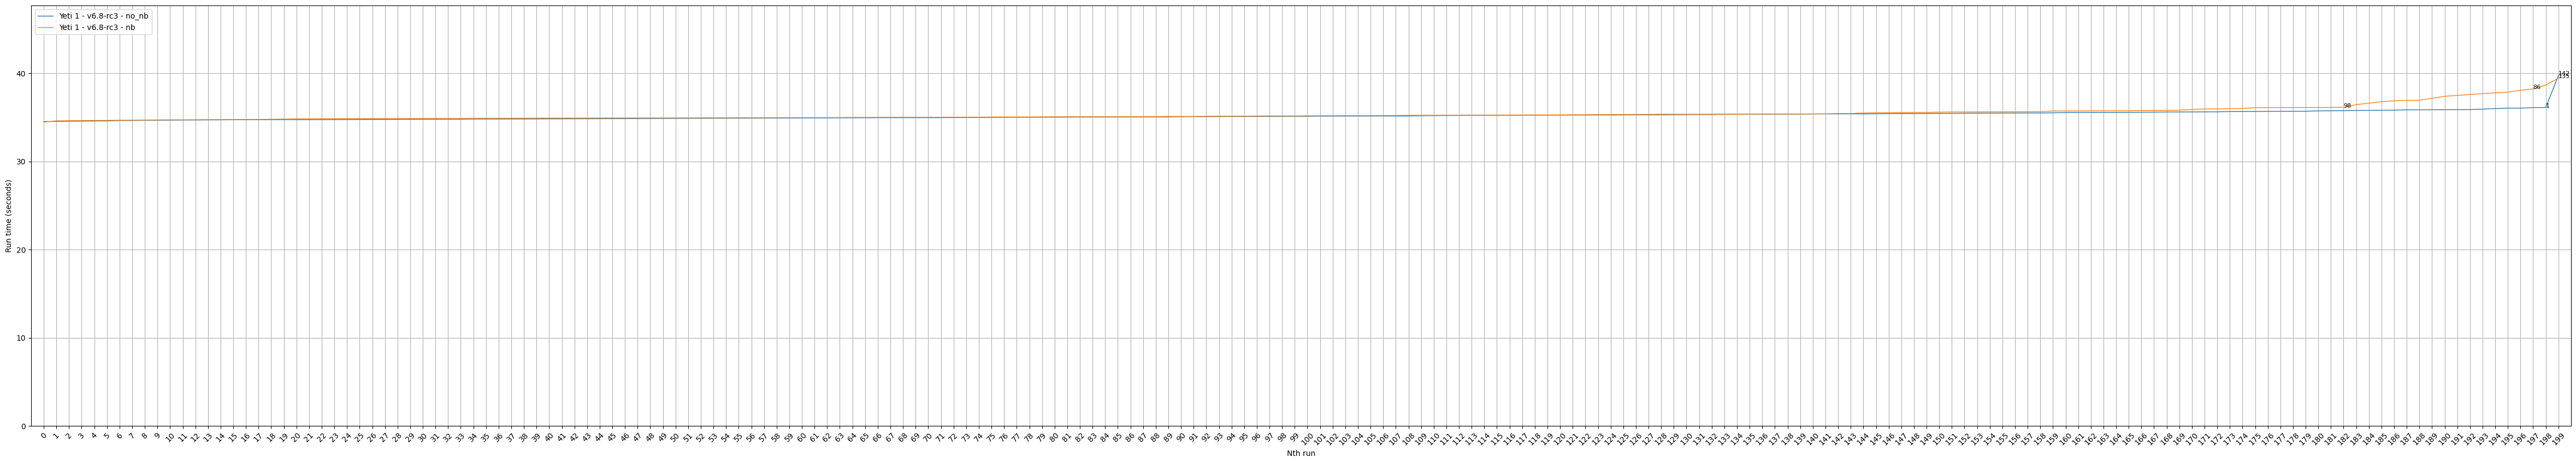

In [172]:
sort_by='duration'
# sort_by='run_index'
init_runs_plot()
# show_run_index = False
plot_trace_cmd_benchmark_dir("mg.D.28-02.yeti-1.v6.8-rc3", "Yeti 1 - v6.8-rc3 -", show_run_index=show_run_index, sort_by=sort_by)
# plot_trace_cmd_benchmark_dir("mg.D.x__yeti-2__v6.8.0-rc3__2024-03-06", "Yeti 2 - v6.8-rc3 OMP -", show_run_index=show_run_index, sort_by=sort_by)

# plot_trace_cmd_benchmark_dir("mg.d.dahu-28.v6.1.0-17", "Dahu - v6.1.0-17 -", show_run_index=show_run_index, sort_by=sort_by)

plt.show()

#### cg.C - Yeti & Dahu

cg.C on yeti 2
Available time series names : ['nb-disabled-none', 'nb-enabled-none', 'nb-disabled-sockets']


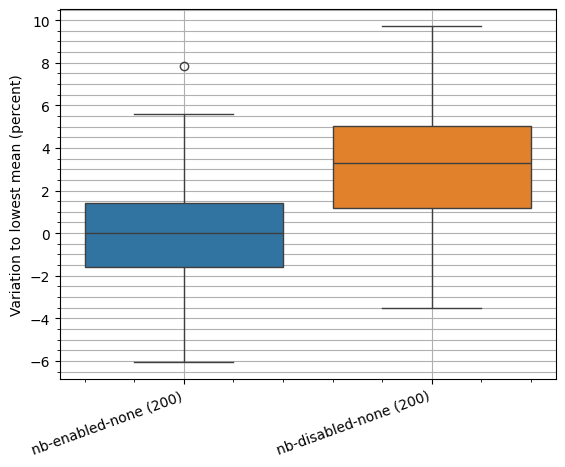

In [34]:
sort_by='duration'
# sort_by='run_index'
show_run_index = True

print("cg.C on yeti 2")
bp = BoxPlotter()
bp.add_trace_cmd_directory("cg.C.x__yeti-2__v6.8.0-rc3__2024-03-06")
bp.print_filter_names()
bp.show_variations(name_filters=["none"])

# print("cg.C on yeti 2")
# init_runs_plot()
# plot_trace_cmd_benchmark_dir("cg.C.x__yeti-2__v6.8.0-rc3__2024-03-06", "Yeti 2 - v6.8-rc3 -", show_run_index=show_run_index, sort_by=sort_by)
# plt.show()

# print("cg.C on dahu 18")
# init_runs_plot()
# plot_hyperfine_benchmark_dir("cg.C.dahu-18.v6.8-rc3", "Dahu 18 - v6.8-rc3 -")
# # plot_trace_cmd_benchmark_dir("cg.C.dahu-18.v6.8-rc3", "Dahu 18 - v6.8-rc3 -", show_run_index=show_run_index, sort_by=sort_by)
# plt.show()


### Phoronix build-kernel

In [137]:
dir_path = get_result_dir_path("build-linux-kernel__dahu-31__v6.8.0-rc3__performance__2024-03-13")
file_location = "nb-enabled/build-linux-kernel__dahu-31__v6.8.0-rc3__performance__2024-03-13-phoronix.json"

def get_phoronix_results(dir_path) -> List[List[float]] :
    filename = os.listdir(dir_path)[0]
    with open(os.path.join(dir_path, filename)) as f:
        data = json.load(f)
    results = []
    for res in data['results'].values() :
        result_obj = list(res['results'].values())[0]
        results.append(result_obj['raw_values'])
    return results

# TODO Have the option not to focus on 0
# Benchmark dir is a parent directory that contain specific directories that contain themselves several runs
def plot_phoronix_benchmark_dir(benchmark_dir_name, should_sort = False) :
    benchmark_dir_path = get_result_dir_path(benchmark_dir_name)
    contents = os.listdir(benchmark_dir_path)
    for c in contents :
        dir_path = os.path.join(benchmark_dir_path, c)
        if not os.path.isdir(dir_path) :
            continue
        
        results = get_phoronix_results(dir_path)
        for idx, res in enumerate(results) :
            if should_sort :
                res.sort()
            plot_hyperfine_run(res, label = str(idx) + " - " + c, color = None, init_plot = False)


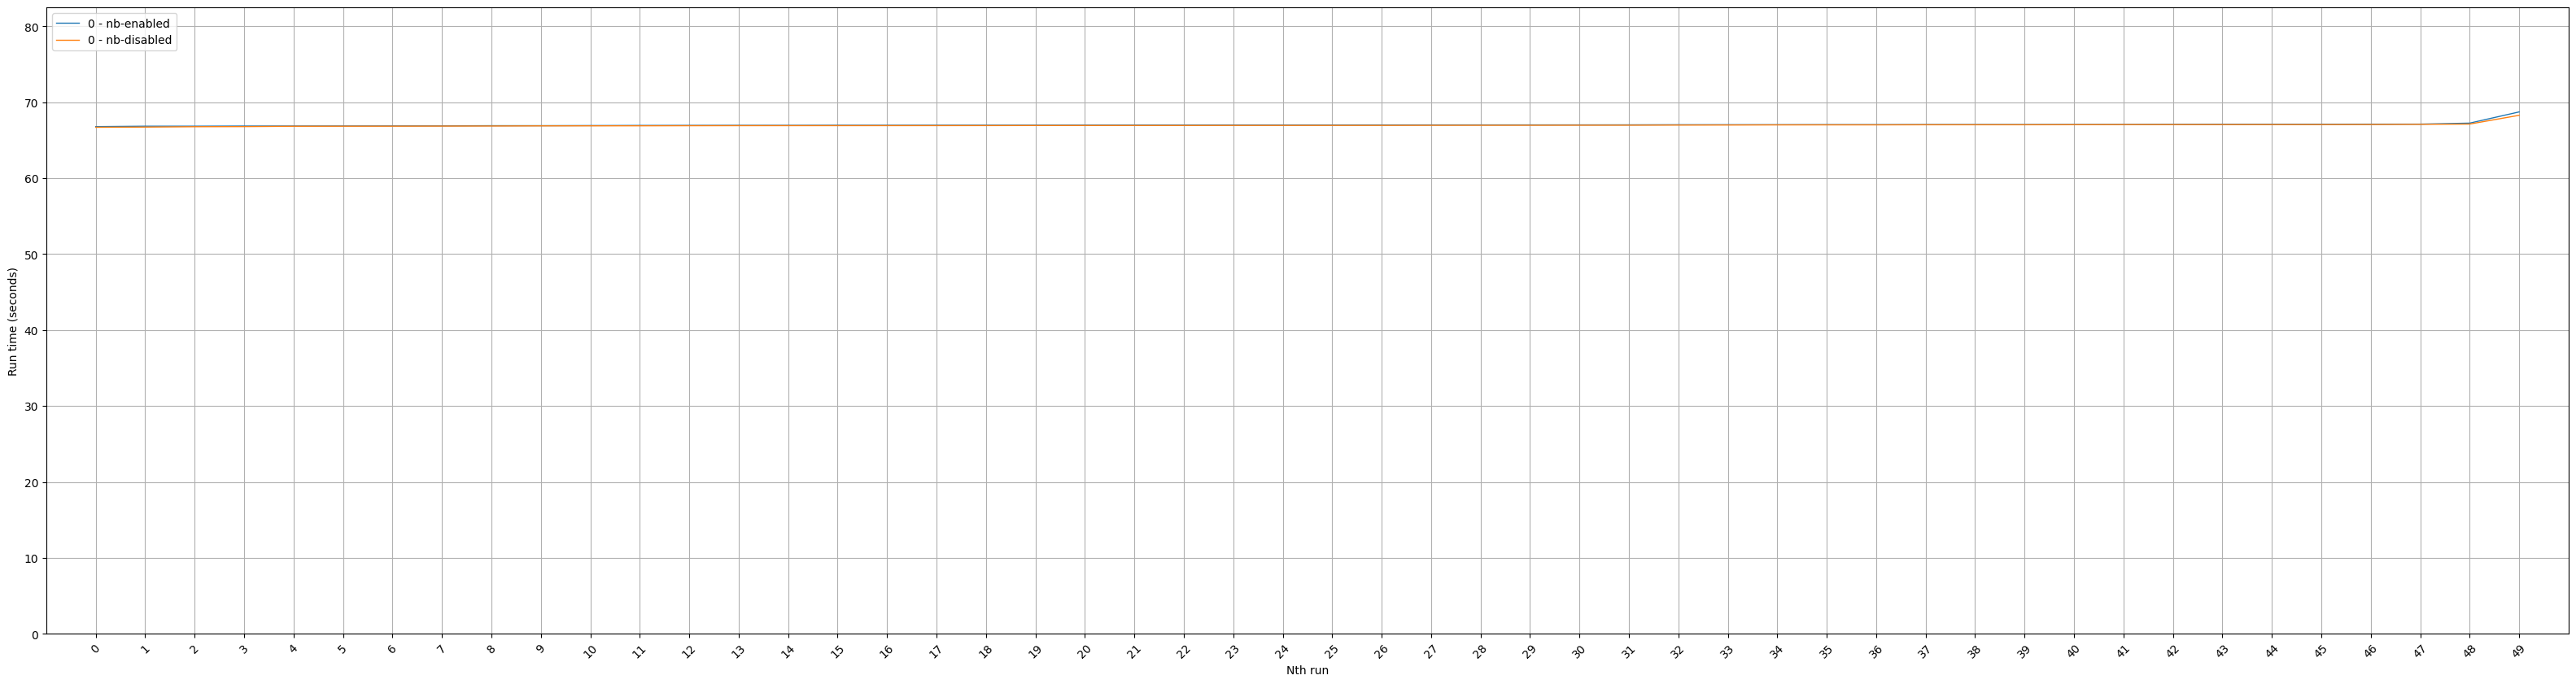

In [193]:
init_runs_plot()
plot_phoronix_benchmark_dir("build-linux-kernel__dahu-31__v6.8.0-rc3__performance__2024-03-13", True)
plt.show()

### Phoronix svt-av1

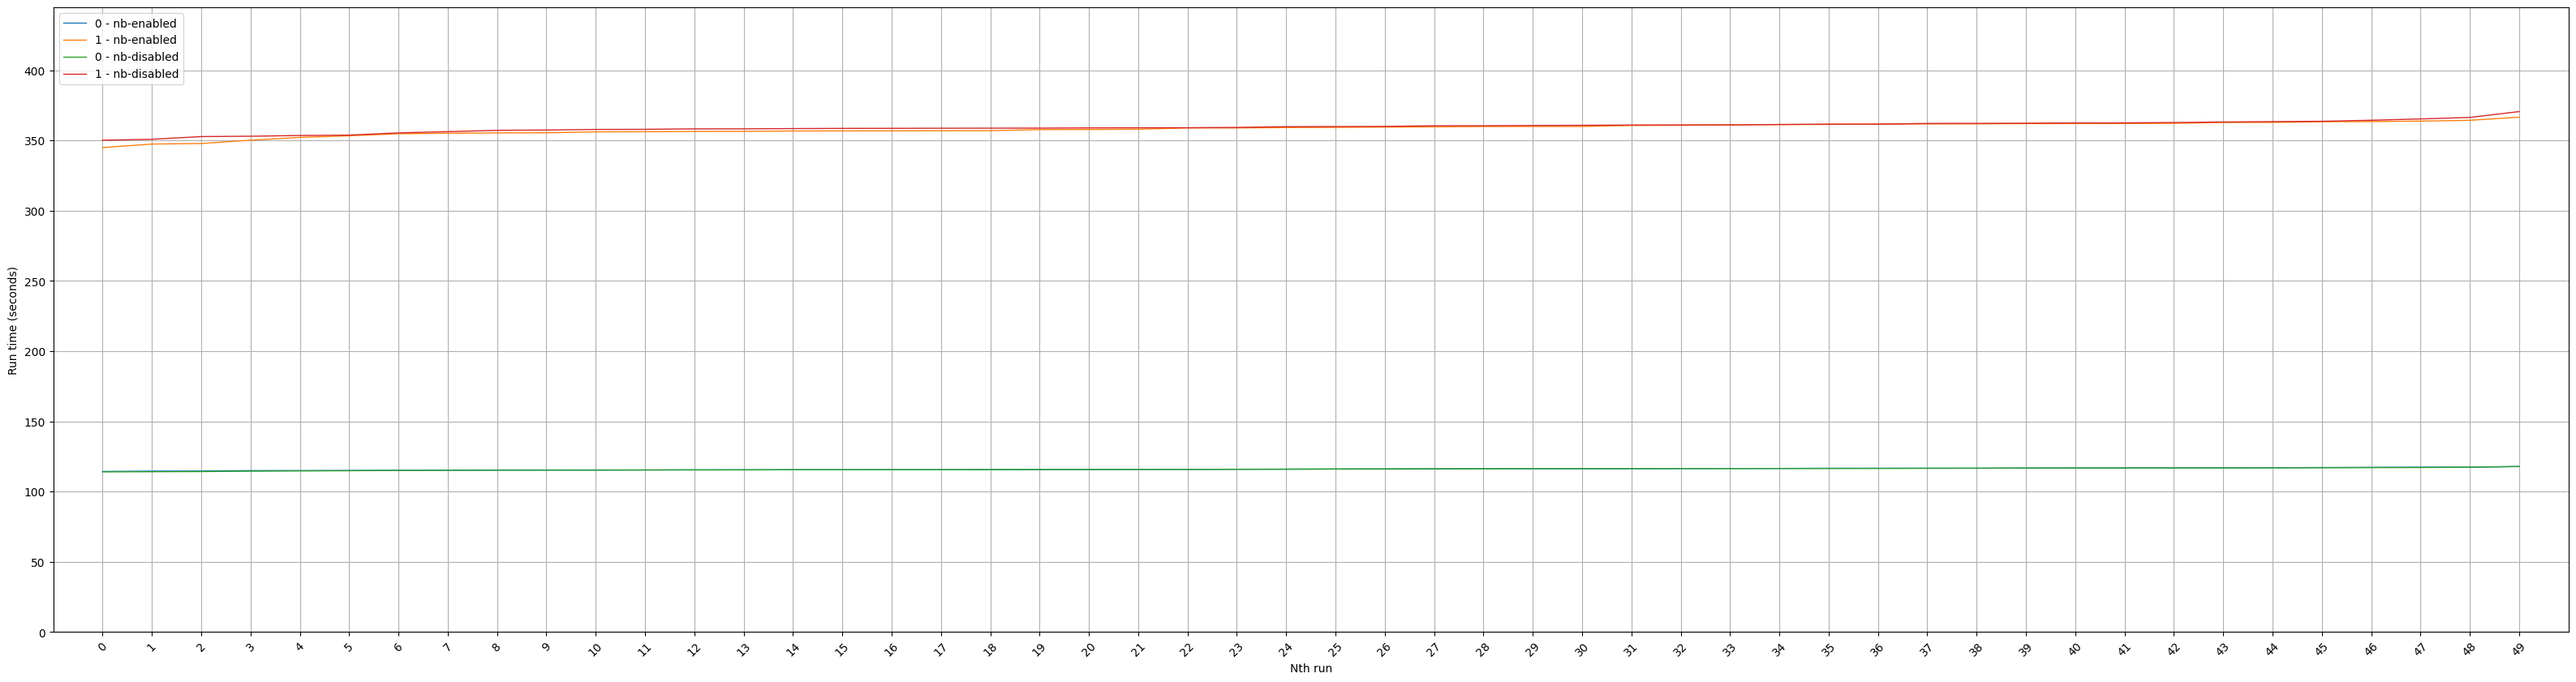

In [194]:
init_runs_plot()
plot_phoronix_benchmark_dir("svt-av1__dahu-31__v6.8.0-rc3__performance__2024-03-13", True)
plt.show()

### Phoronix dav1d

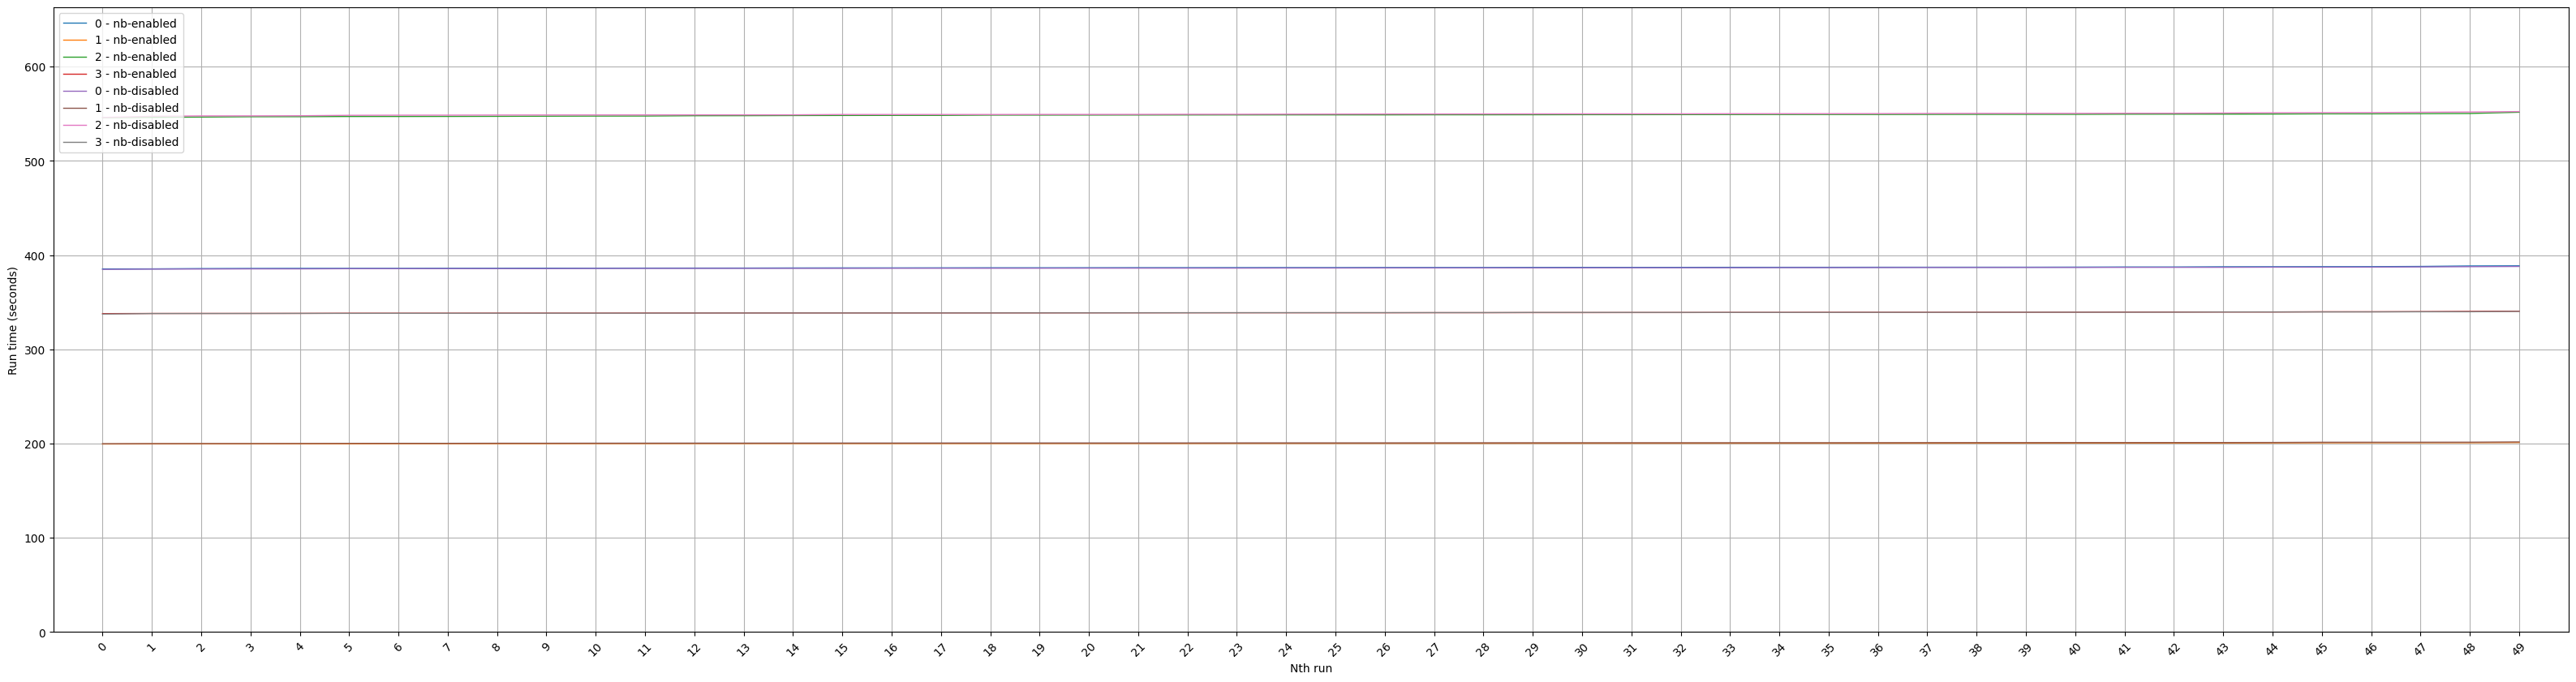

In [195]:
init_runs_plot()
plot_phoronix_benchmark_dir("dav1d__dahu-25__v6.8.0-rc3__performance__2024-03-13", True)
plt.show()

### Phoronix lu.C

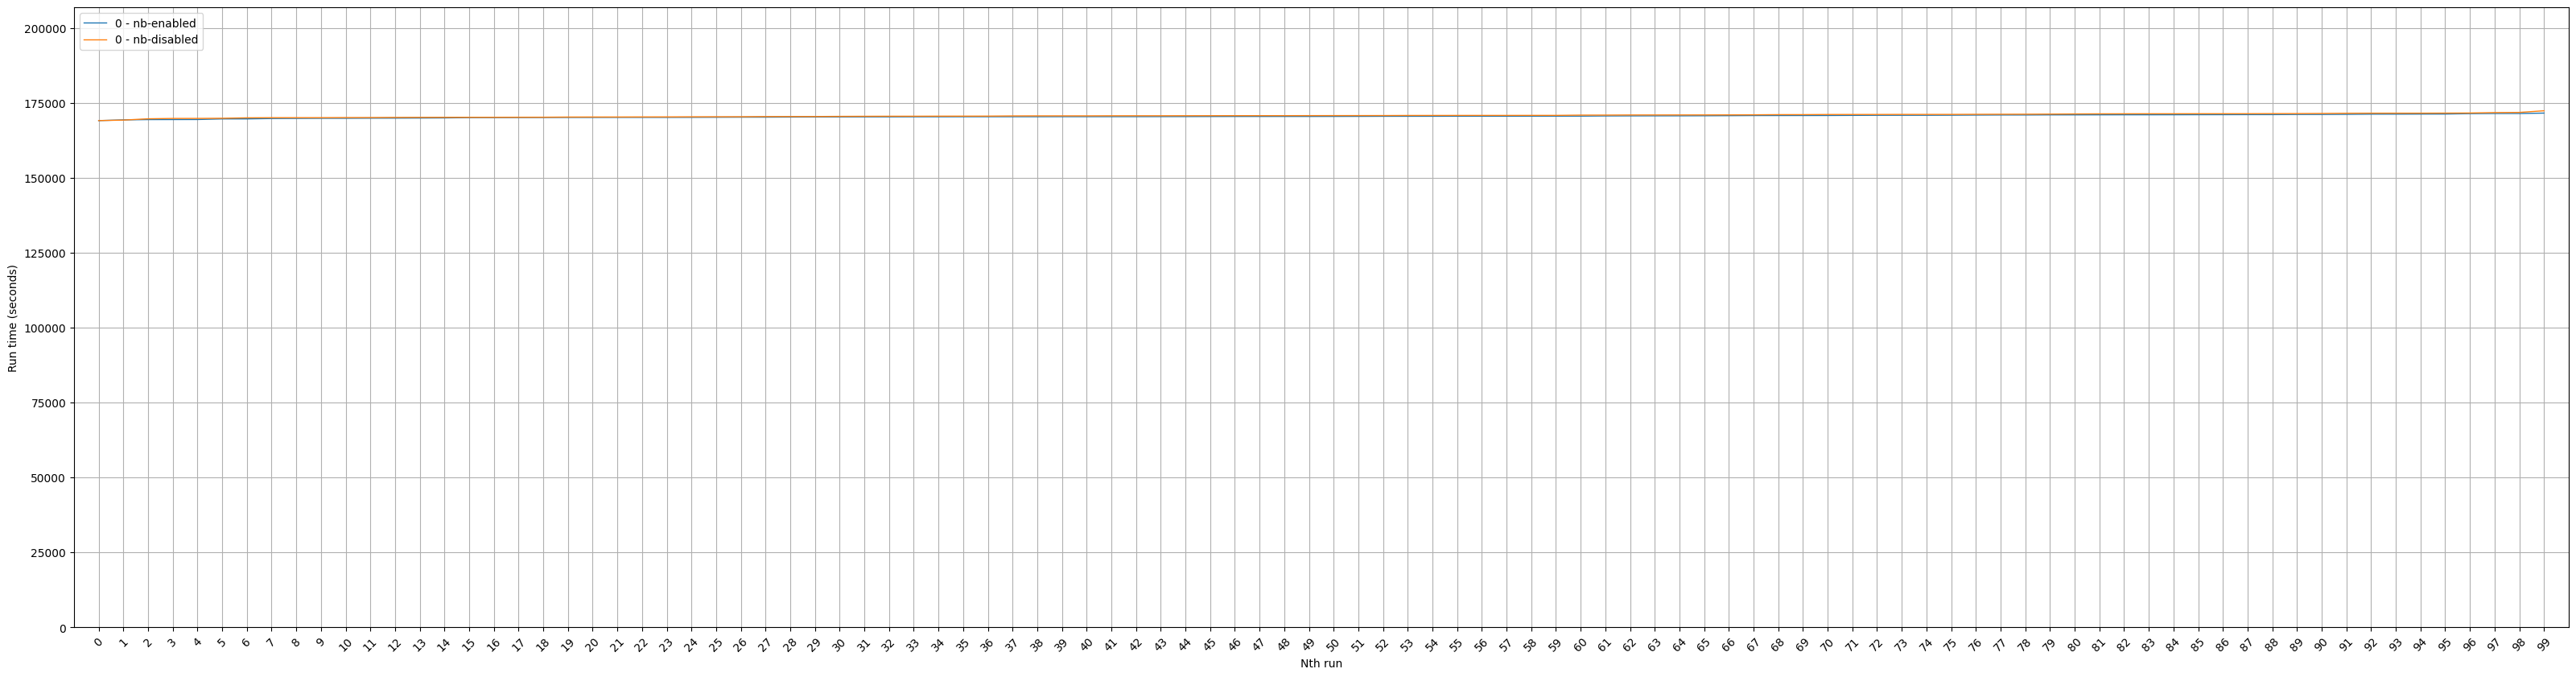

In [198]:
init_runs_plot()
plot_phoronix_benchmark_dir("_phoronix/npb__yeti-1__v6.8.0-rc3__performance__2024-03-14", True)
plt.show()

#### Kernel v6.8.0-rc3

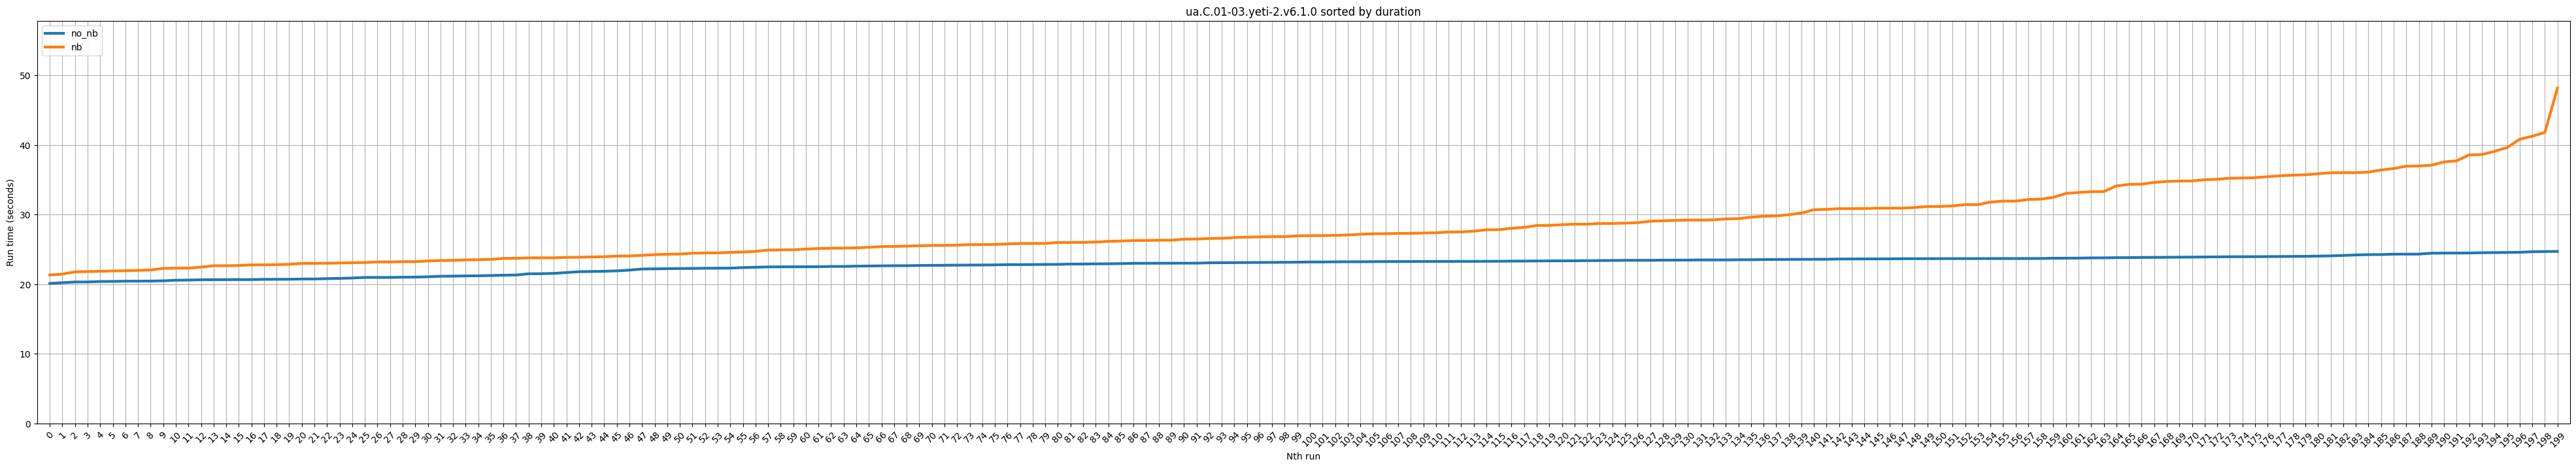

In [18]:
plot_trace_cmd_benchmark_dir("ua.C.01-03.yeti-2.v6.1.0", show_run_index=False, sort_by='duration')

bt.B.dahu-17.v6.8-rc3


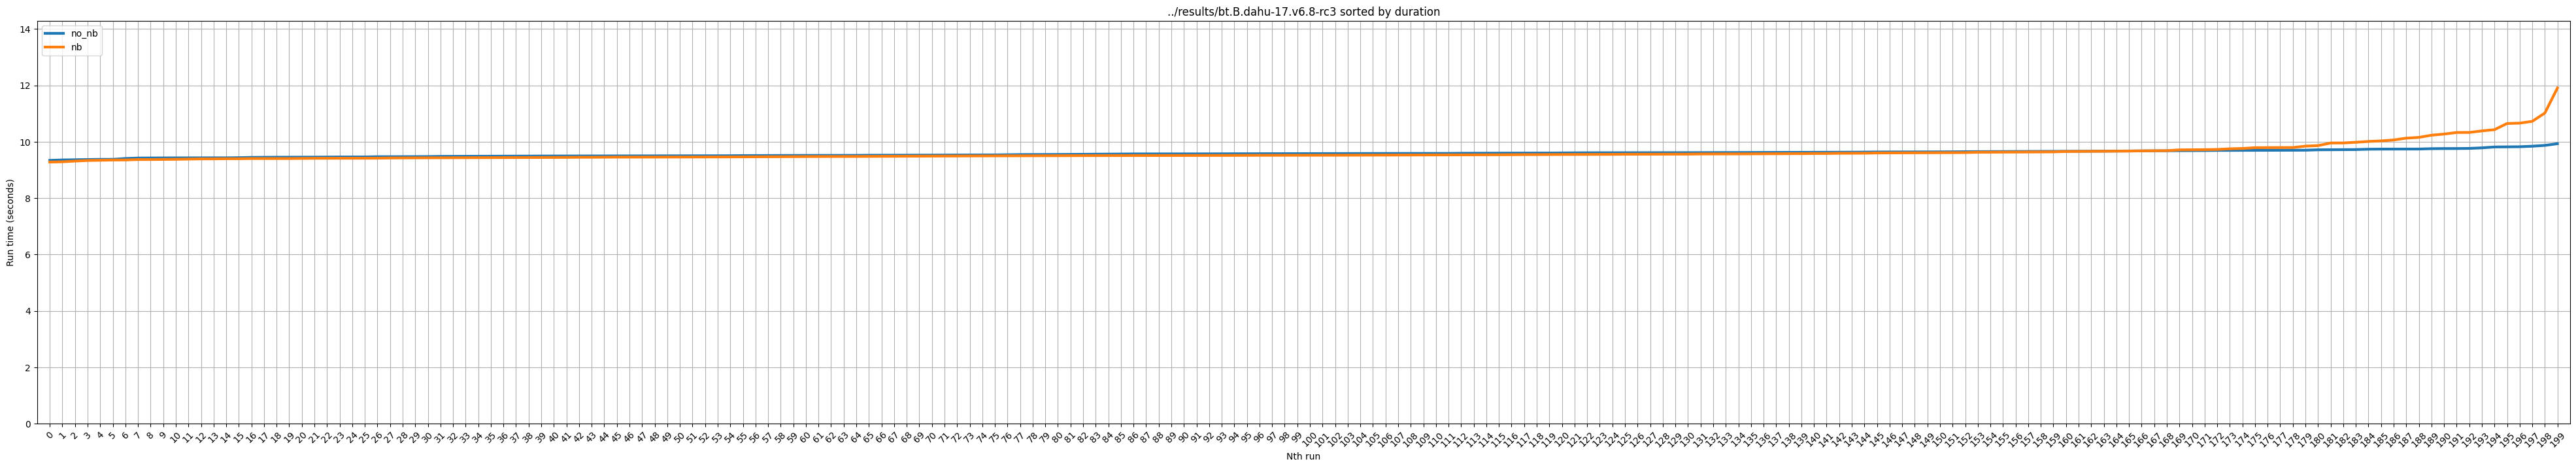

bt.C.dahu-28.v6.8-rc3


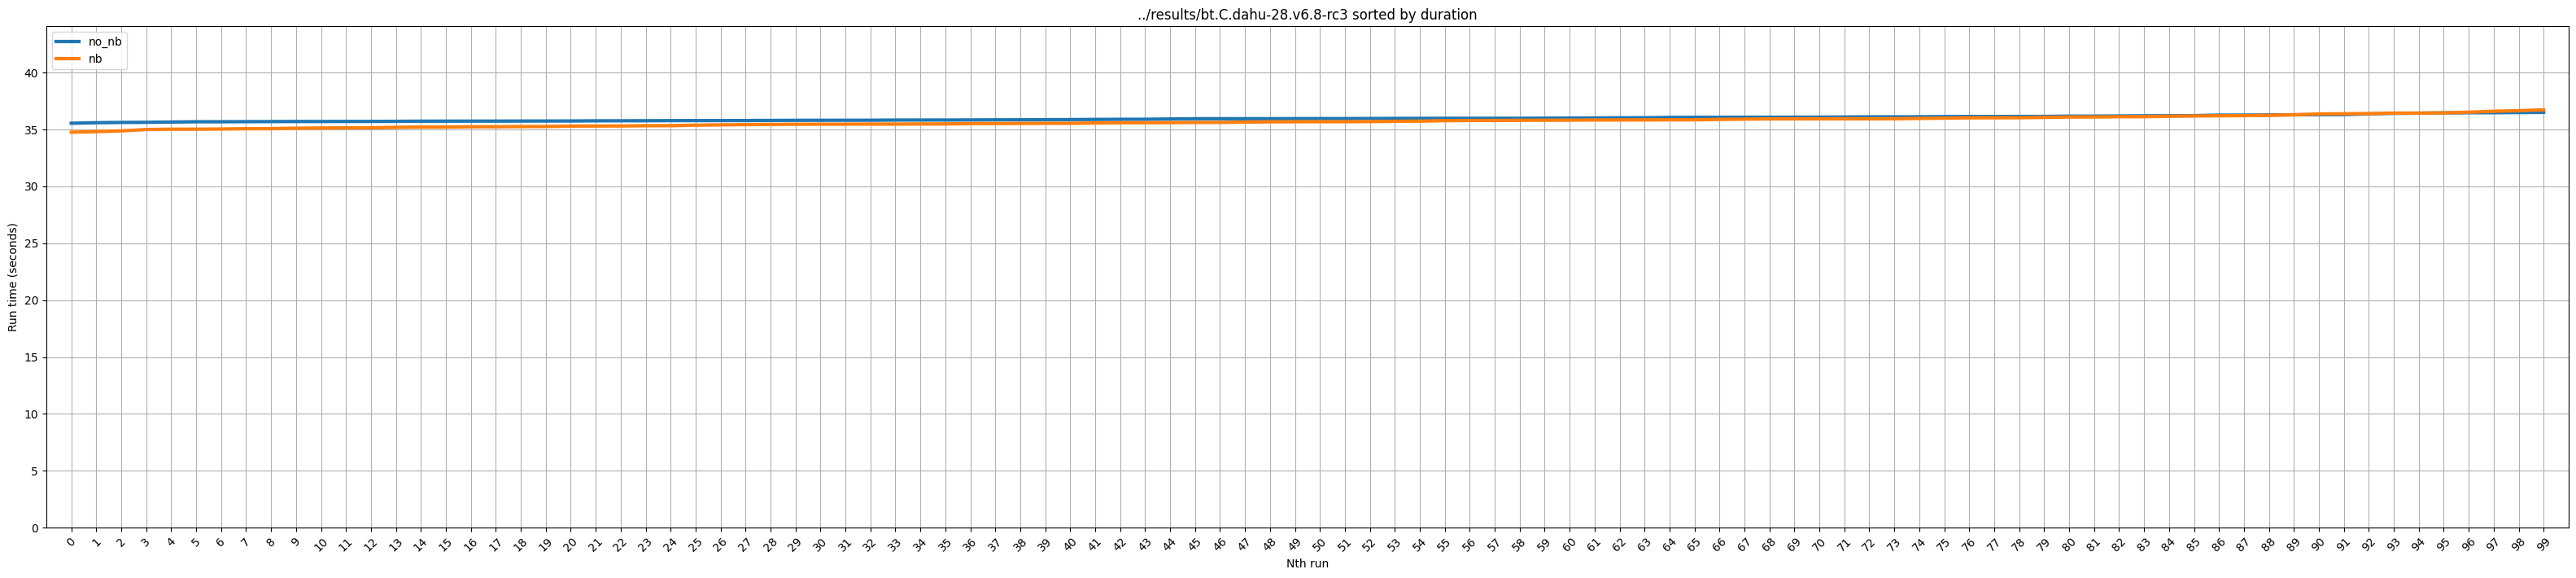

cg.C.26-02--2.servan-2.v6.8-rc3


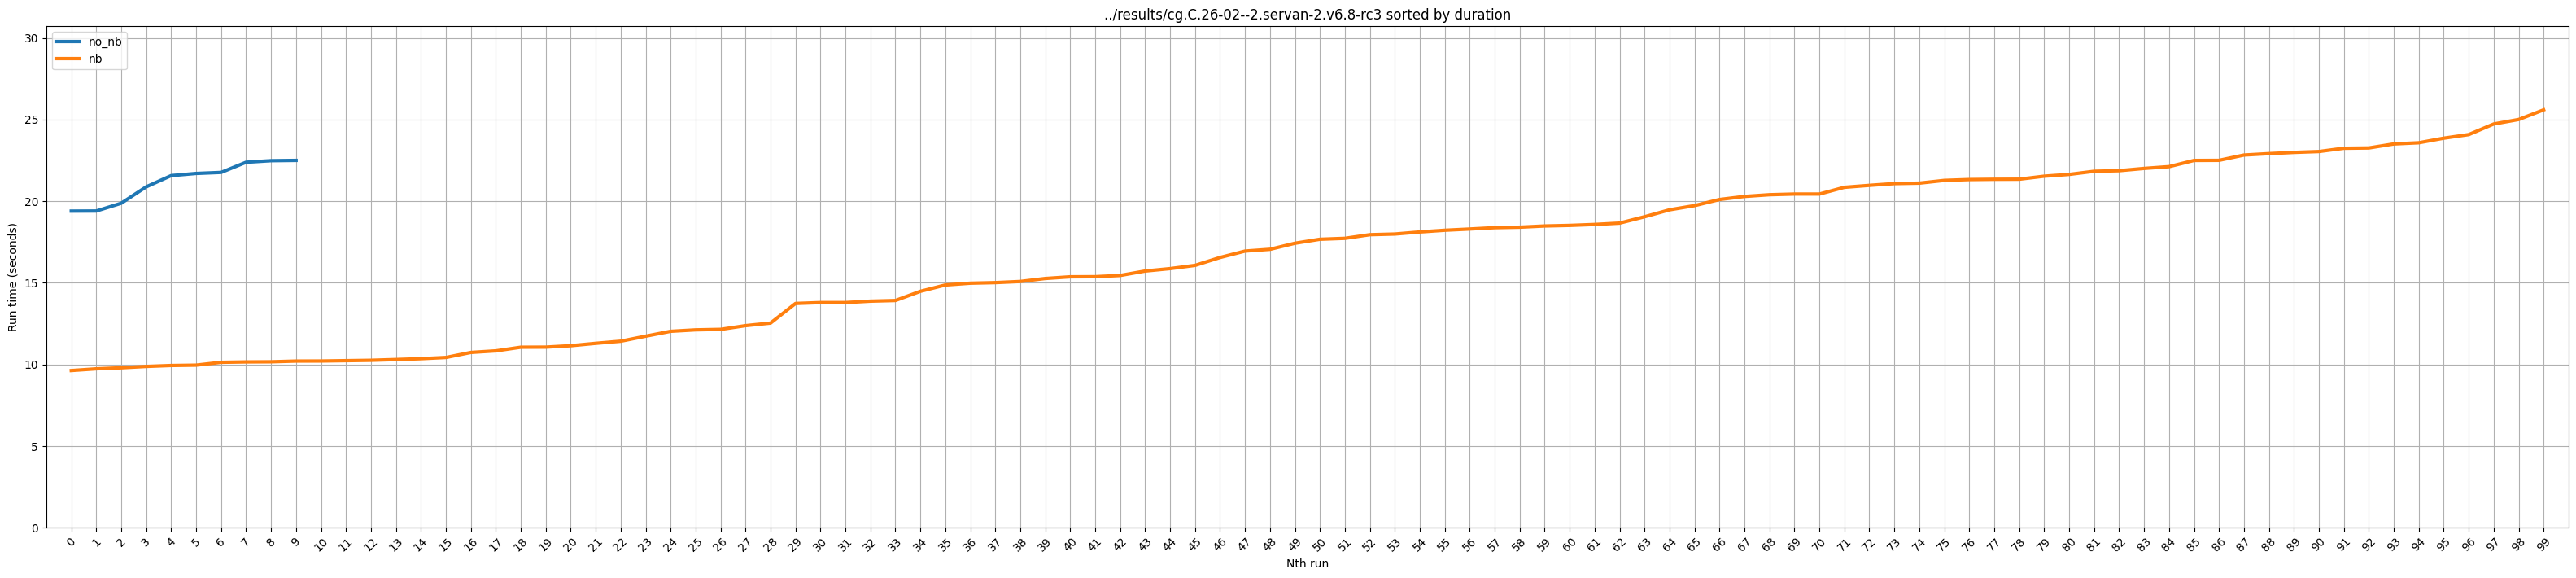

cg.C.26-02.servan-2.v6.8-rc3


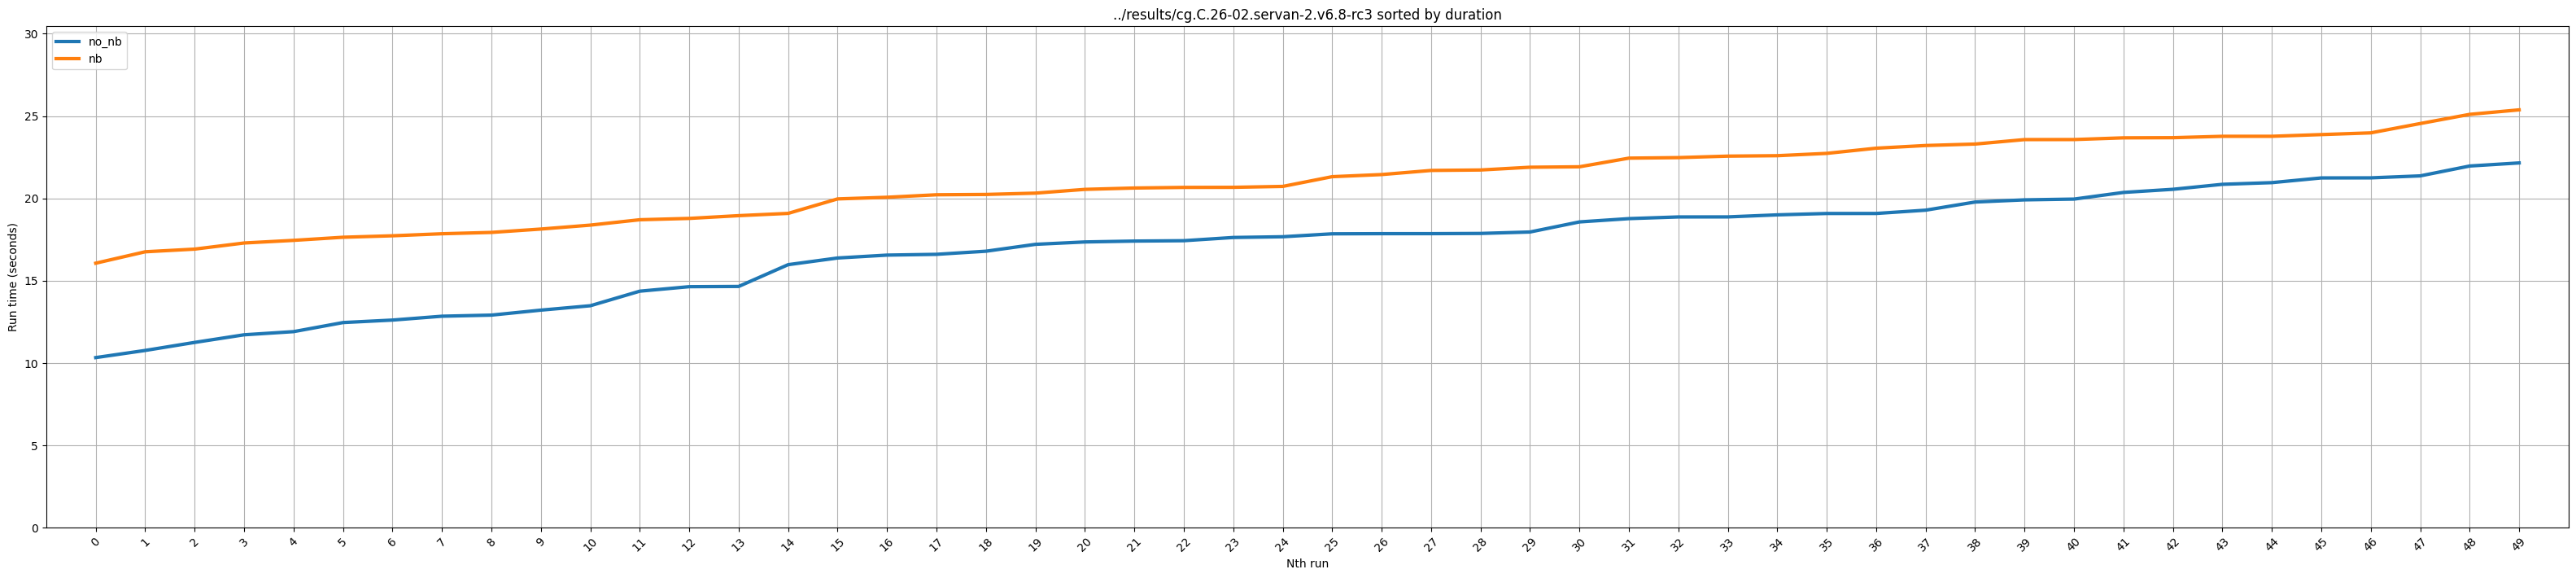

cg.C.and.bt.B.servan-2.v6.8-rc3


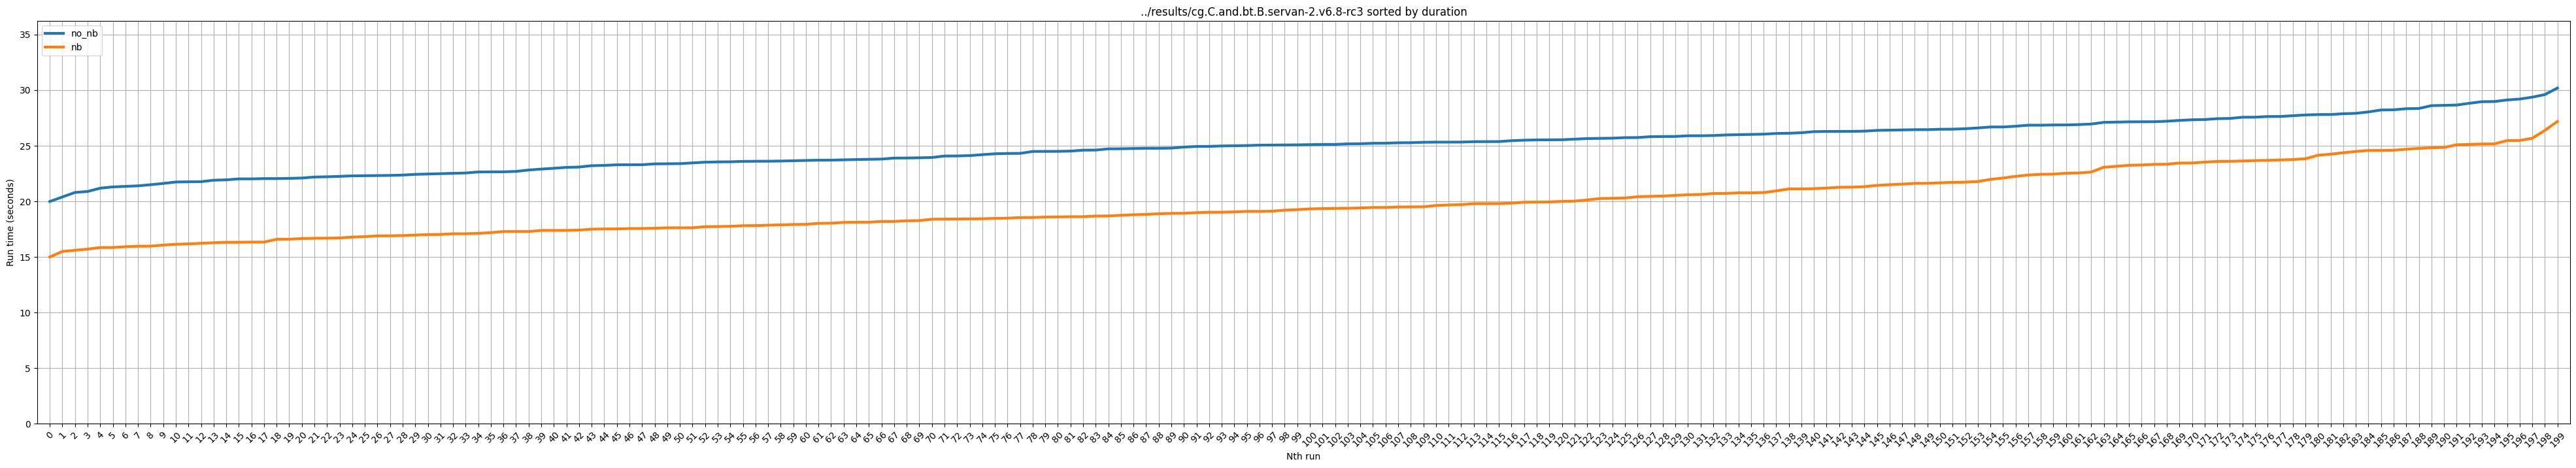

cg.C.servan-1.v6.8-rc3


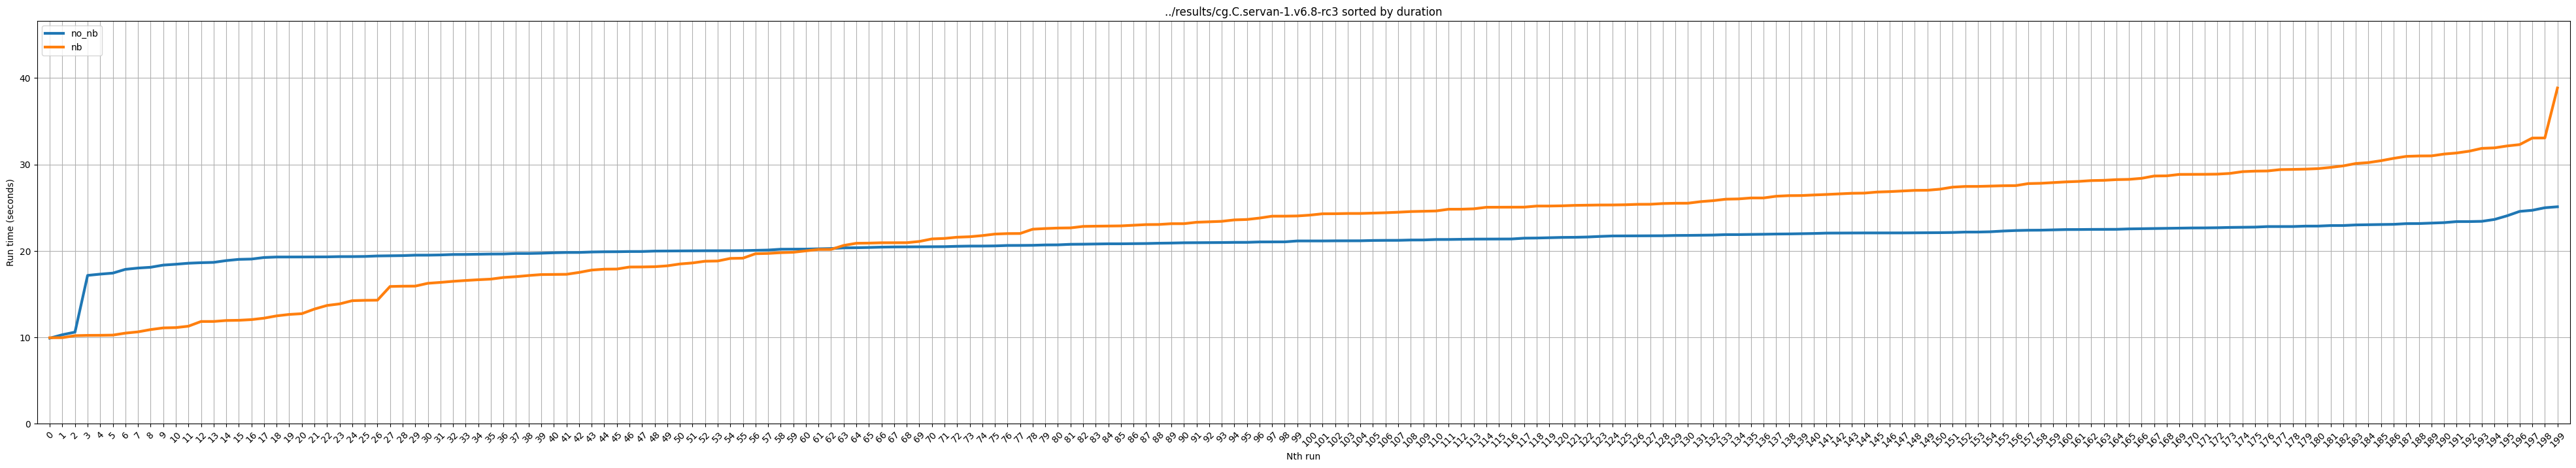

cg.C.servan-2.thermal2.v6.8-rc3


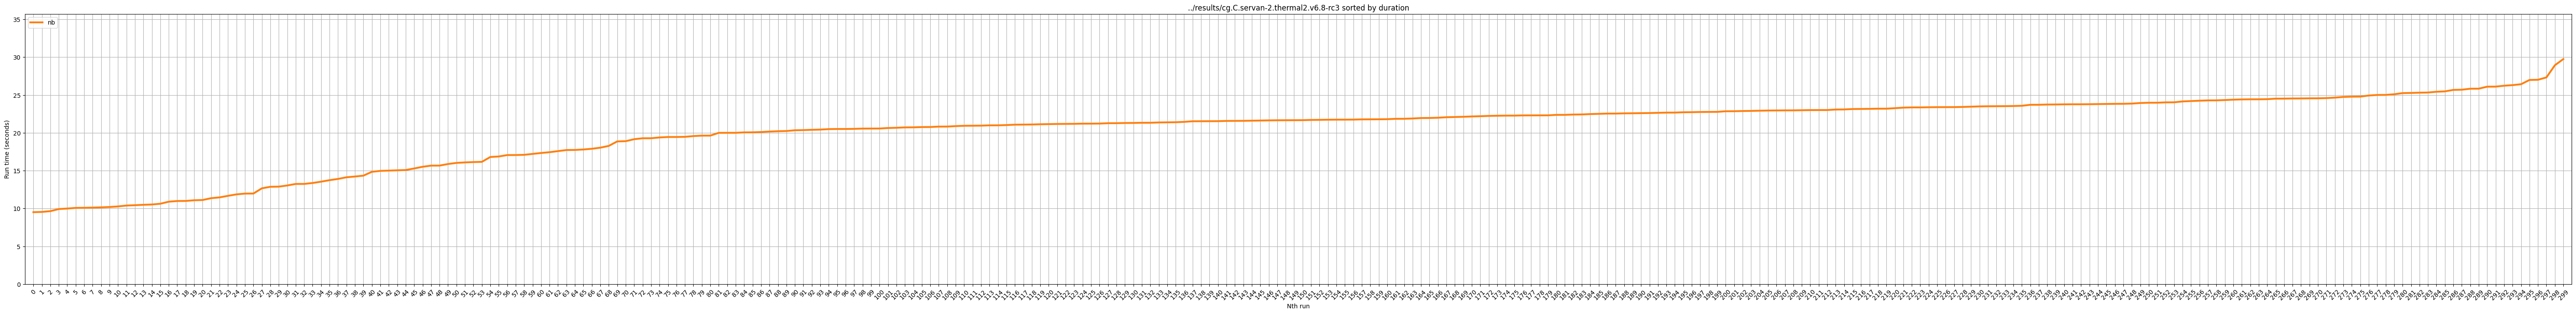

ft.C.yeti-4.v6.8-rc3


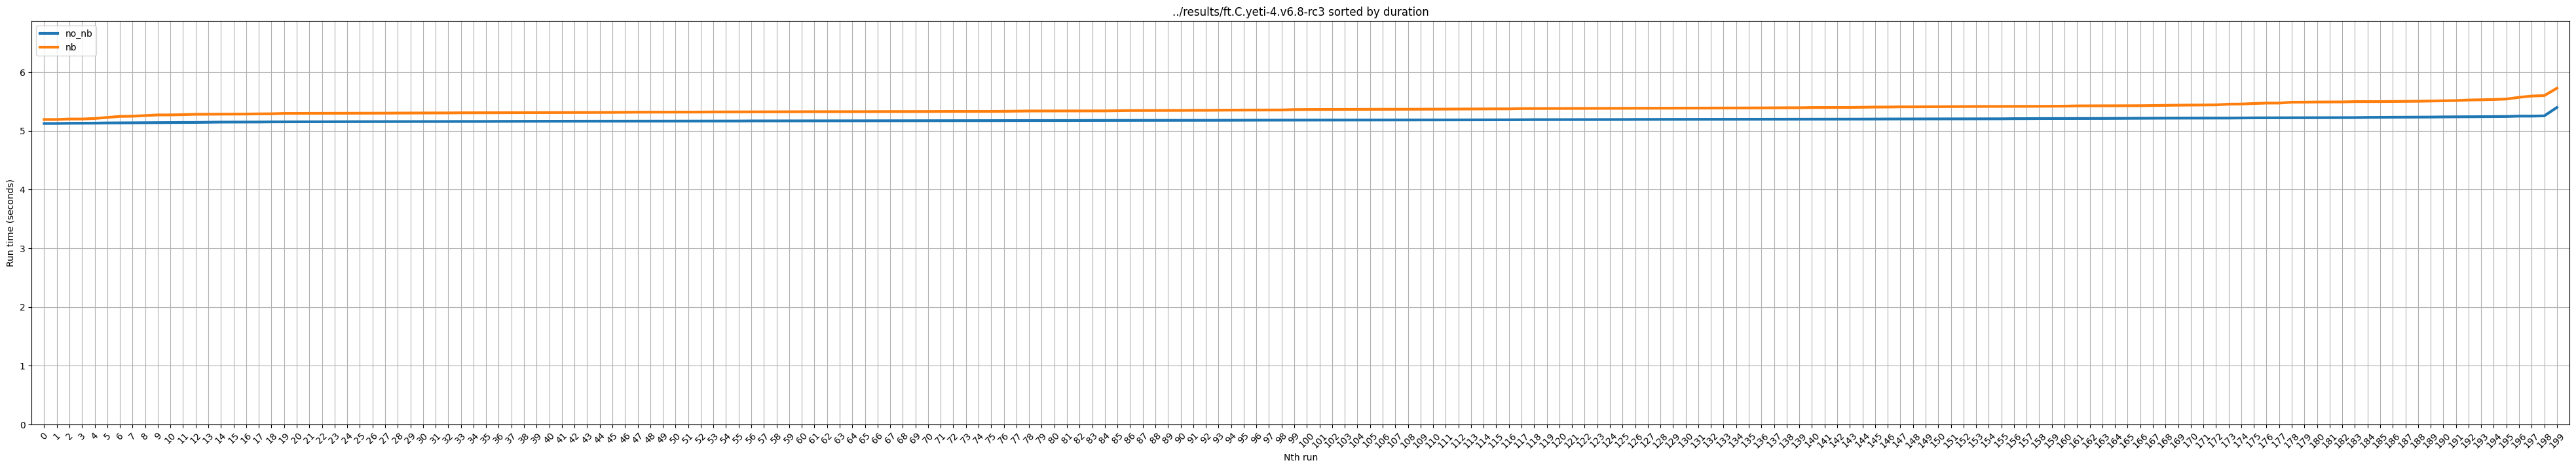

lu.B.27-02.thermal.servan-2.v6.8-rc3


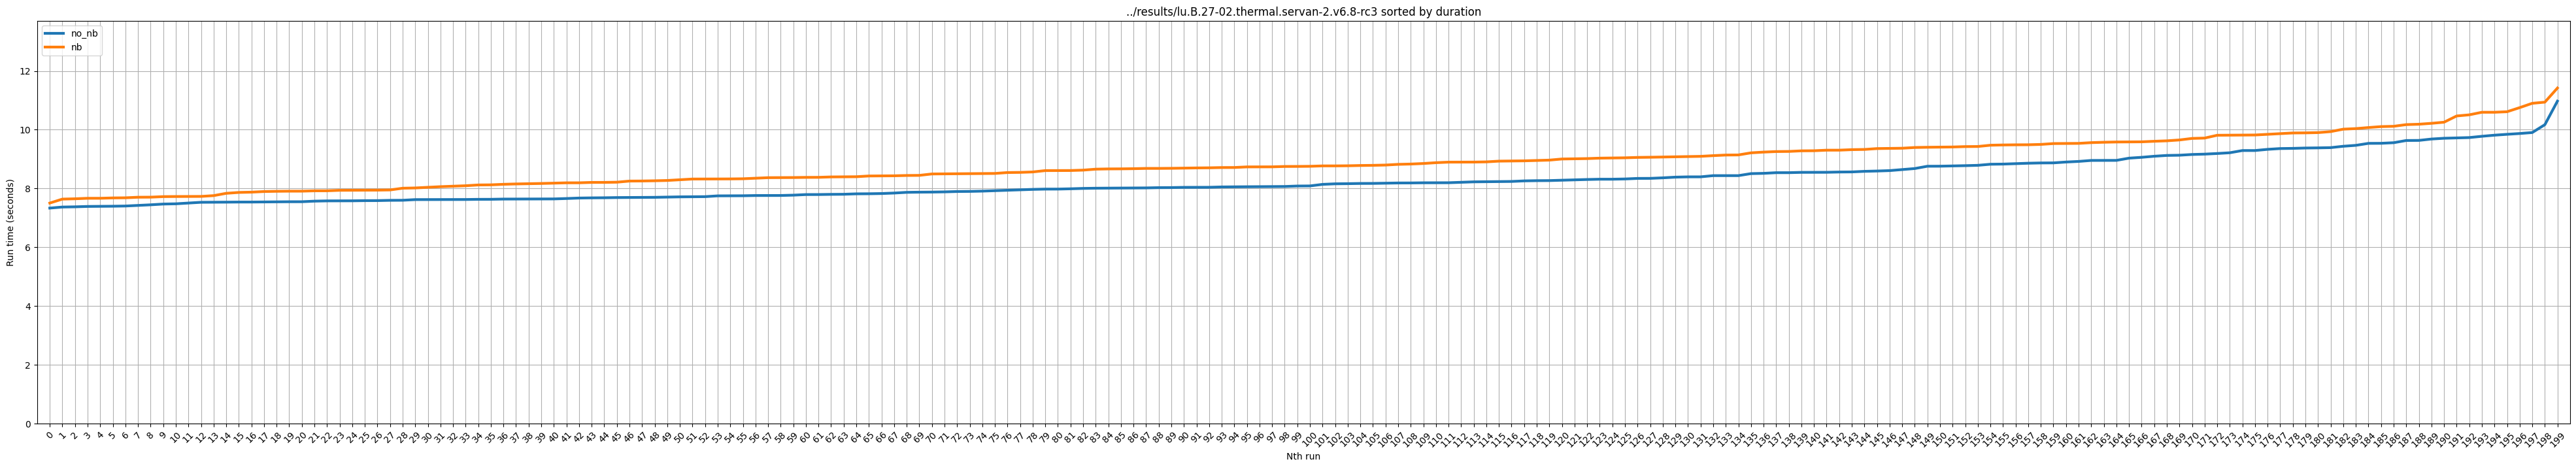

lu.B.dahu-17.v6.8-rc3


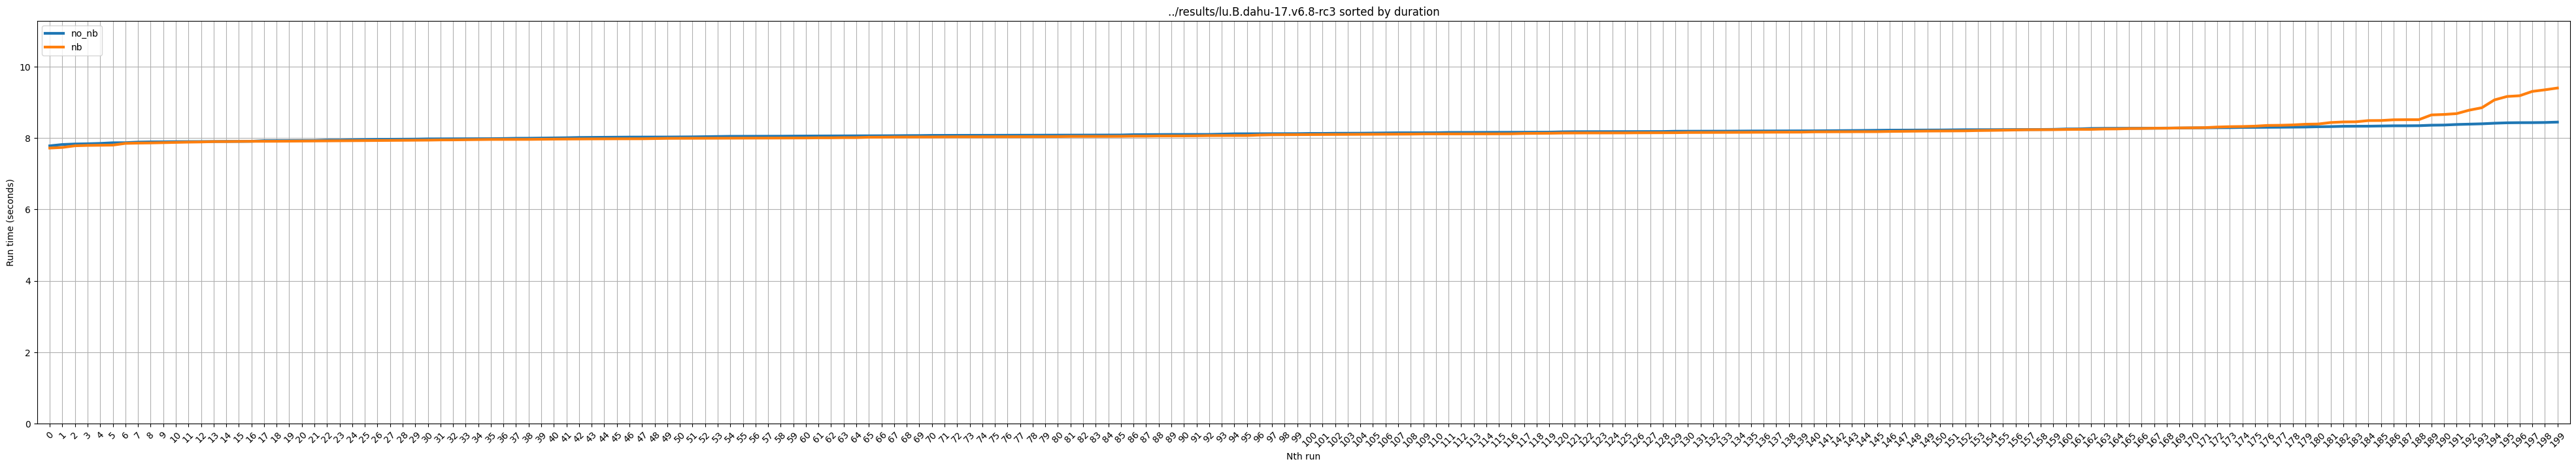

lu.C.dahu-18.v6.8-rc3


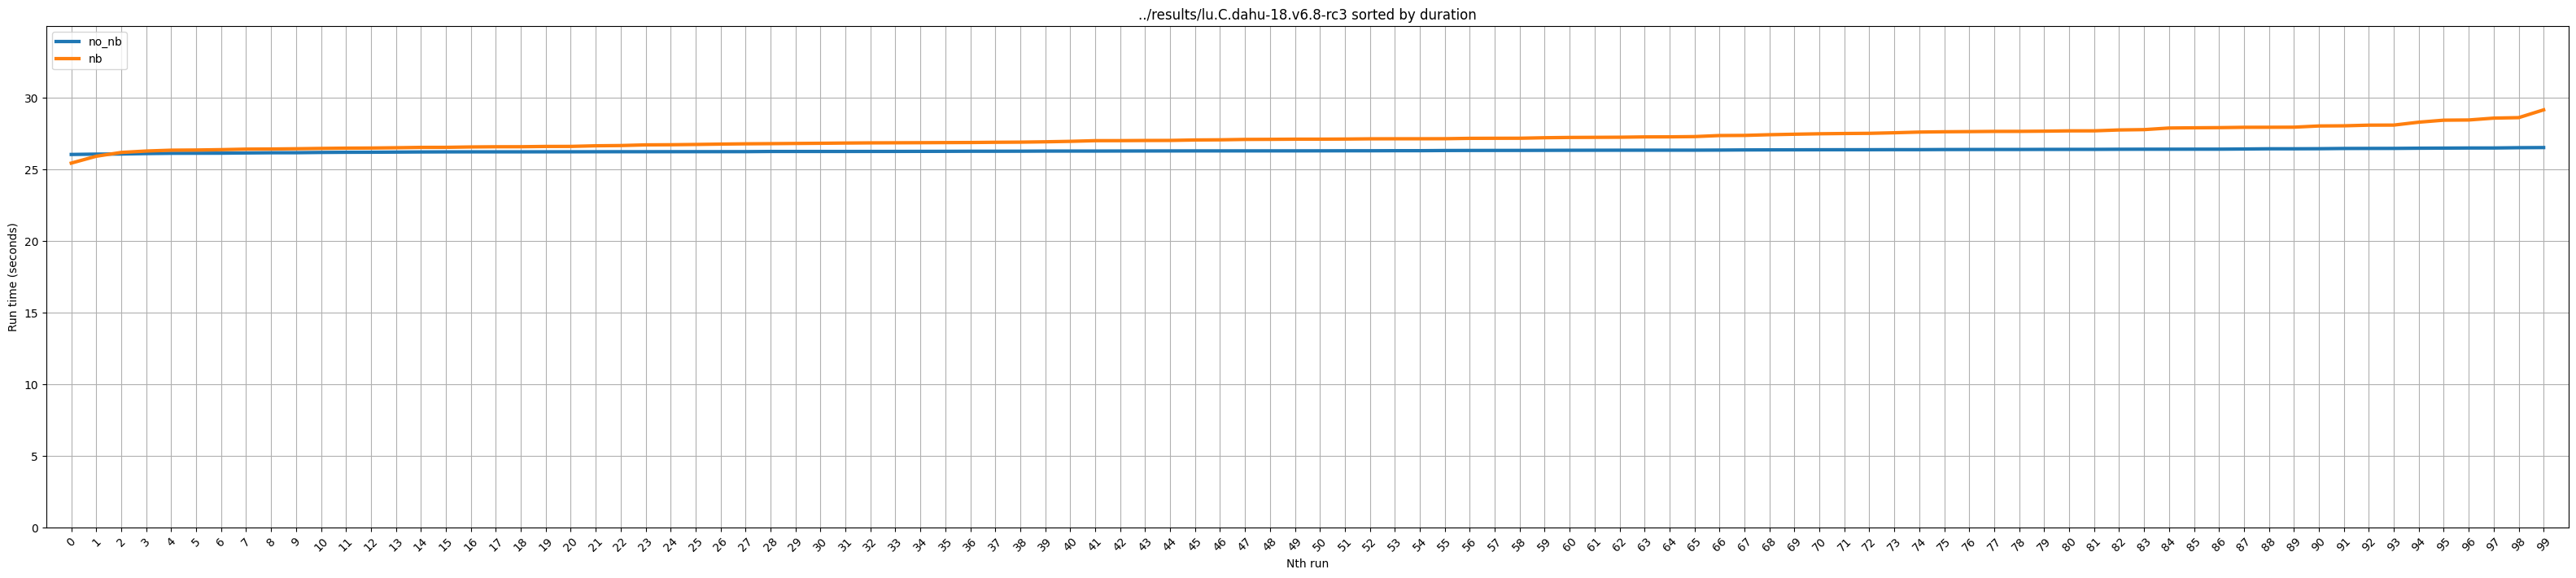

lu.C.yeti-4.v6.8-rc3


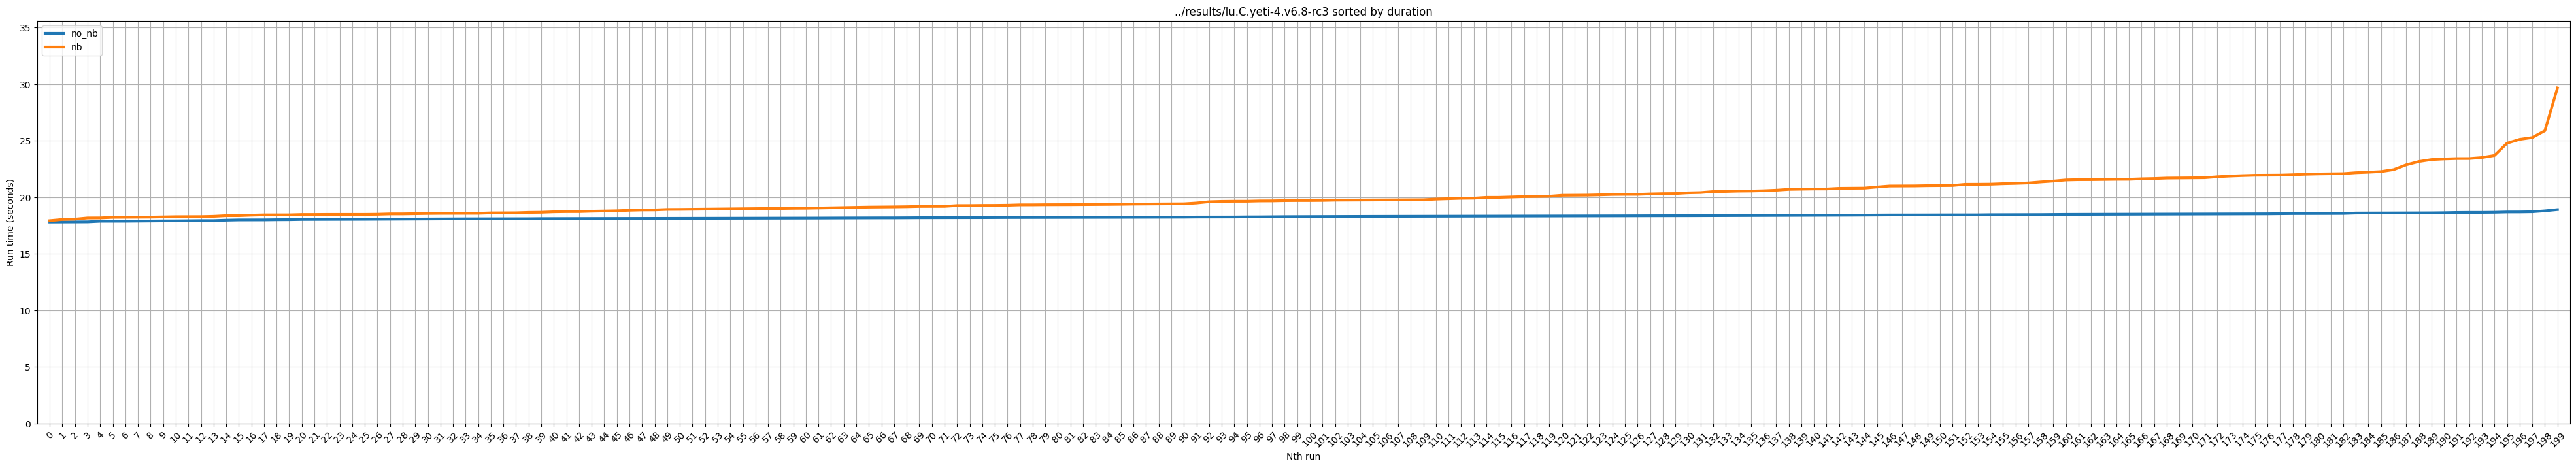

mg.D.28-02.yeti-1.v6.8-rc3


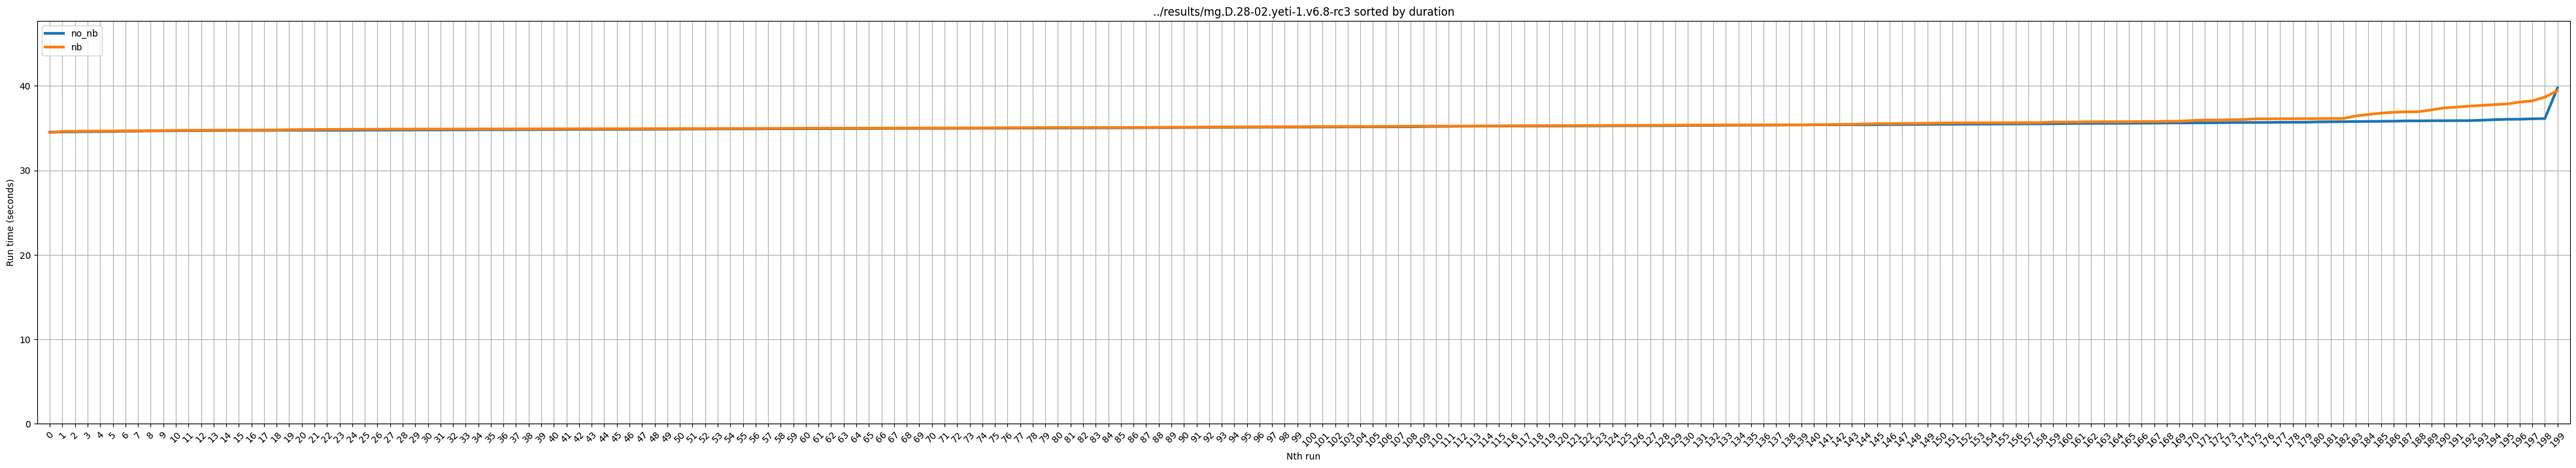

ua.C.28-02.yeti-3.v6.8-rc3


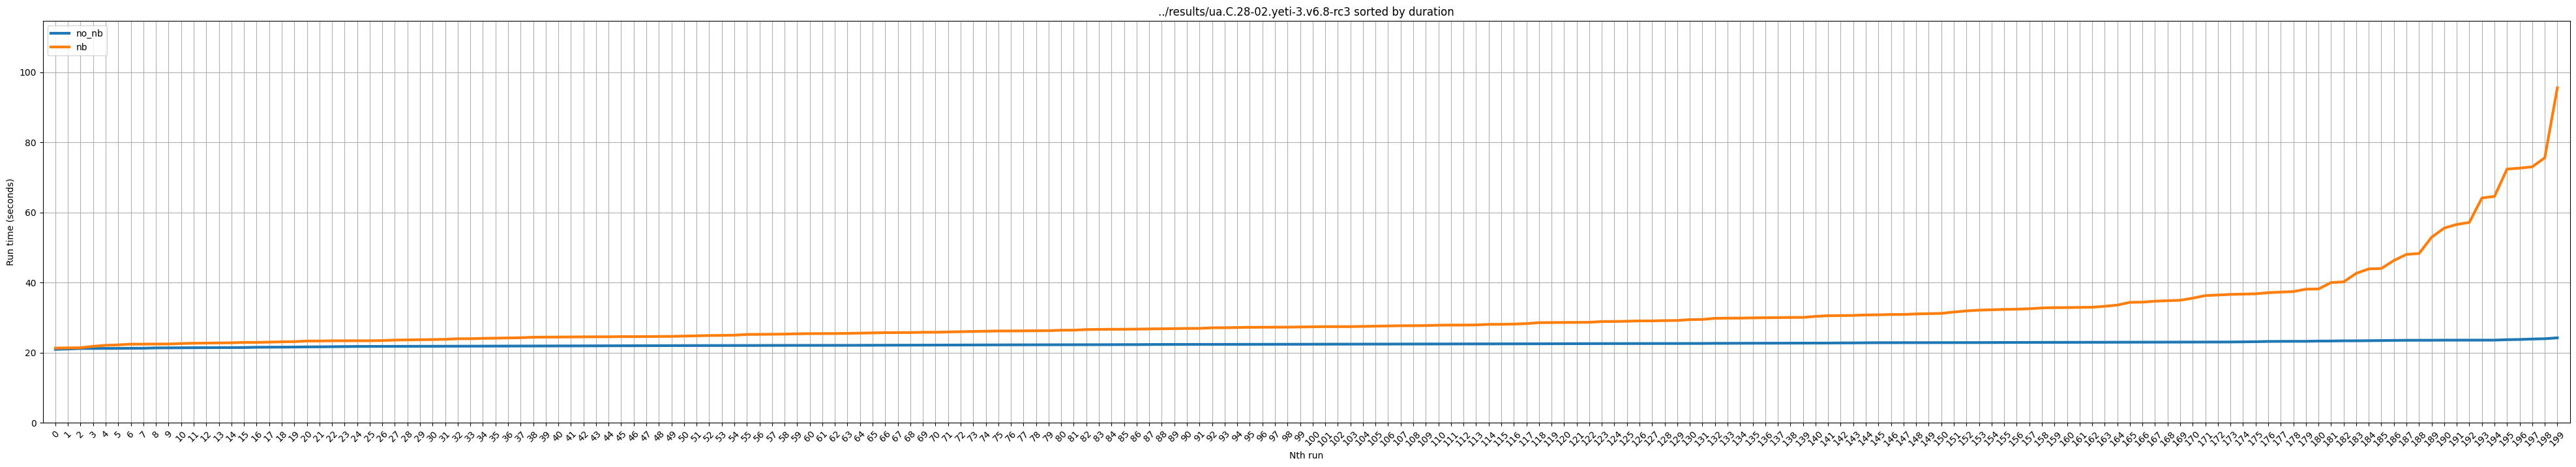

Done


In [97]:
for dir in trace_cmd_benchmark_dirs :
    if not dir.endswith('rc3'):
        continue
    benchmark_dir = get_result_dir_path(dir)
    print(dir)
    plot_trace_cmd_benchmark_dir(benchmark_dir, show_run_index=False, sort_by='duration')
print("Done")